## Chapter 11: Principles of Feature Learning

# 11.4 Efficient cross-validation via regularization

In this Section we introduce a second general paradigm for effective cross-validation - or the effective search for a proper capacity model.   With the first apprach discussed in the previous Section - *boosting* - we took a 'bottom-up' approach to fine tuning the proper amount of capacity a model needs: that is we began with a *low capacity* model and then gradually increased its capacity by adding additional units (from the same family of universal approximators) until we built up 'just enough' capacity (that is the amount that minimizes validation error). 

In this Section we introduce the complementary approach - called *regularization*.  Instead of building up capacity 'starting at the bottom' with regularization we 'start at the top', taking a 'top-down' view and start off with a high very capacity model (that is one which would likely overfit, providing a low training error but high validation error) and gradually *decrease* its capacity until the capacity is 'just right' (that is, until validation error is minimized).  While in principle any universal approximator can be used with regularization, in practice regularization is often the cross-validation approach of choice when employing both kernel and neural network universal approximators.

In [ ]:
## This code cell will not be shown in the HTML version of this notebook
# imports from custom library
import sys
sys.path.append('../../')
from mlrefined_libraries import math_optimization_library as optlib
from mlrefined_libraries import nonlinear_superlearn_library as nonlib
from mlrefined_libraries import basics_library 

# demos for this notebook
regress_plotter = nonlib.nonlinear_regression_demos_multiple_panels
classif_plotter = nonlib.nonlinear_classification_visualizer_multiple_panels
static_plotter = optlib.static_plotter.Visualizer()
basic_runner = nonlib.basic_runner
classif_plotter_crossval = nonlib.crossval_classification_visualizer
datapath = '../../mlrefined_datasets/nonlinear_superlearn_datasets/'

# import autograd functionality to bulid function's properly for optimizers
import autograd.numpy as np

# import timer
from datetime import datetime 
import copy
import math
import pickle

# this is needed to compensate for %matplotlib notebook's tendancy to blow up images when plotted inline
%matplotlib notebook
from matplotlib import rcParams
rcParams['figure.autolayout'] = True

%load_ext autoreload
%autoreload 2

## 11.3.1  Regularization based cross-validation: the big picture

Imagine for a moment that we have a simple nonlinear regression dataset, like the one shown in the left panel of the Figure below, and we use a single model - made up of a sum of *universal approximators* of a given type - with far too much capacity to try to fit this data properly.  In other words, we train our high capacity model on a training portion of this data via minimization of an appropriate cost function like e.g., the Least Squares cost.  In the left panel we also show a corresponding fit provided by our overfitting model in red, which wildly overfits the data.  

<figure>
<img src="../../mlrefined_images/nonlinear_superlearn_images/overfitting_part_1.png" width="100%" height="auto"/>
<figcaption> <strong>Figure 1:</strong> <em> (left panel) A generic nonlinear regression dataset, along with a high capacity model overfitting its training portion (with the fit shown in red).  (right panel) A *figurative illustration* of the cost function associated to this model (i.e., we show it as a taking in only a single input for visualization purposes only).  Here the set of parameters associated with our overfitting model are those near the minimum of this cost, highlighted here with a red dot.  </em>
</figcaption>
</figure>

In a high capacity model like this one we have clearly used too many and/or too flexible *universal approximators* (feature transformations).  Equally important to diagnosing the problem of overfitting is *how well we tune our model's parameters* or - in other words - *how well we minimize its corresponding cost function*.  In the present case for example, the parameter setting of our model in the middle panel that overfit our training data come from near the minimum of the model's cost function.  This cost function is drawn figuratively in the right panel, where the minimum is shown as a red point.  This is true in general as well with high capacity models - regardless of the kind / how many feature transformations we use a model will overfit a training set *only when we tune its parameters well* or, in other words, *when we minimize its corresponding cost function well*.  Conversely, even if we use a high capacity model, if we do *not* tune its parameters well a model will not overfit its training data.  

<figure>
<img src="../../mlrefined_images/nonlinear_superlearn_images/overfitting_part_2.png" width="120%" height="auto"/>
<figcaption> <strong>Figure 2:</strong> <em> A version of the previous Figure, only now we show the result of two fits.  Our (training-set) overfit is shown once again in red in the left panel, and the evaluation of these parameters via the associated cost function is shown figuratively in the right panel as a red dot.  Here however we also show a second fit in blue provided by a set of weights that are not near the global minimum of the cost, with their evaluation via the cost shown as a blue dot in the right panel.  Because these parameters do not minimize the cost function they do not overfit the training data, and provide a better representation of the overall dataset.
</em>
</figcaption>
</figure>

The general set of *regularization* procedures for cross-validation can be thought of as a product of this insight.  With *regularization* we perform cross-validation, fine tuning the appropriate nonlinearity of a high capacity model by *setting its parameters purposfully away from the global minima of its associated cost function*.  As we will see this can be done in a variety of ways, but in general selecting an appropriate set of parameters away from a cost's global minima (parameters that provoke low validation error for the model) is performed *sequentially*.  Regularization can be performed a variety of ways, but in general there are two basic categories of strategies which we will discuss: *early stopping* and the addition of a *simple capacity-blunting function to the cost*.

Using the dial visualization of cross-validation introduced in Section 11.2.2 we can think about the regularization procedures as starting with the dial set *all the way to the right* (at a model with extremely high capacity).  We then look to move our model's parameters *away from the global minima of its associated cost function sequentially*, and in doing this we are turning this dial very gradually *counter-clockwise* from right to left, decreasing the capacity of the model very gradually in search of a model with low validation error. 

<tr>
<td>
  <img src= '../../mlrefined_images/nonlinear_superlearn_images/boosting_dial.png' width="100%" height="70%" alt=""/>
</td>
</tr>

<figure>
 <figcaption> <strong>Figure 3:</strong> <em> 
With regularization we begin with our cross-validation dial set all the way to the right - at an extremely high capacity model - and gradually decrease model capacity sequentially.   As regularization progresses we slowly turn the dial counter-clockwise from right to left, gradually decreasing the model's capacity, in search of a model with minimum validation.
</em>
</figcaption>
</figure>

As with boosting, here with regularization we want to search as carefully as possible, turning our cross-validation dial as smoothly as computation resources allow counter-clockwise from right to left.  

<< SMOOTH VERSUS JERKY DIAL TURNING >> 

## 11.4.2 Choosing the right kind of units for regularization

*Regularization* techniques for capacity tuning leverage precisely this overfitting-optimization connection, and in general work by *preventing the complete minimization of a cost function associated with a high capacity model* of the standard form

\begin{equation}
\text{model}\left(\mathbf{x},\Theta\right) = w_0 + f_1\left(\mathbf{x}\right){w}_{1} +  f_2\left(\mathbf{x}\right){w}_{2} + \cdots + f_B\left(\mathbf{x}\right)w_B
\end{equation}

Whether we use kernel, neural network, or tree-based units in order to produce a model with high capacity we use a large number of units and / or units with *high capacity*.   Families of each universal approximator type consisting of high capacity units - e.g., deep neural networks and trees - are described in detail in the three Chapters following this one.  In practice regularization is very often used as the cross-validation approach of choice when employing both kernel and neural network universal approximators.

## 11.4.3  Early stopping

With this regularization technique - used especially with neural network approximators - the idea is to literally *stop* the optimization procedure *early*, before reaching a minimum / overfitting occurs.  This is done by measuring validation error *during optimization*, and (roughly speaking) halting the procedure when validation error is minimal.  

As with any form of capacity-tuning, our ideal is to find a model that provides the *lowest possible error on the validation set*.  With early-stopping we do this by *stopping* the minimization of our cost function (which is measuring *training error*) when *validation error*  reaches its lowest point.  The basic idea is illustrated in the figure below.  In the left panel we show a prototypical nonlinear regression dataset, and in the middle the cost function of a high capacity model shown figuratively in two dimensions.  As we begin a run of a local optimization method we measure both the training error (provided by the cost function we are minimizing) as well as validation error at each step of the procedure - as shown in the right panel.  We try to halt the procedure when the validation error has reached its lowest point.

<figure>
<img src="../../mlrefined_images/nonlinear_superlearn_images/early_stopping_part_1.png" width="130%" height="auto"/>
<figcaption> <strong>Figure 3:</strong> <em> (left panel) A prototypical nonlinear regression dataset, (middle panel) a figurative illustration of the cost associated with a high capacity model, and the measurement of training / validation error at each step of a local optimization procedure.  With *early stopping* we make a run of a local optimization procedure and measure both the training and validation error at each step.  We try to halt the procedure when the validation error reaches its lowest value, with the corresponding set of weights providing our high capacity  `model` with the least chance of overfitting our training data (and hopefully providing a good fit to the entire dataset).
</em>
</figcaption>
</figure>

There are a number of important engineering details associated with making an effective early-stopping procedure, these include.  

- **When is validation error really at its lowest?**  While generally speaking validation error decreases at the start of an optimization run and eventually increases (making somewhat of a 'U' shape) it can certainly fluctuate up and down during optimization, so it is not all together obvious *when the validation error has indeed reached its lowest point*.  To deal with this peculiarity often in practice a reasonable engineering choice is made as to when to stop based on how long it has been since the validation error has *not* decreased.


- **Large (local optimization) steps are to be avoided.**  The idea with early stopping is to measure training / validation error often as an optimization procedure makes progress, so that the procedure can be halted when validation error is low.  If one uses a local optimization procedure that takes *very large steps* - like e.g., Newton's - optimization can quickly lead to weights that overfit the training data (in other words a set of weights that provide minimal validation error can be skipped over entirely).  Thus when employing early stopping one needs to use a local optimization method with moderate-length steps.


- **Validation error should be measured often.** Validation error should be measured frequently during the minimization process in order to determine a validation error minimizing set of weights.  When employing a mini-batch / stochastic first order method validation error should be measured *several times per epoch* to avoid taking too large of steps without measuring validation error (and perhaps skipping over error minimizing weights entirely).

Notice that because we are stopping our optimization procedure early based on validation error, that different weights (and correspondingly different shape nonlinearities) can be found via early stopping depending on the initialization of the local method used.  This is illustrated pictorally in the figure below.

<figure>
<img src="../../mlrefined_images/nonlinear_superlearn_images/early_stopping_part_2.png" width="130%" height="auto"/>
</figure>

Below we show a few examples employing the early stopping regularization strategy.

#### <span style="color:#a50e3e;">Example 1. </span>  Early stopping of a prototypical regression dataset

Here we will use our protoypical regression dataset first introduced in Example 1 of Section 11.1 and use early stopping regularization to fine tune the capacity of a model consisting of $10$ single hidden layer `tanh` neural network universal approximators.

Below we illustrate a large number of gradient descent steps to tune our high capacity `model` for this dataset.  As you move the slider left to right you can see the resulting fit at each highlighted step of the run in the original dataset (top left), training (bottom left), and validation data (bottom right).  Moving the slider to where the validation error is lowest provides - for this training / validation split of the original data - a fine nonlinear model for the entire dataset.


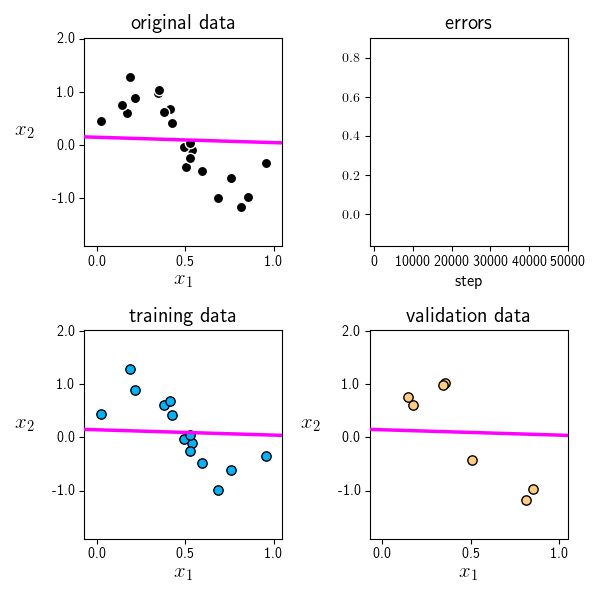
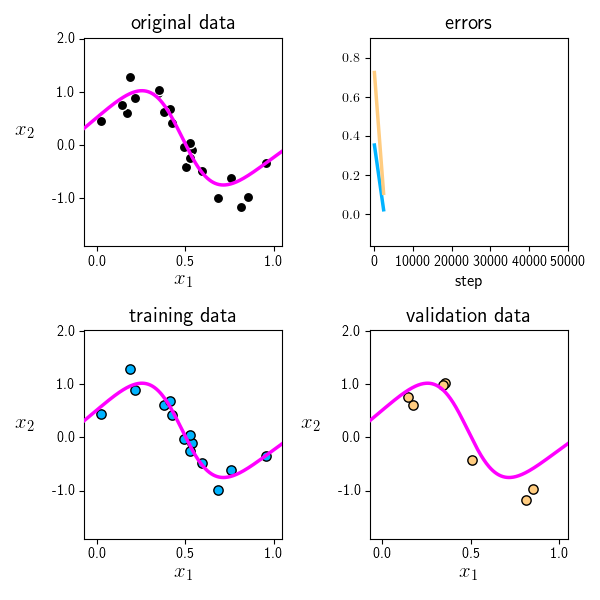
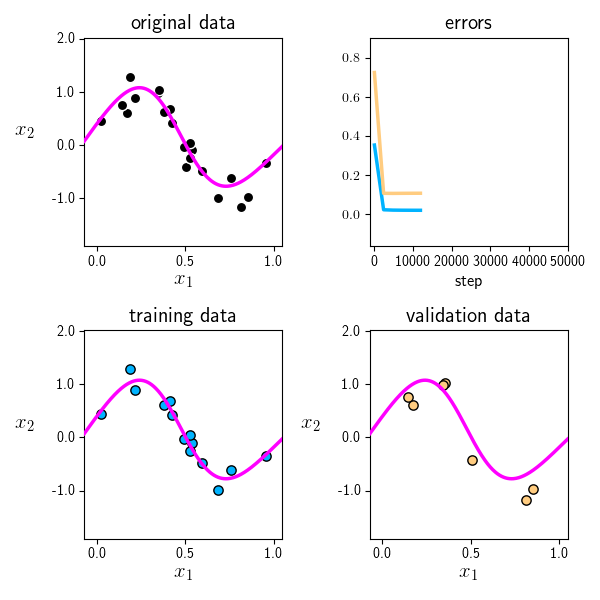
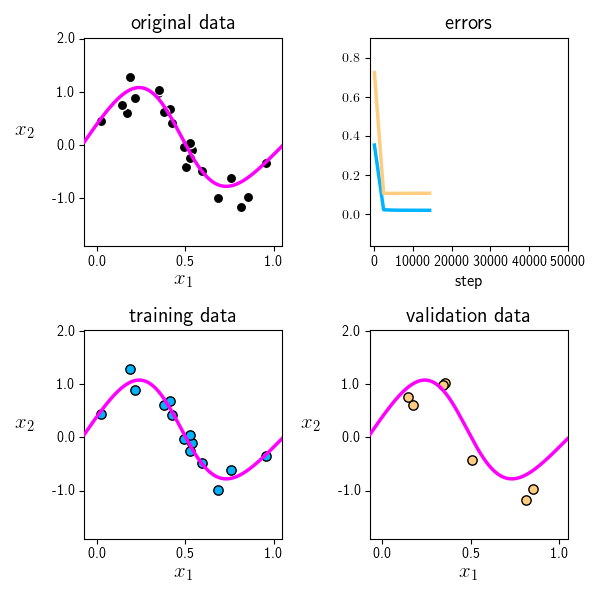
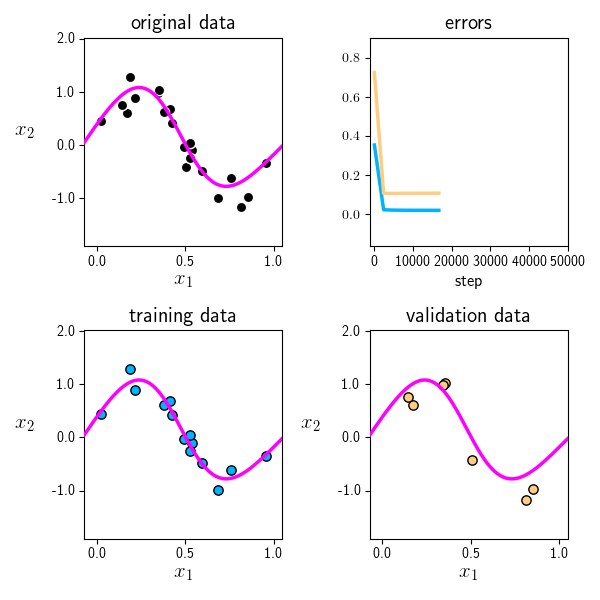
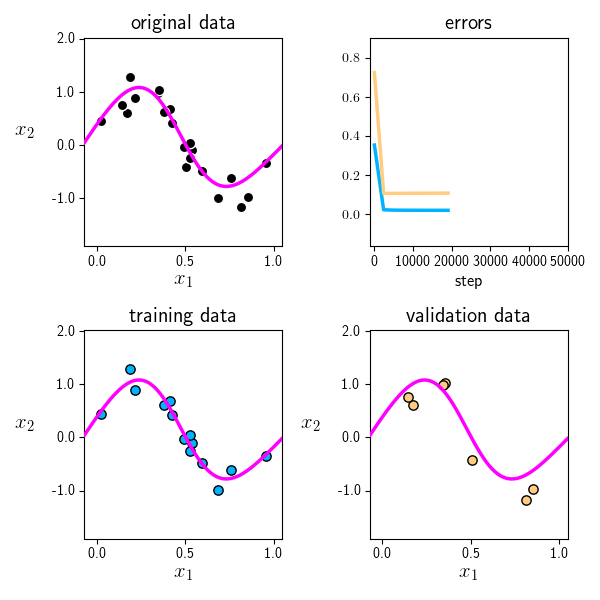
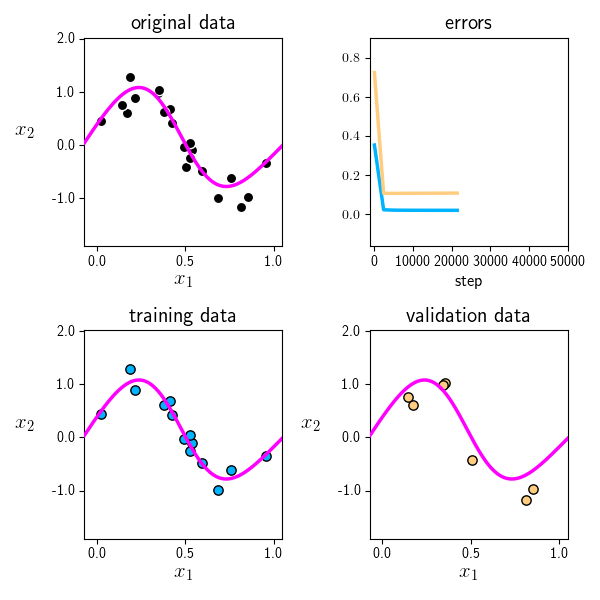
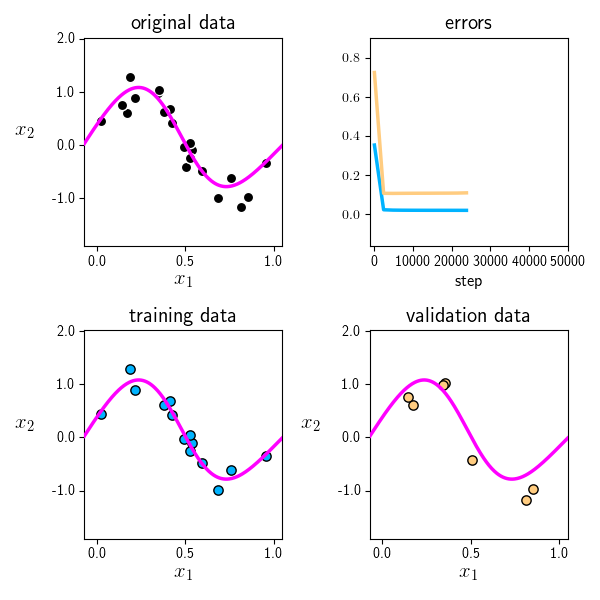
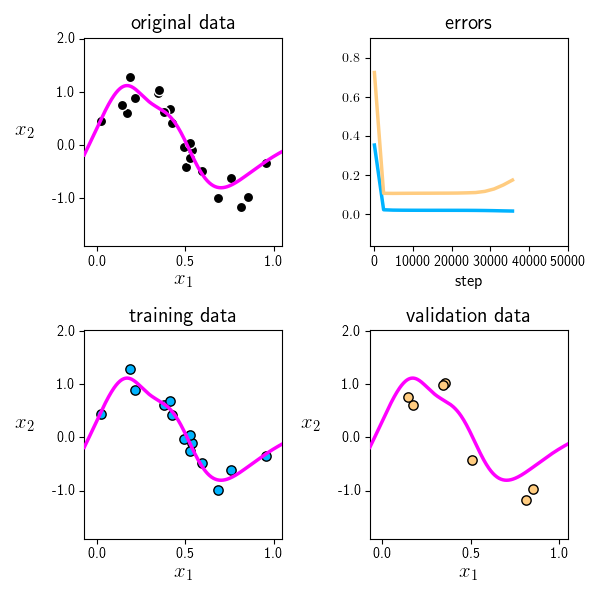
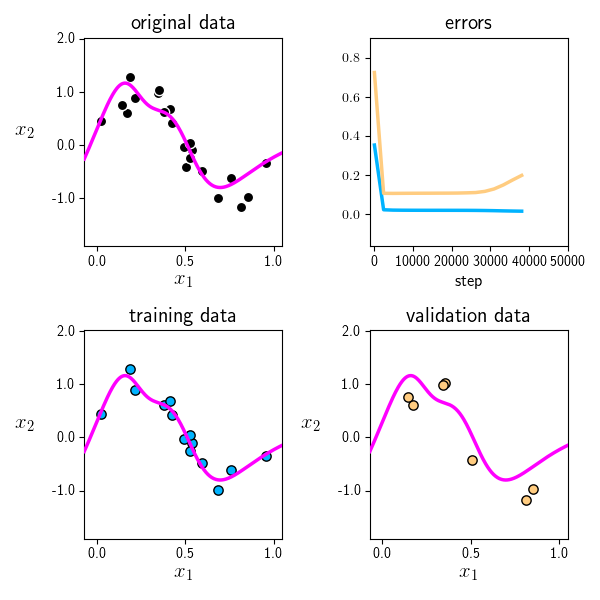
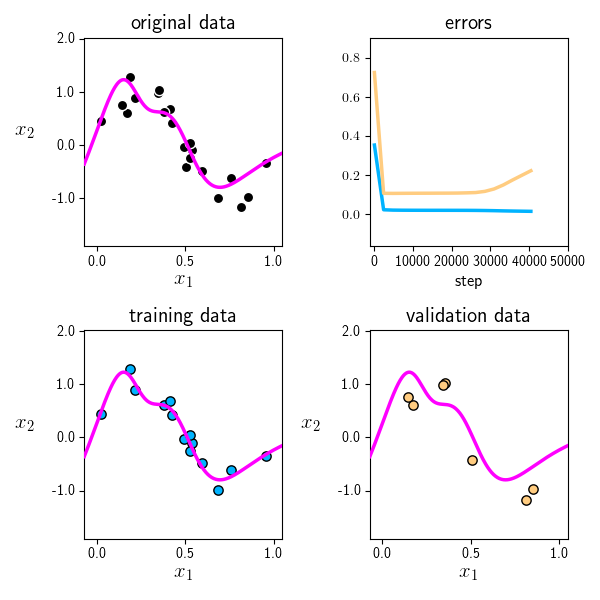
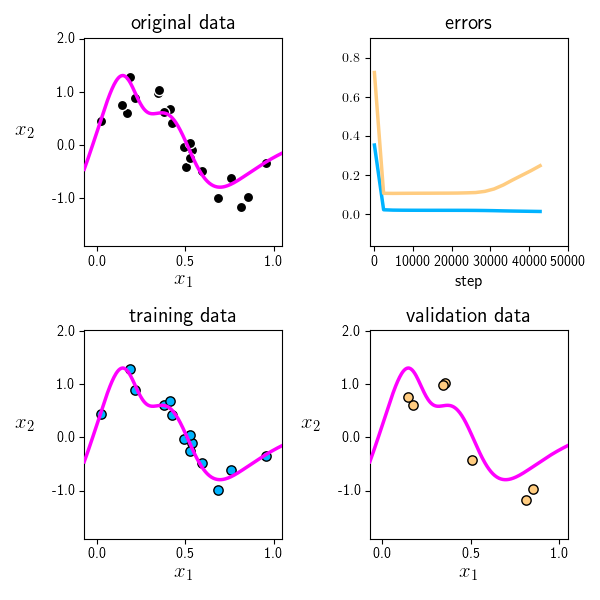
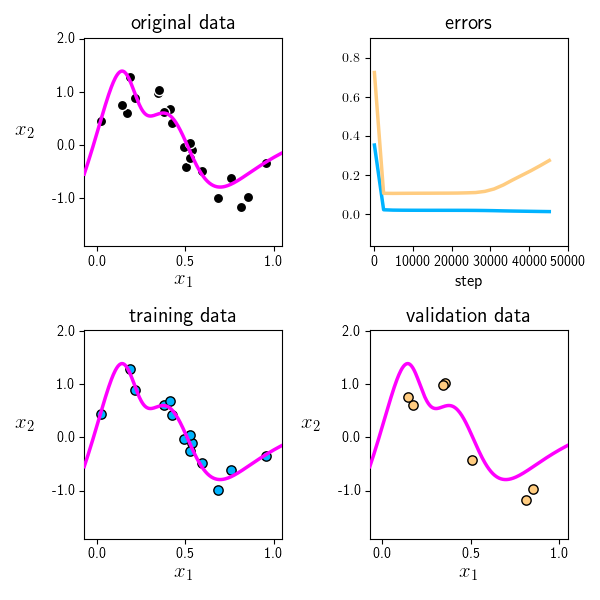
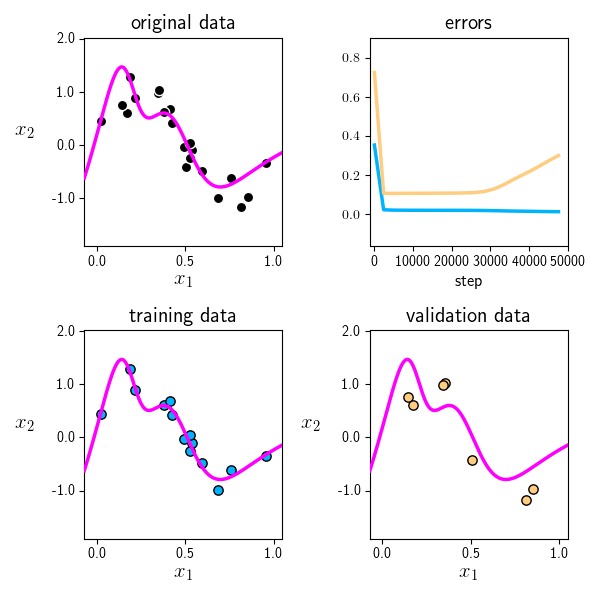

In [20]:
## This code cell will not be shown in the HTML version of this notebook
# load in dataset
csvname = datapath + 'noisy_sin_sample.csv'
data = np.loadtxt(csvname,delimiter = ',')
x = data[:-1,:]
y = data[-1:,:] 

# show data
demo1 = regress_plotter.Visualizer(data)
# demo1.plot_data()

# import the v1 library
mylib0 = nonlib.early_stop_lib.superlearn_setup.Setup(x,y)

# choose features
layer_sizes = [1,10,1]

# choose features
mylib0.choose_features(name = 'multilayer_perceptron',layer_sizes = layer_sizes,activation = 'tanh')

# choose normalizer
mylib0.choose_normalizer(name = 'standard')

# split into training and testing sets
mylib0.make_train_valid_split(train_portion = 0.66)

# choose cost
mylib0.choose_cost(name = 'least_squares')

# fit an optimization
mylib0.fit(max_its = 50000,alpha_choice = 10**(-1))

# animate the business
frames = 20
demo1 = nonlib.early_stop_regression_animator.Visualizer(csvname)
demo1.animate_trainval_earlystop(mylib0,frames,show_history = True)

#### <span style="color:#a50e3e;">Example 2. </span>  Early stopping of a prototypical classification dataset

Below we plot a prototypical nonlinear classification dataset.  We will use early stopping regularization to fine tune the capacity of a `model` consisting of $5$ single hidden layer `tanh` neural network universal approximators.

Below we illustrate a large number of gradient descent steps to tune our high capacity model for this dataset.  As you move the slider left to right you can see the resulting fit at each highlighted step of the run in the original dataset (top left), training (bottom left), and validation data (bottom right).  Moving the slider to where the validation error is lowest provides - for this training / validation split of the original data - a fine nonlinear model for the entire dataset.


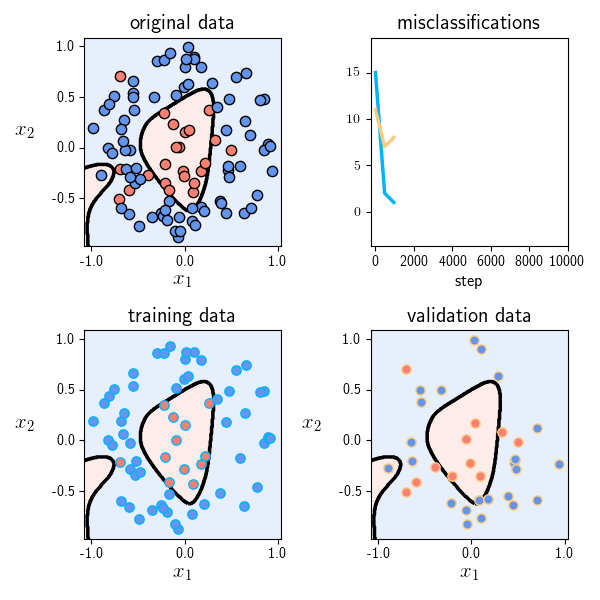
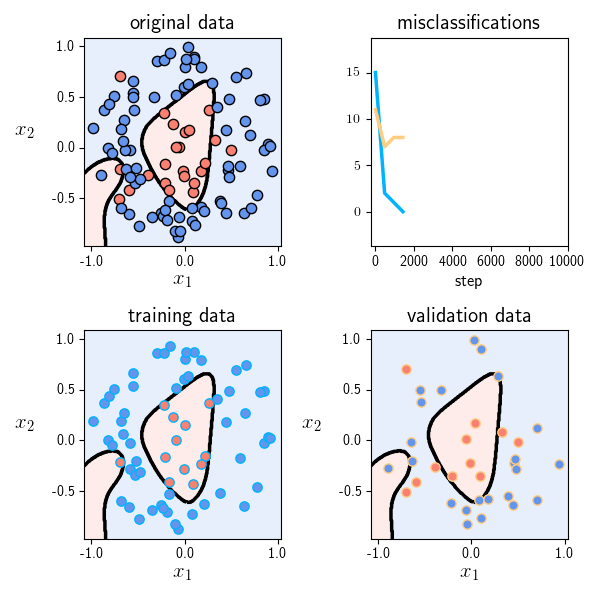
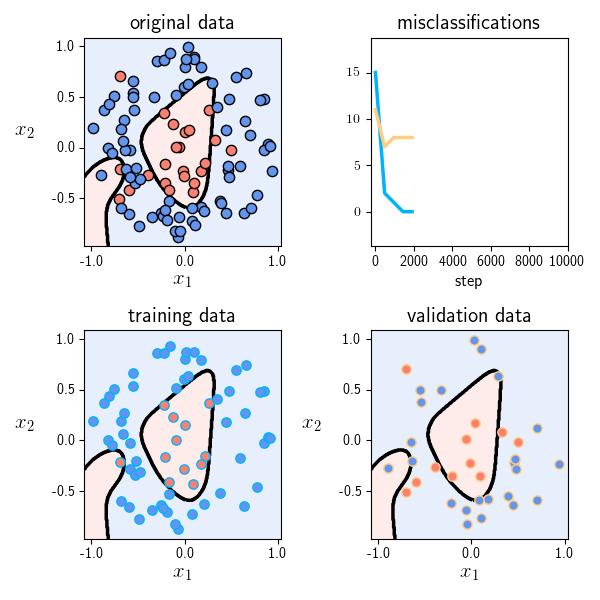
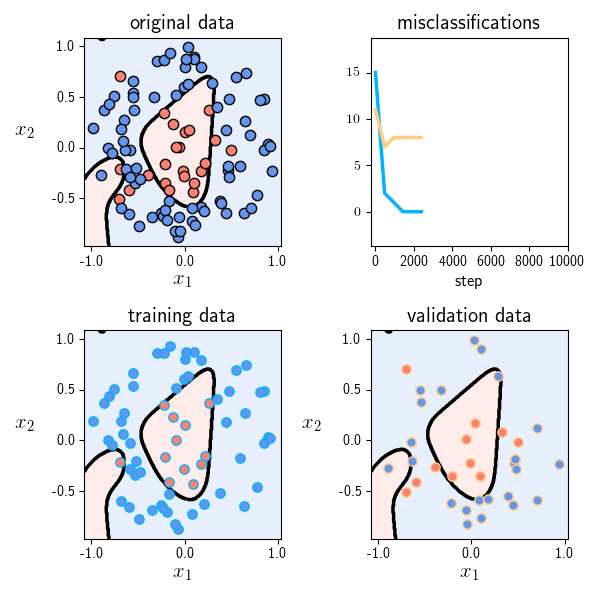
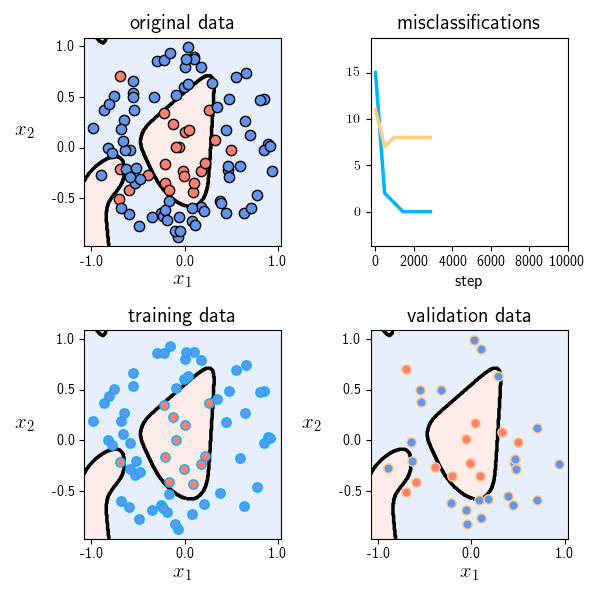
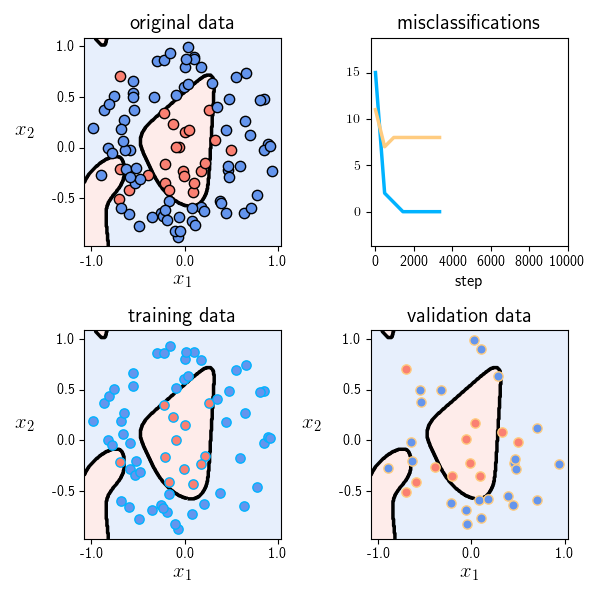
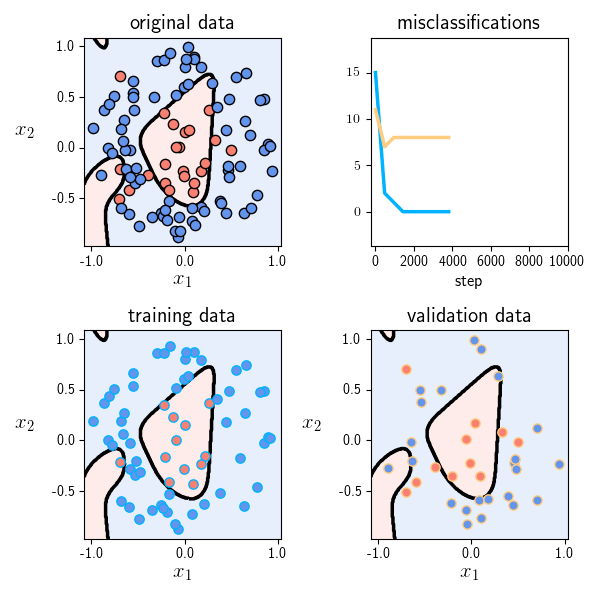
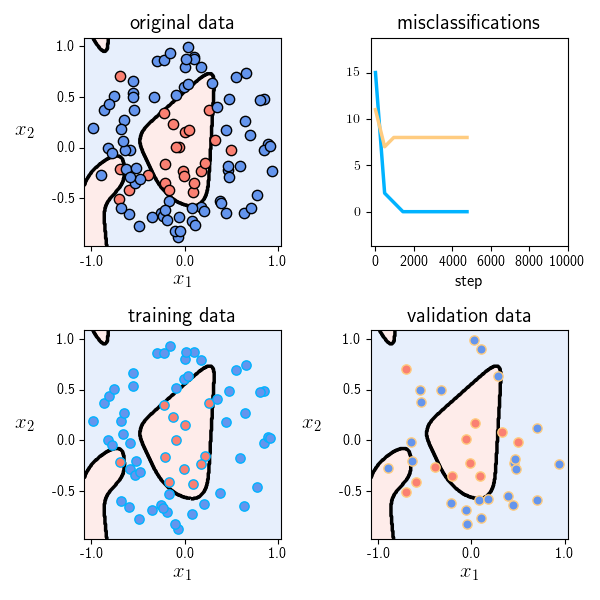
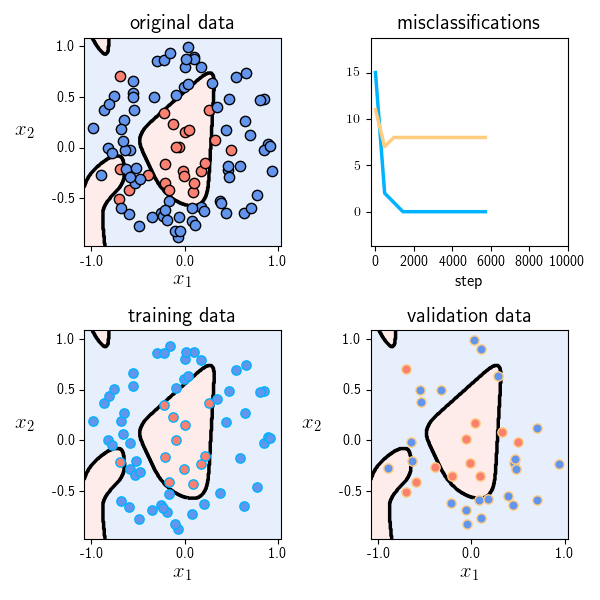
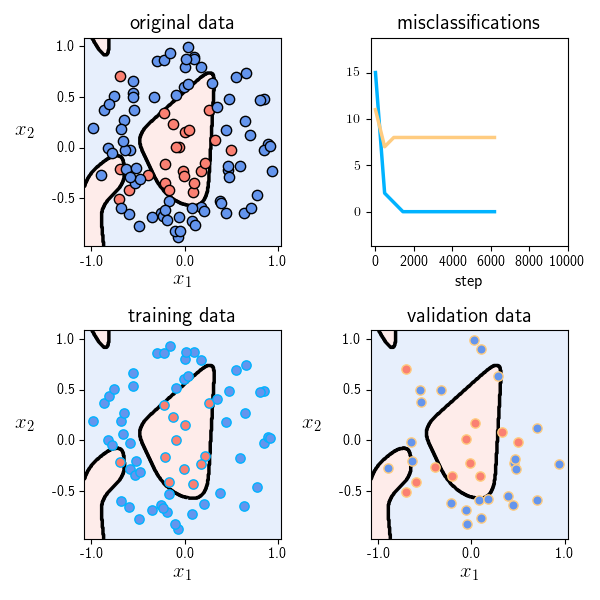
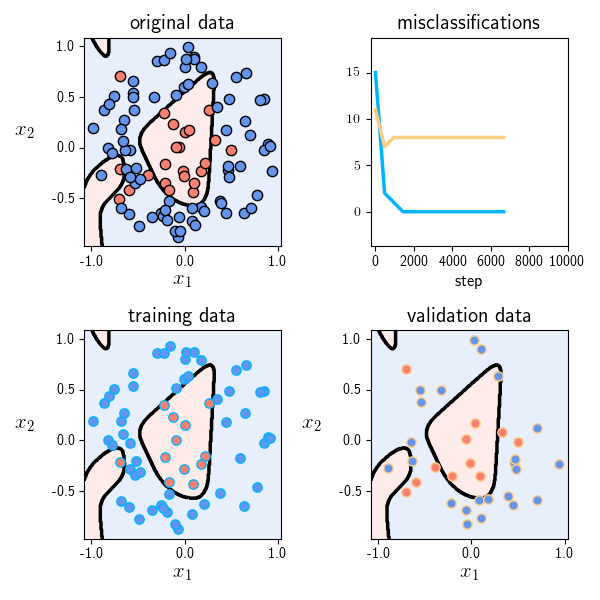
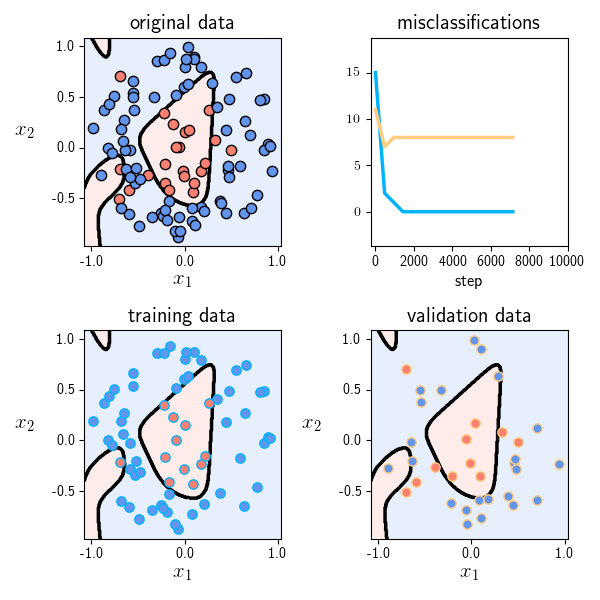
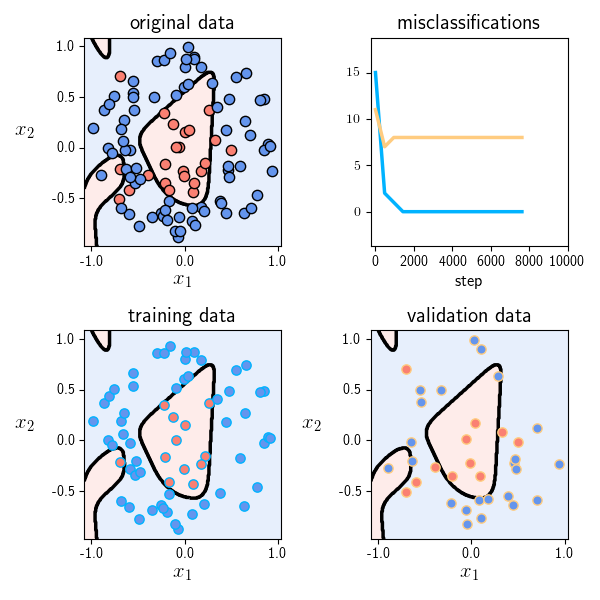

In [25]:
# This code cell will not be shown in the HTML version of this notebook
# load in dataset
csvname = datapath + 'new_circle_data.csv'

data = np.loadtxt(csvname,delimiter = ',')
x = data[:-1,:]
y = data[-1:,:] 

demo2 = classif_plotter.Visualizer(csvname)
# demo2.plot_data();

name = datapath + 'early_stopping_weights.p'
init_weights = pickle.load( open(name, "rb" ) )

name = datapath + 'early_stop_test_data.p'
test_data = pickle.load( open(name, "rb" ) )
x_valid =  test_data[:-1,:]
y_valid = test_data[-1:,:] 

name = datapath + 'early_stop_train_data.p'
train_data = pickle.load( open(name, "rb" ) )
x_train =  train_data[:-1,:]
y_train = train_data[-1:,:] 

# load in data
csvname = datapath + 'small_circle_data.csv'

data = np.loadtxt(csvname,delimiter = ',')
x = data[:-1,:]
y = data[-1:,:] 

# import the v1 library
mylib1 = nonlib.early_stop_lib.superlearn_setup.Setup(x,y)

# choose features
layer_sizes = [2,5,1]

# choose features
mylib1.choose_features(name = 'multilayer_perceptron',layer_sizes = layer_sizes,activation = 'tanh')

# choose normalizer
mylib1.choose_normalizer(name = 'standard')

# split into training and testing sets
mylib1.make_train_valid_split(train_portion = 0.66)

# put in saved data
mylib1.x_train = x_train
mylib1.y_train = y_train
mylib1.x_valid = x_valid
mylib1.y_valid = y_valid

# choose cost
mylib1.choose_cost(name = 'softmax',init = init_weights)

# fit an optimization
mylib1.fit(max_its = 10000,alpha_choice = 10**(0))#,init = favorite_color)

# plot cost history
#mylib1.show_histories(start = 0)

# load up animator
demo3 = nonlib.early_stop_classification_animator.Visualizer(csvname)

# animate based on the sample weight history
frames = 20
demo3.animate_trainval_earlystop(mylib1,frames)

## 11.4.4  Adding a regularizer to the cost

The overfitting problem is inherently tied to *completely minimizing the cost function* of a model with too much capacity for a given dataset.  The early-stopping idea presented above offers a simple solution to this problem - do not minimize this cost function too well, and in particular halt when validation error is at its lowest.  Doing this will prevent local optimization schemes from reaching points too close to the cost function's global mininma, and producing weights that cause overfitting to occur.  Obviously this is strongly optimization-view of overfitting prevention - which is common to most *regularization* techniques - since we are doing something to *avoid* the global minima of a cost function.

With early stopping we *halt optimization before reaching global minima*, with other regularization techniques we *change the location of a cost function's global minima so that even if we fully minimize it we do not recover a set of weights that produces overfitting*.  This is typically done by adding a simple function - called a *regularizer* - to the original cost function.  Doing this we change its shape, and in particular *change the location of its global minima*.  Since the global minima of the adjusted cost function do not align with those of the original cost, the adjusted cost can then be completely minimized with less fear of overfitting to the training data.   

This method of regularization is illustrated figuratively via the animation below.  In the left panel we show a prototypical single input cost function $g(w)$, in the middle panel is shown a simple function we will add to it (here a quadratic $w^2$) and in the right panel we show their linear combination $g(w) + \lambda w^2$.  As we increase $\lambda > 0$ (moving the slider left to right) notice how the cost's single global minimum - the minimum evaluation is shown as a red dot and the corresponding input $w$ is shown as a red 'x' - moves.  As more and more of the quadratic is added to the original cost function its minimum - shown as a green dot and corresponding input shown as a green 'x' - moves away from the original.


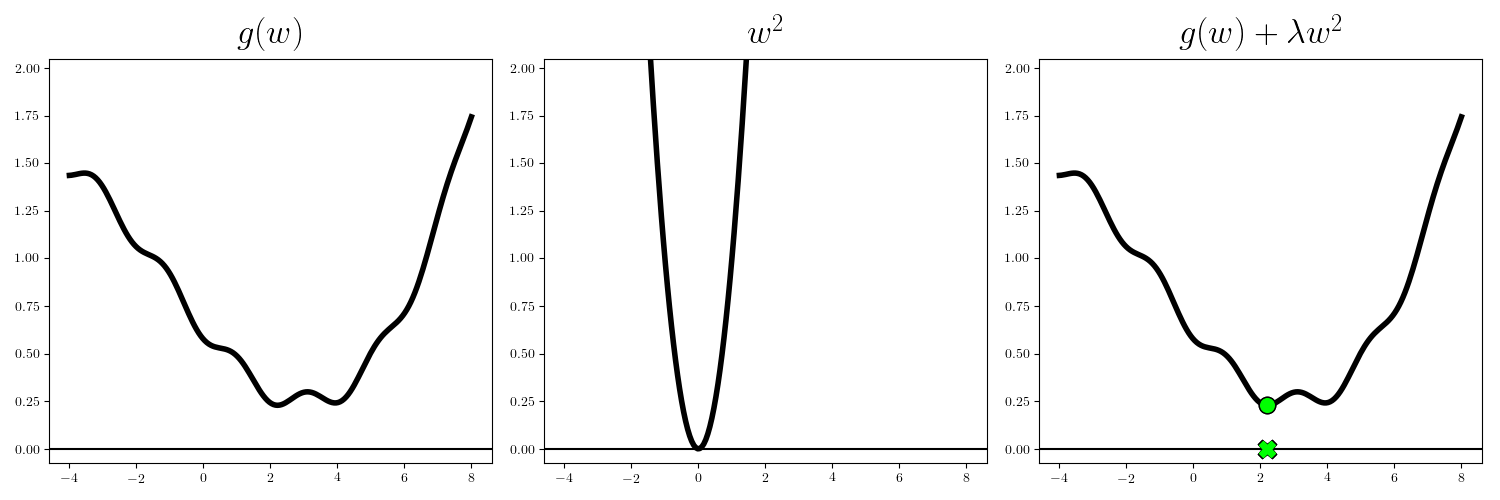
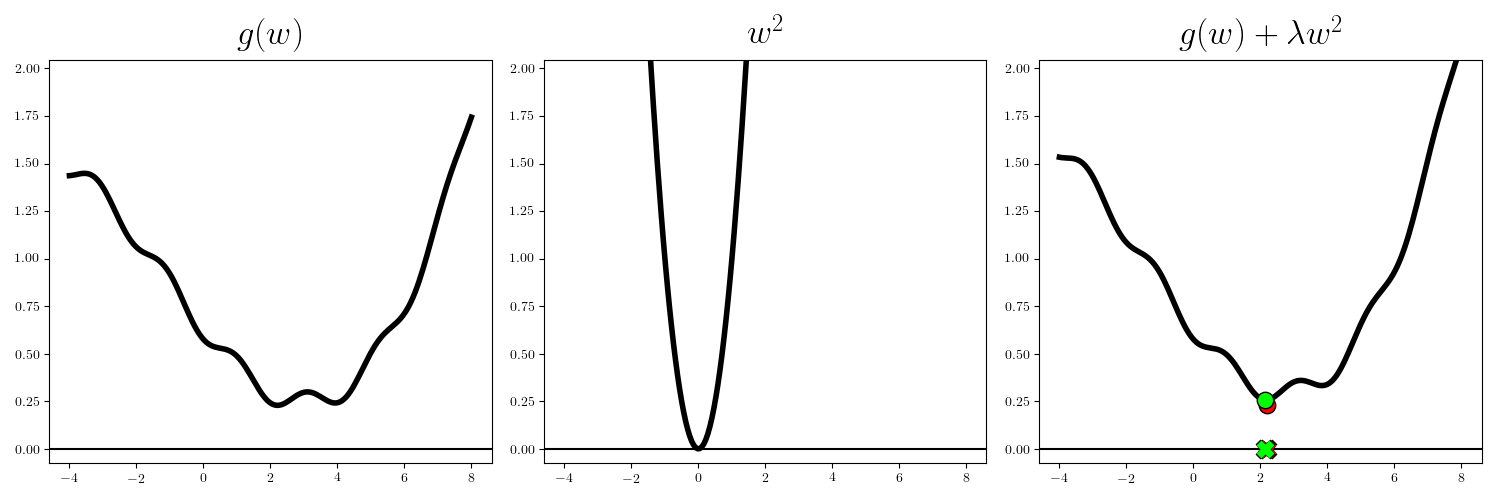
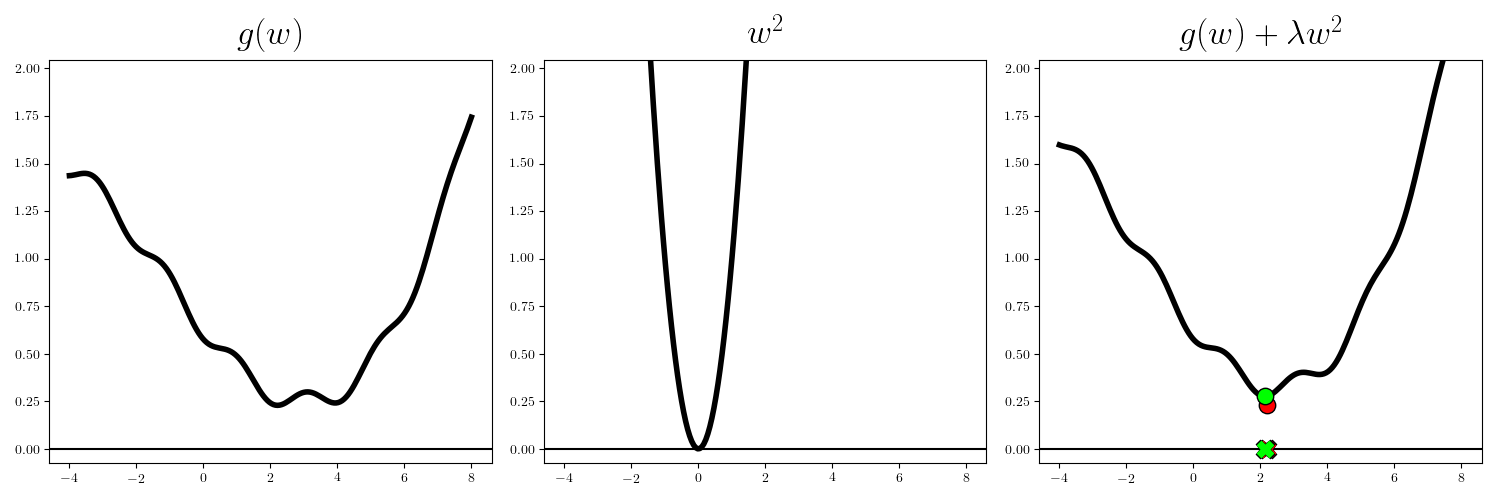
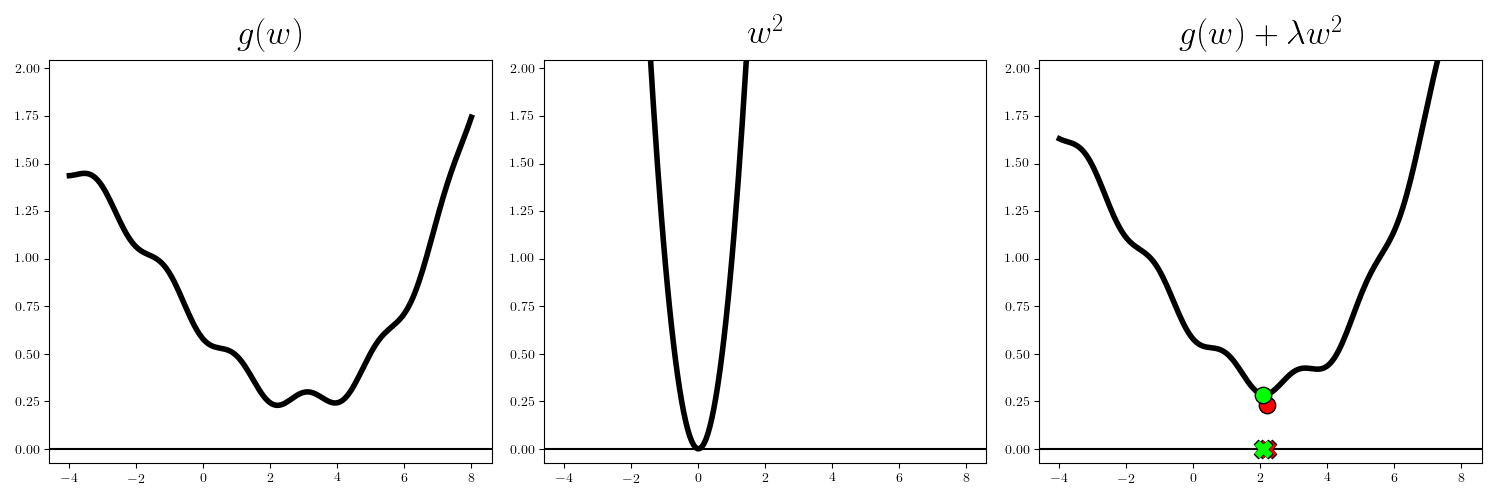
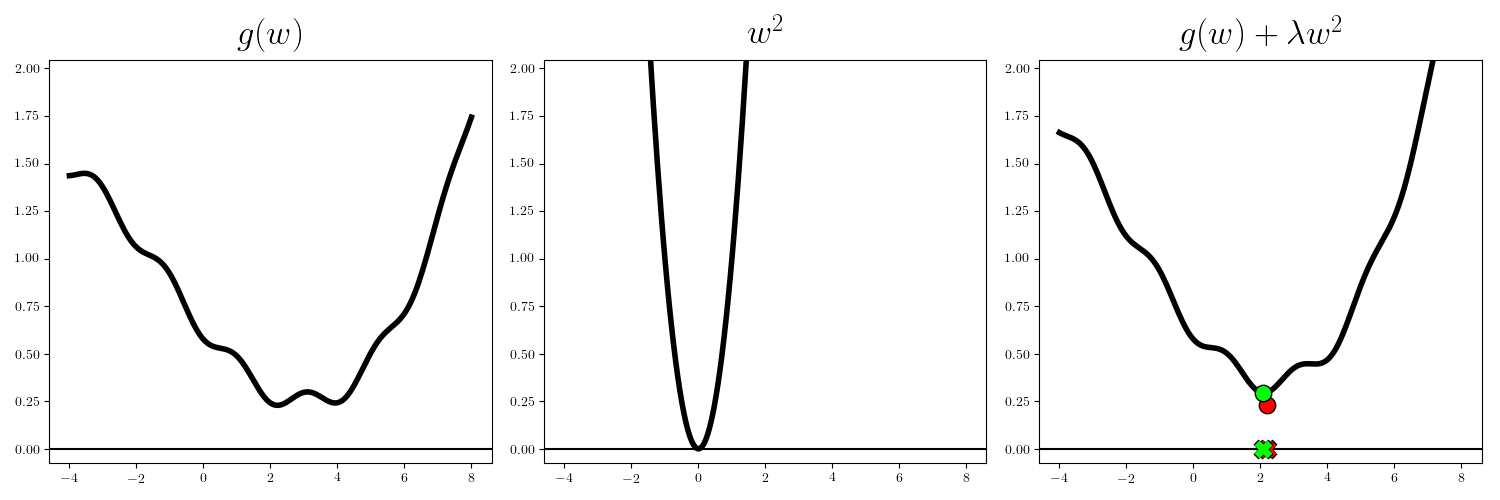
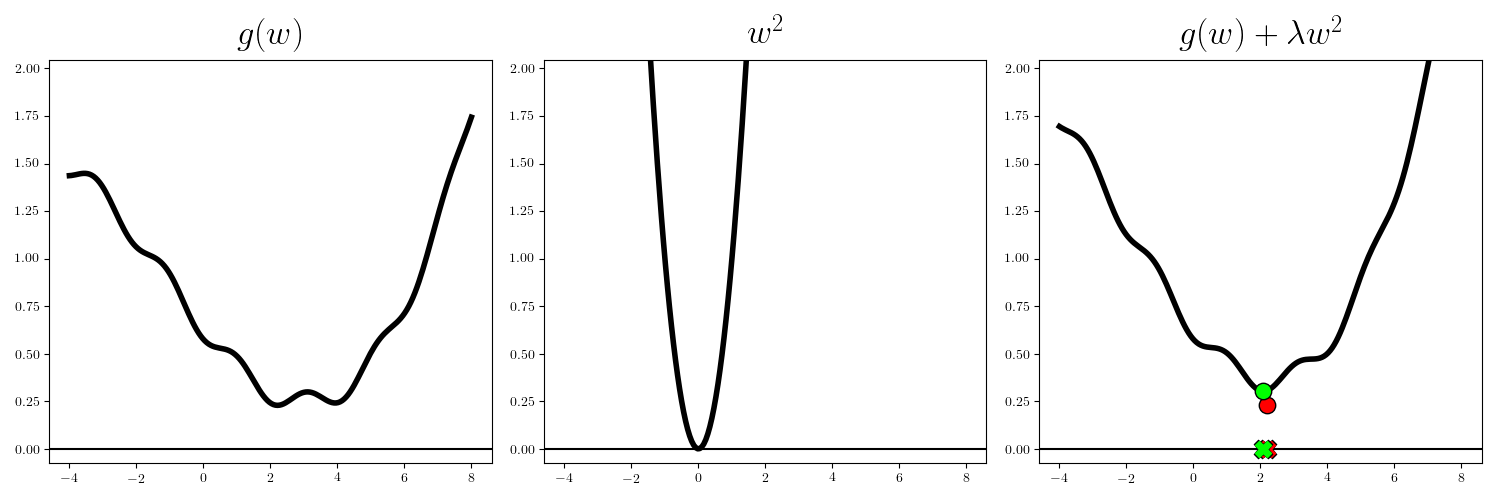
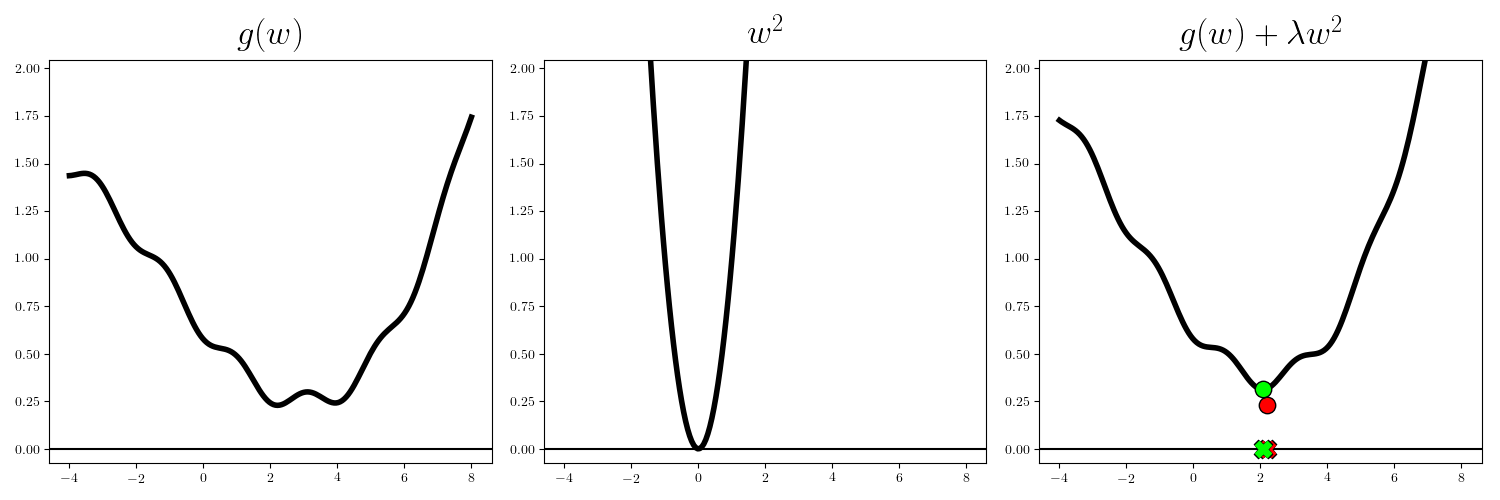
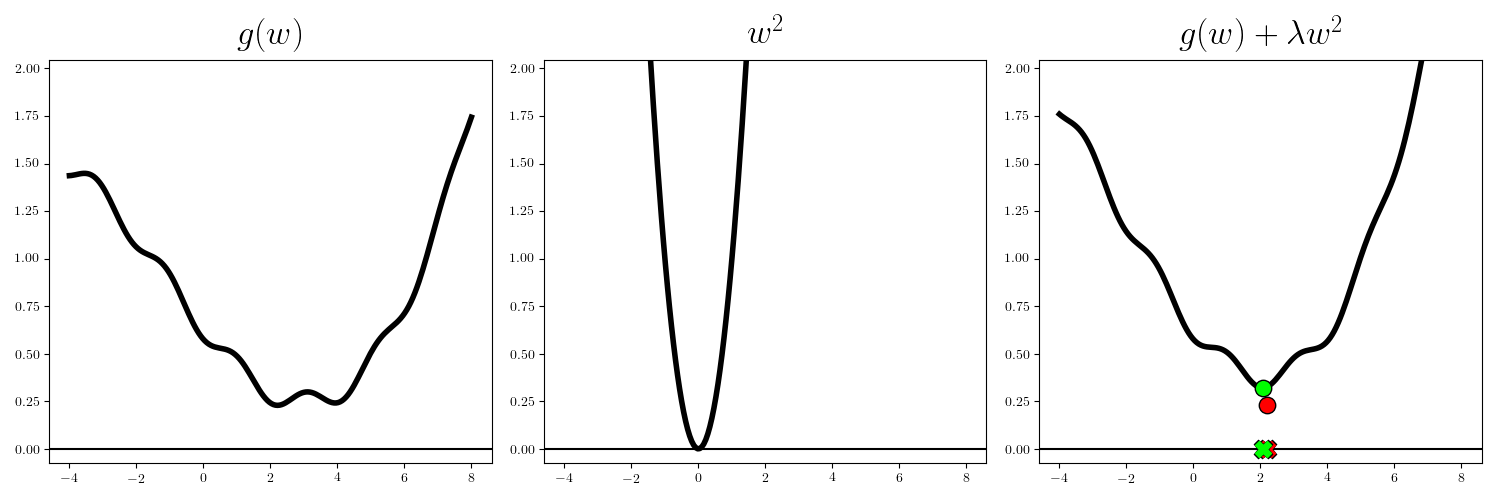
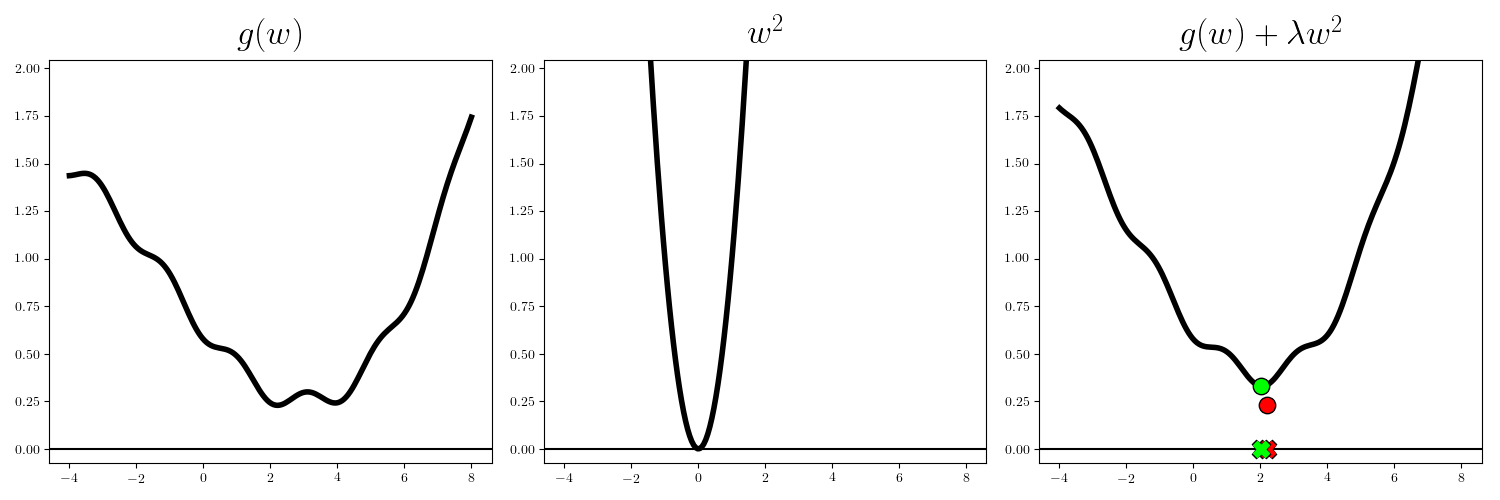
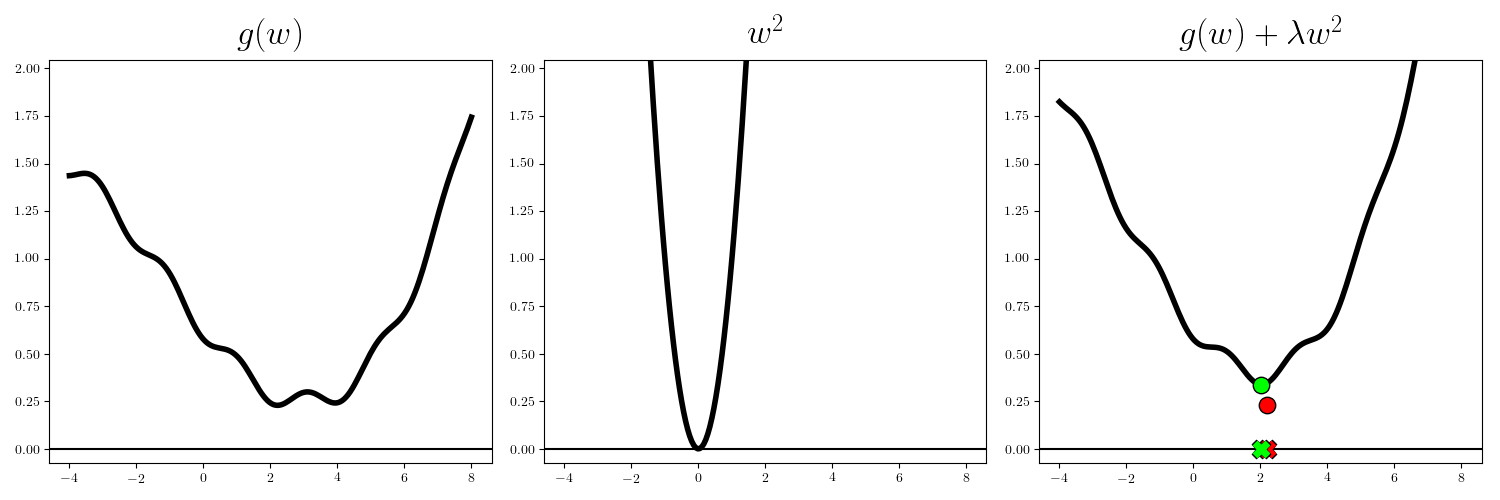
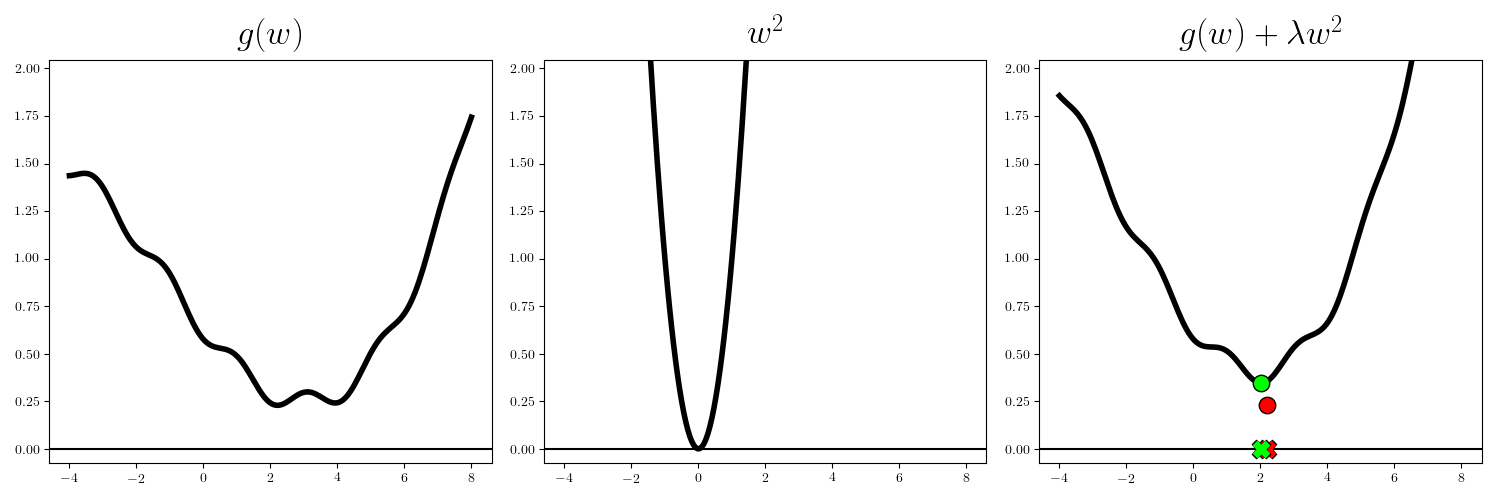
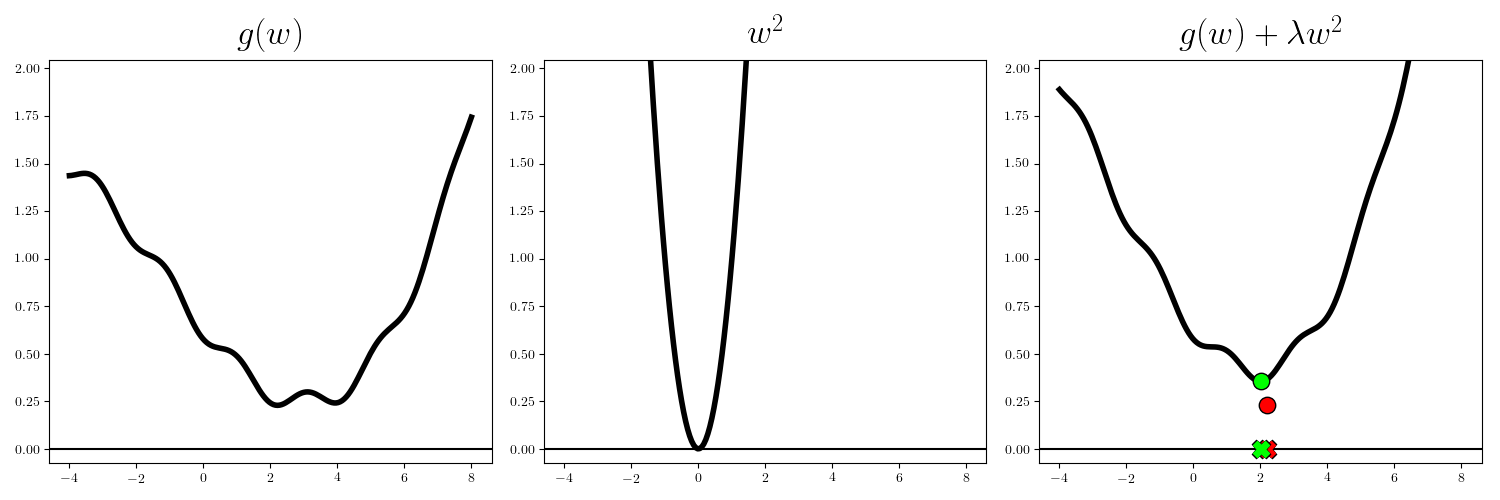
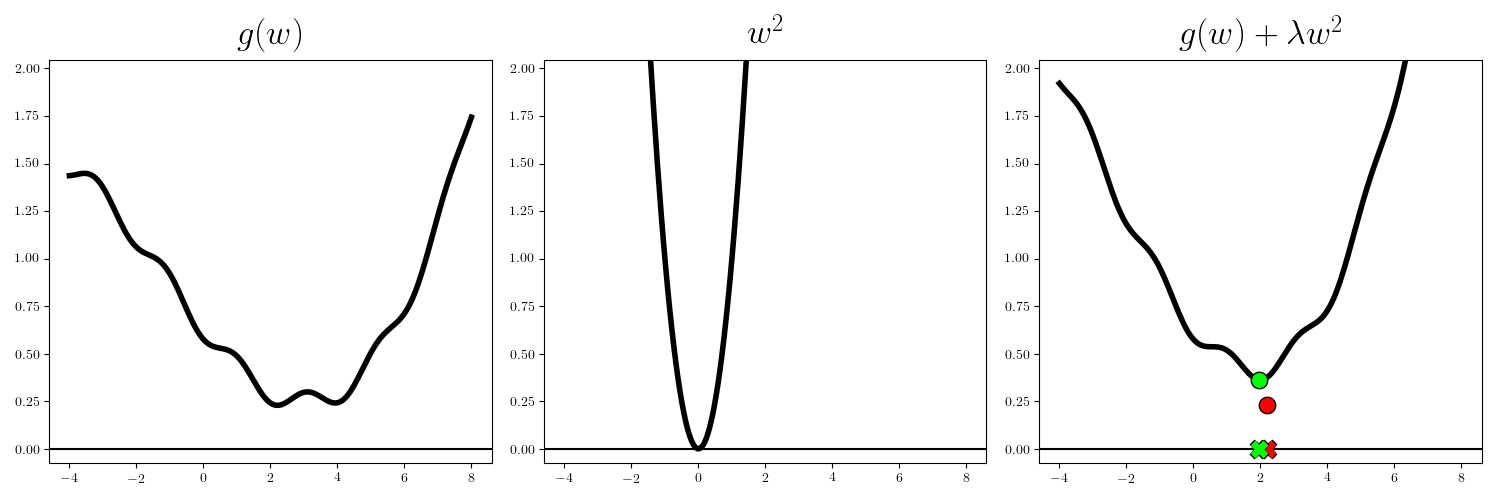
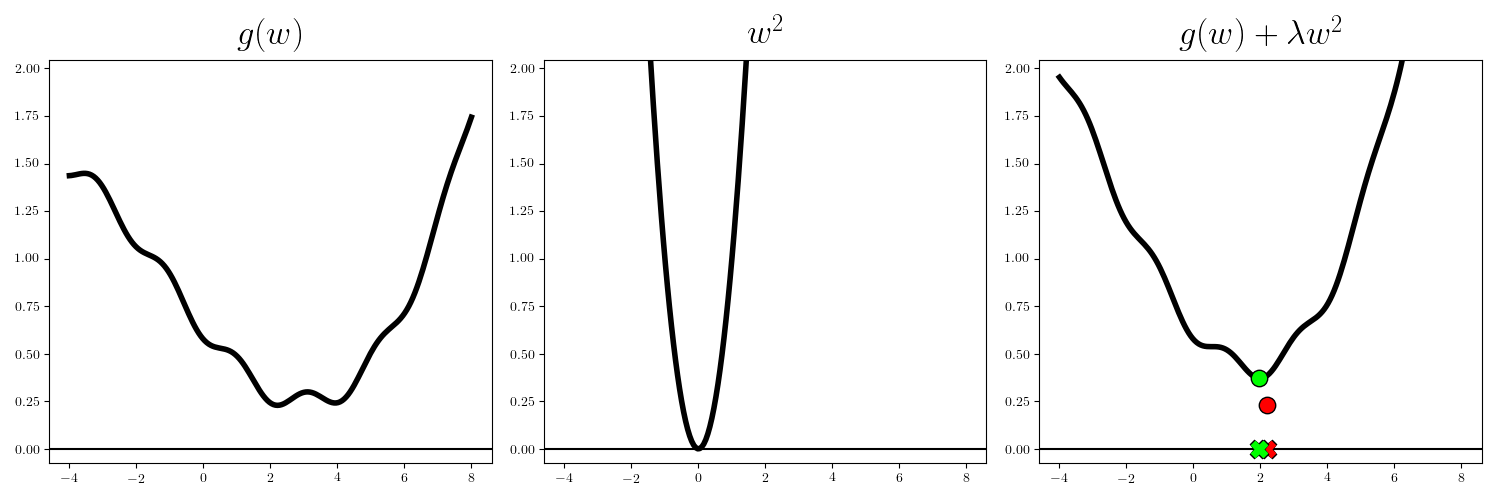
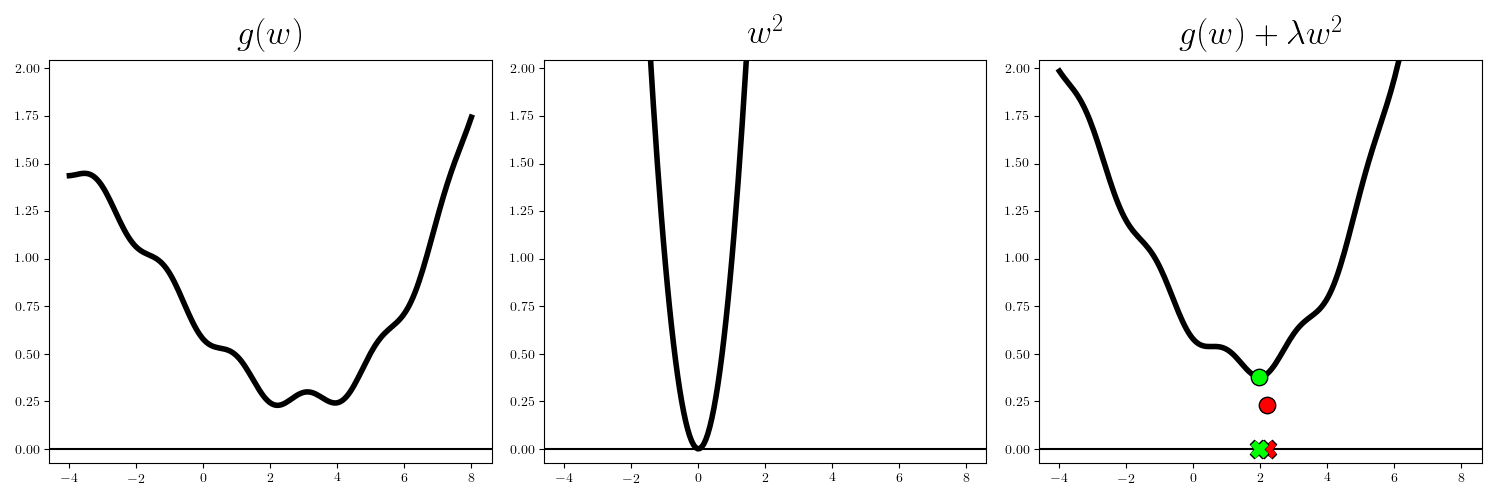
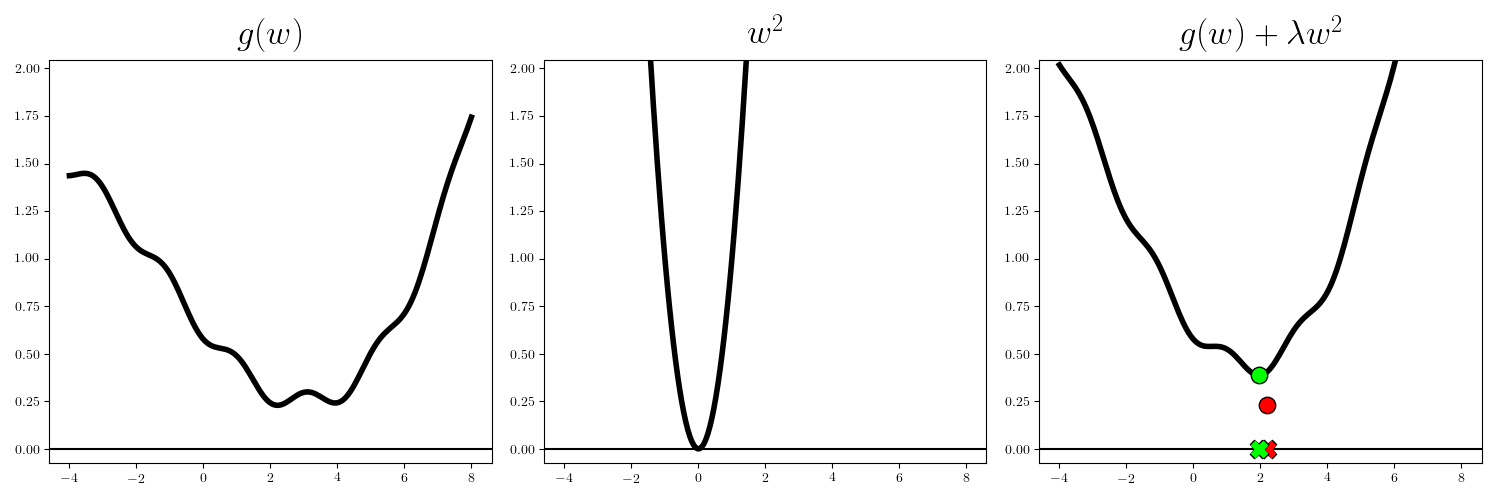
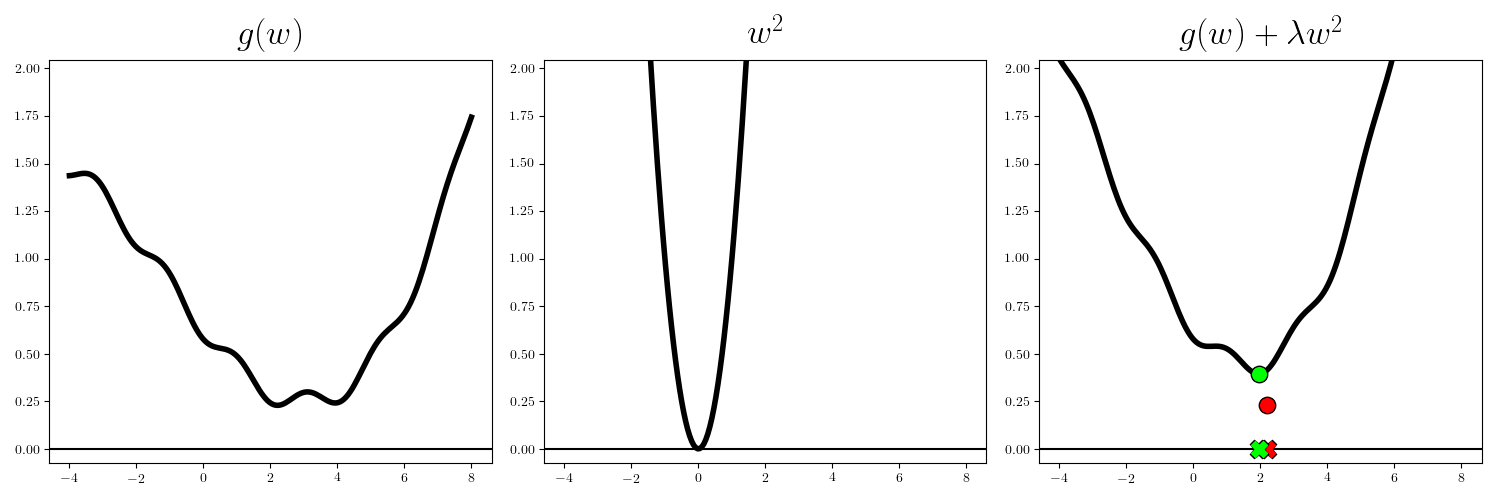
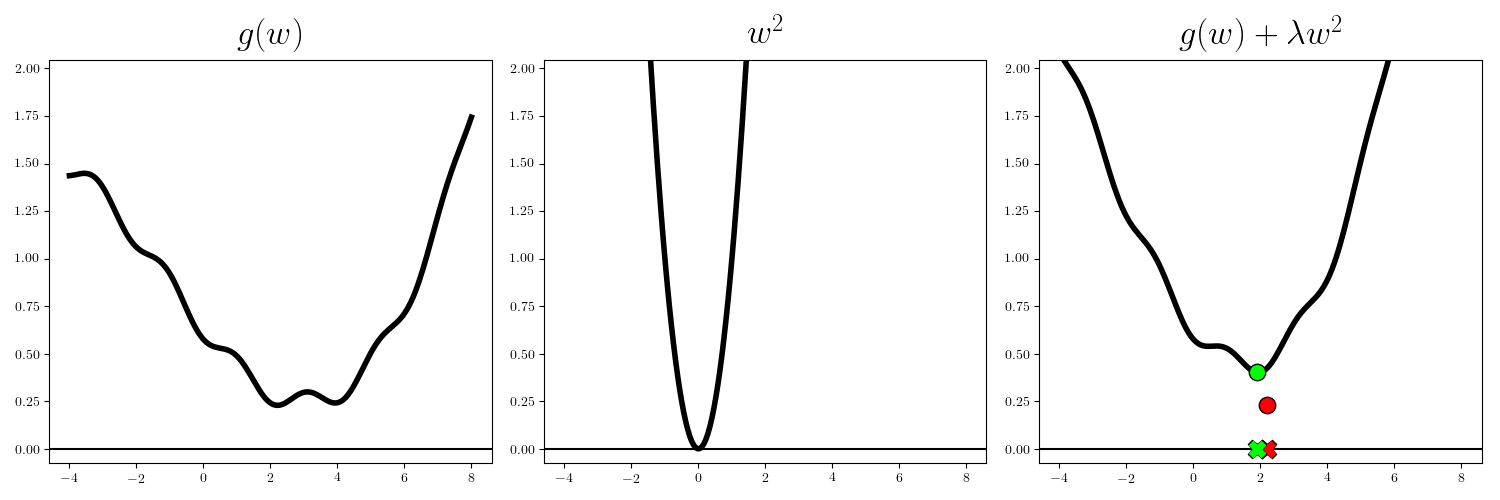
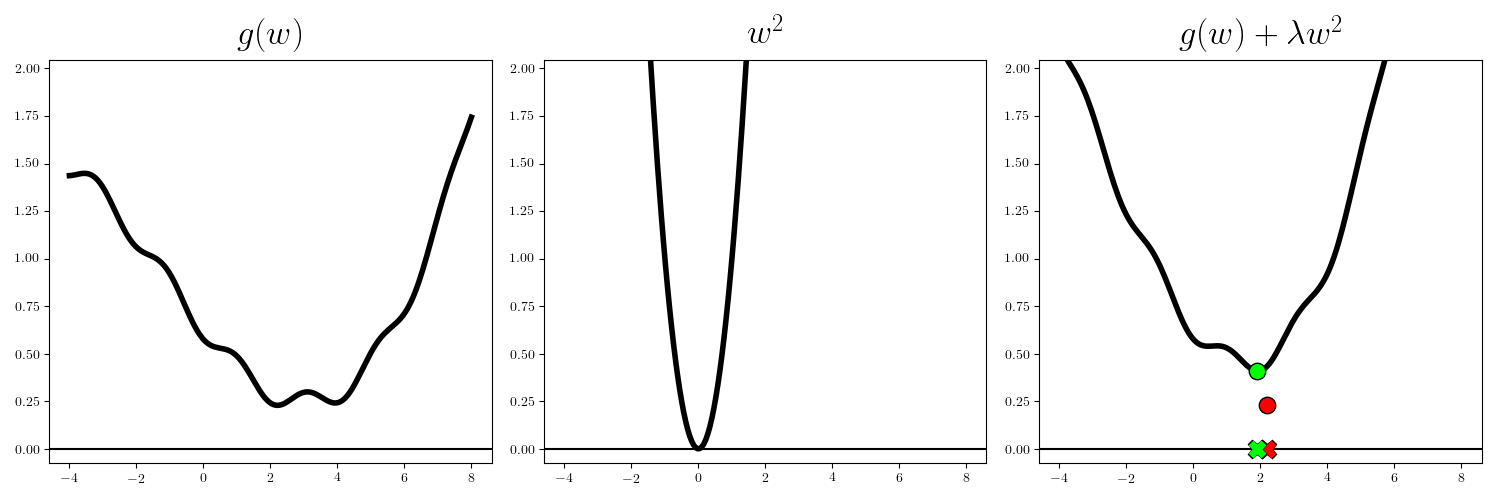
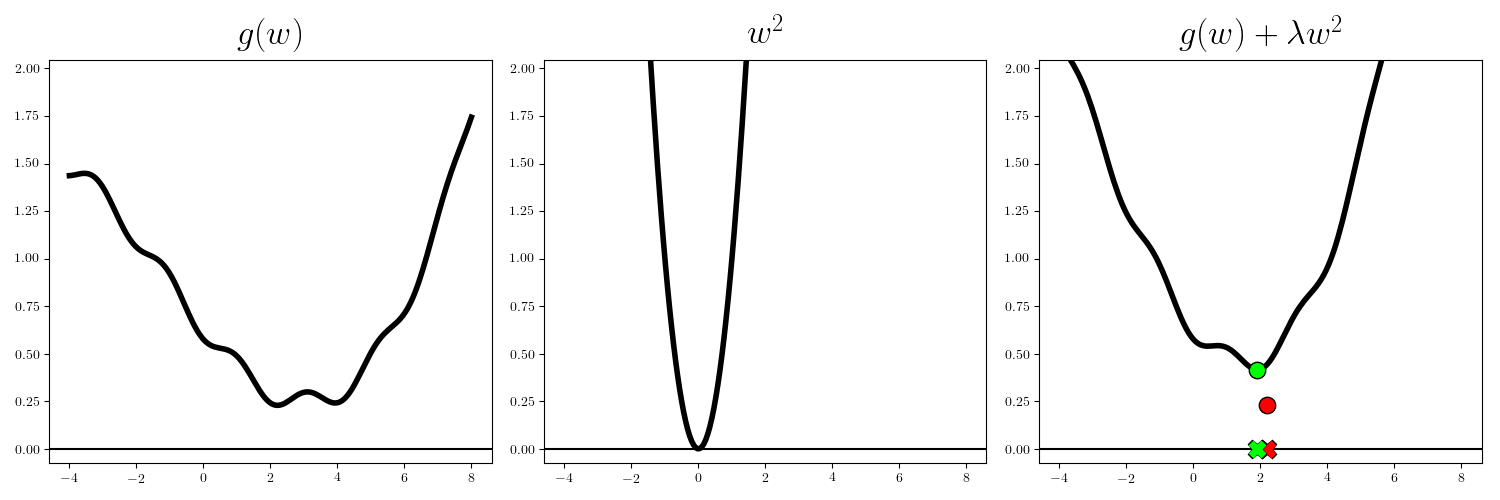
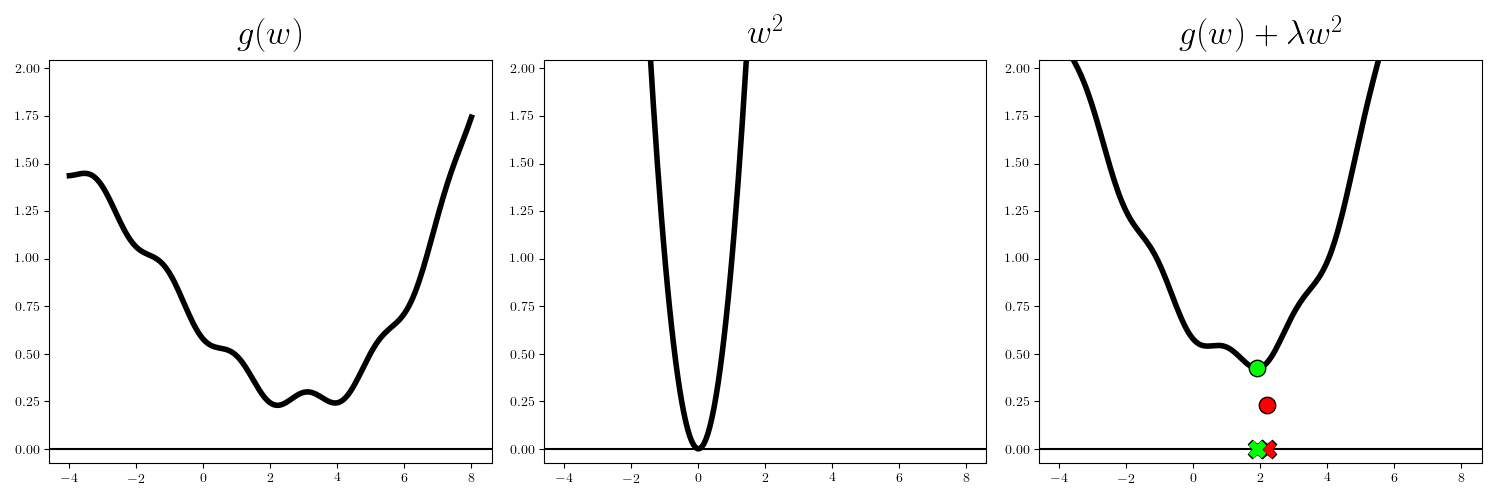
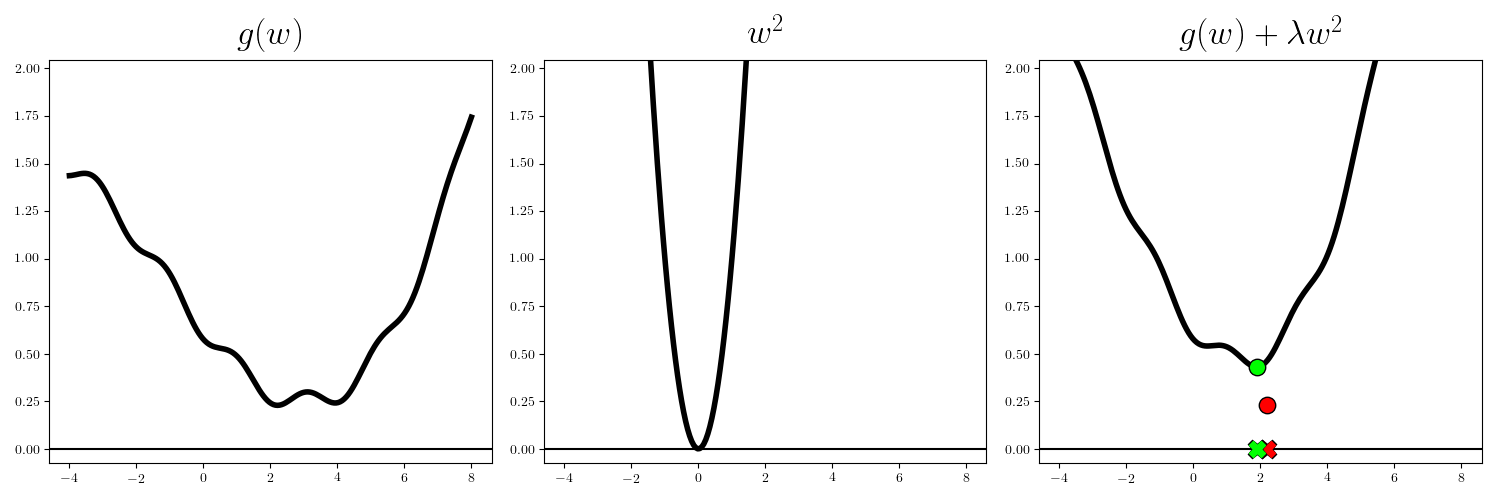
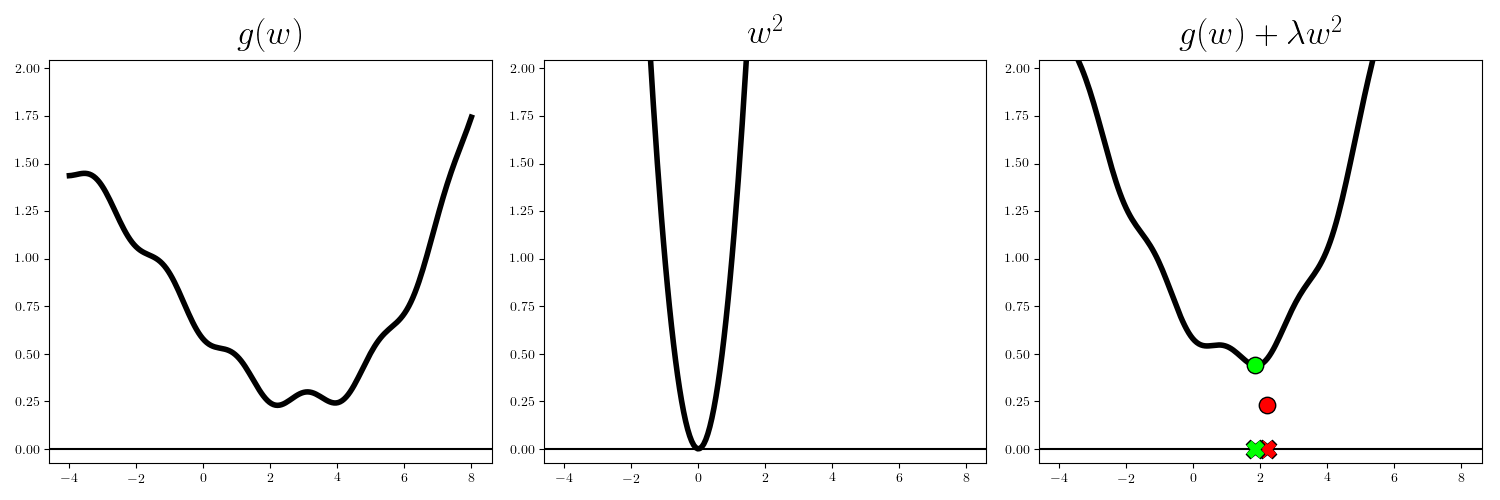
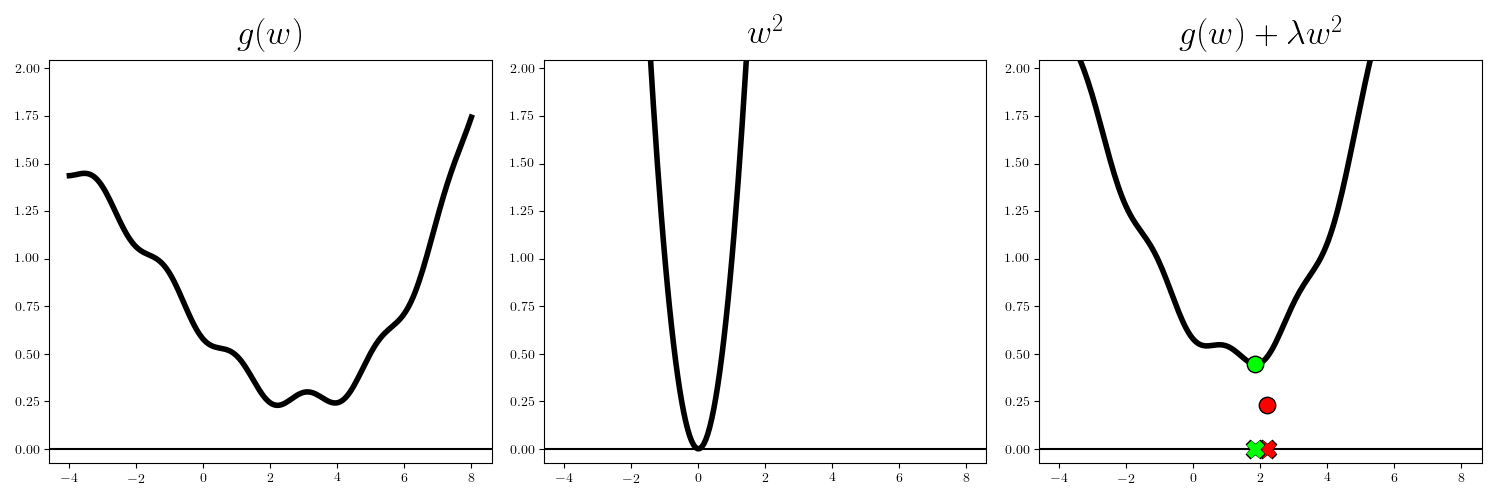
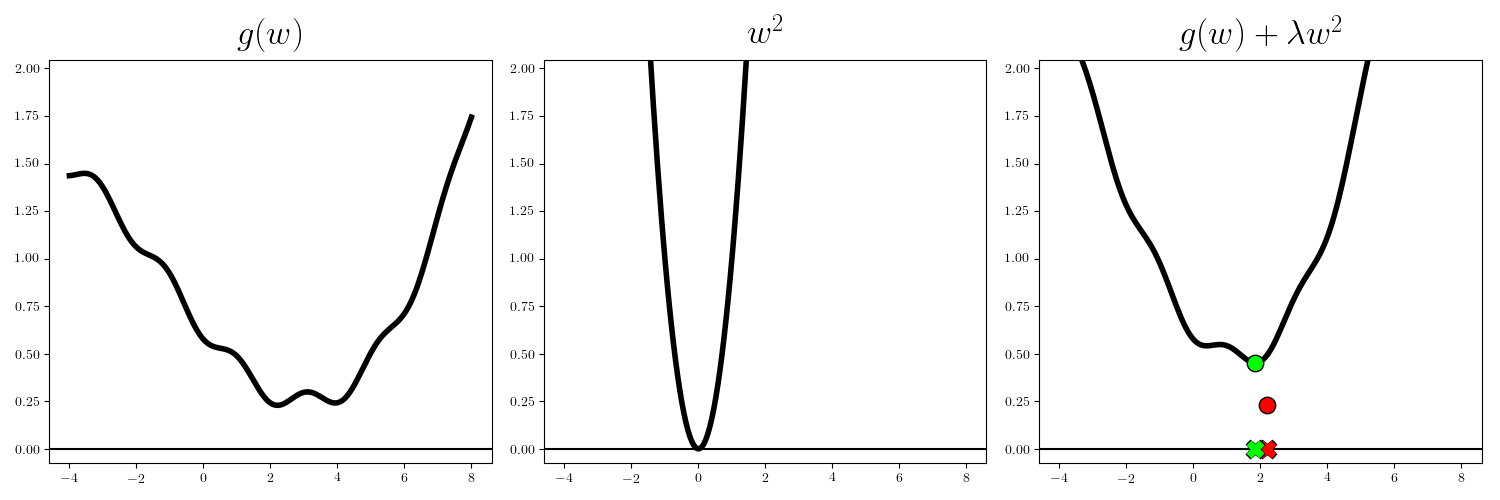
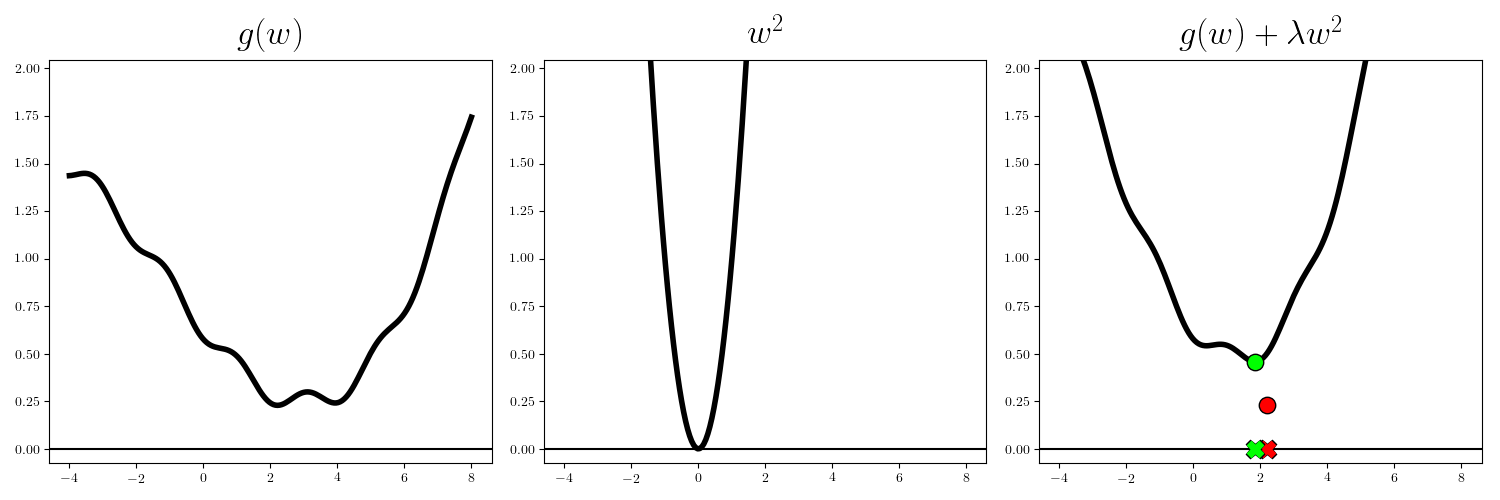
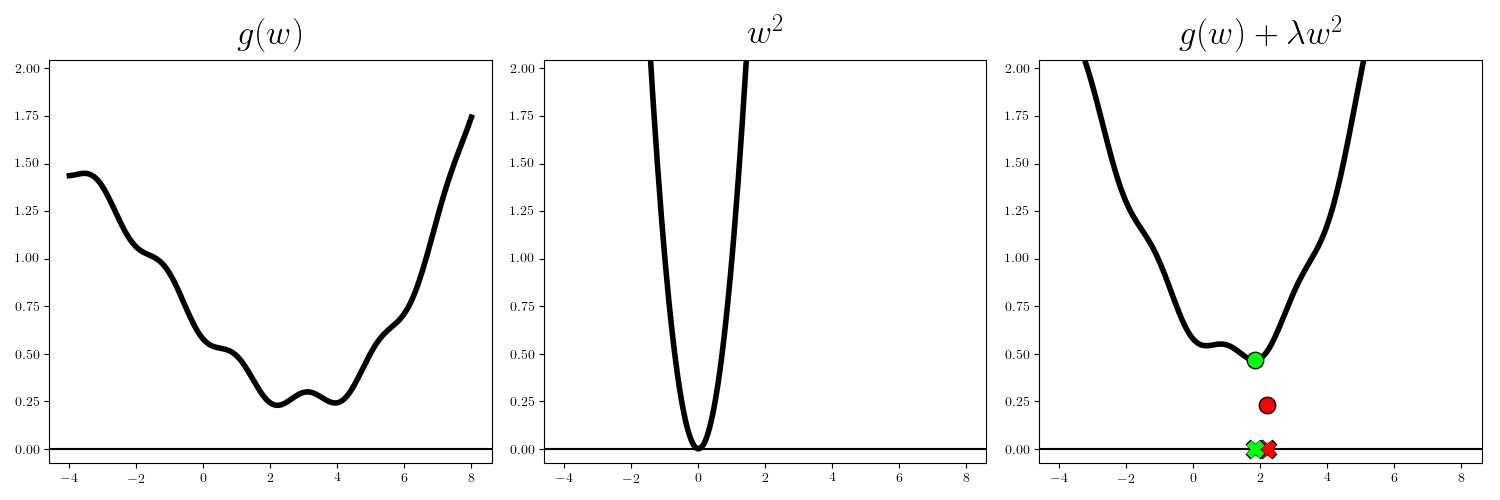
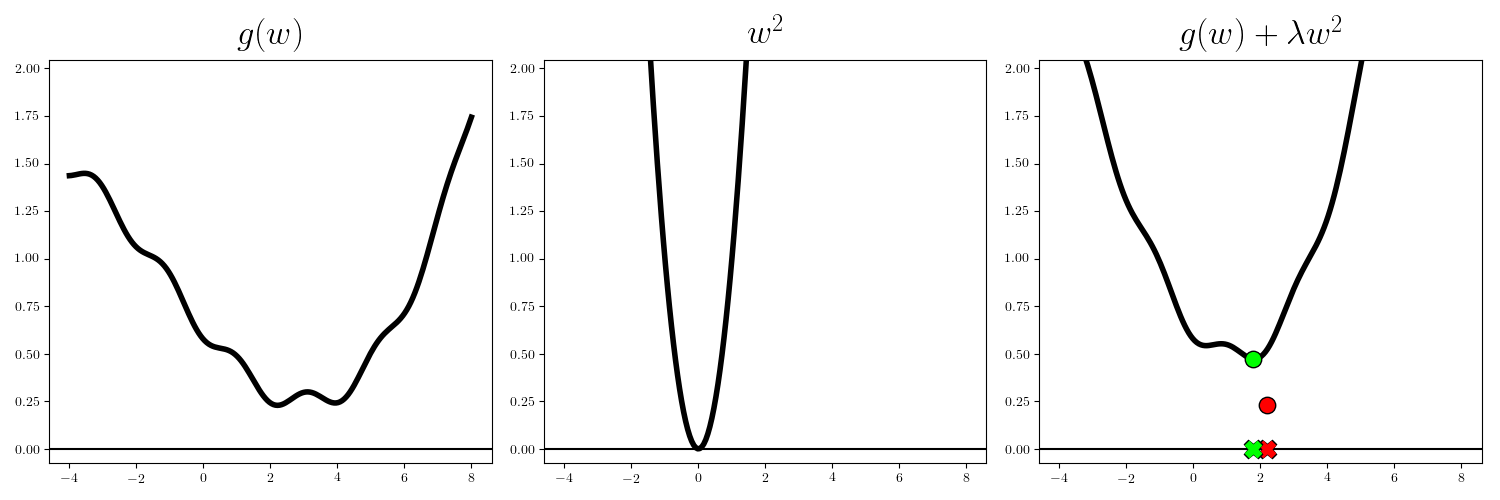
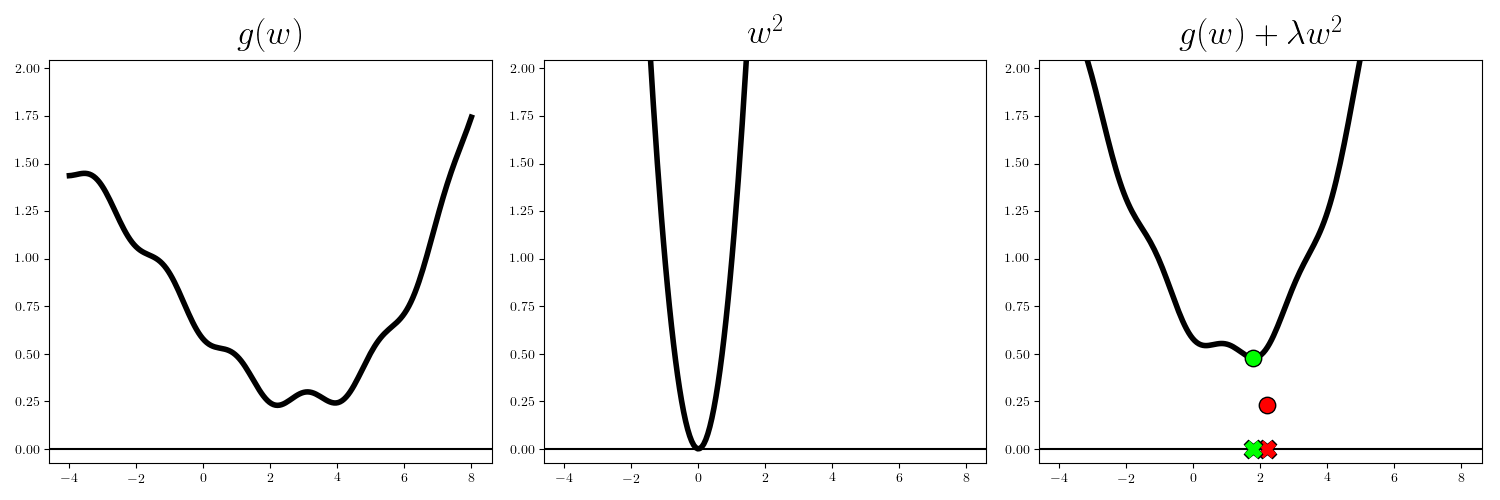
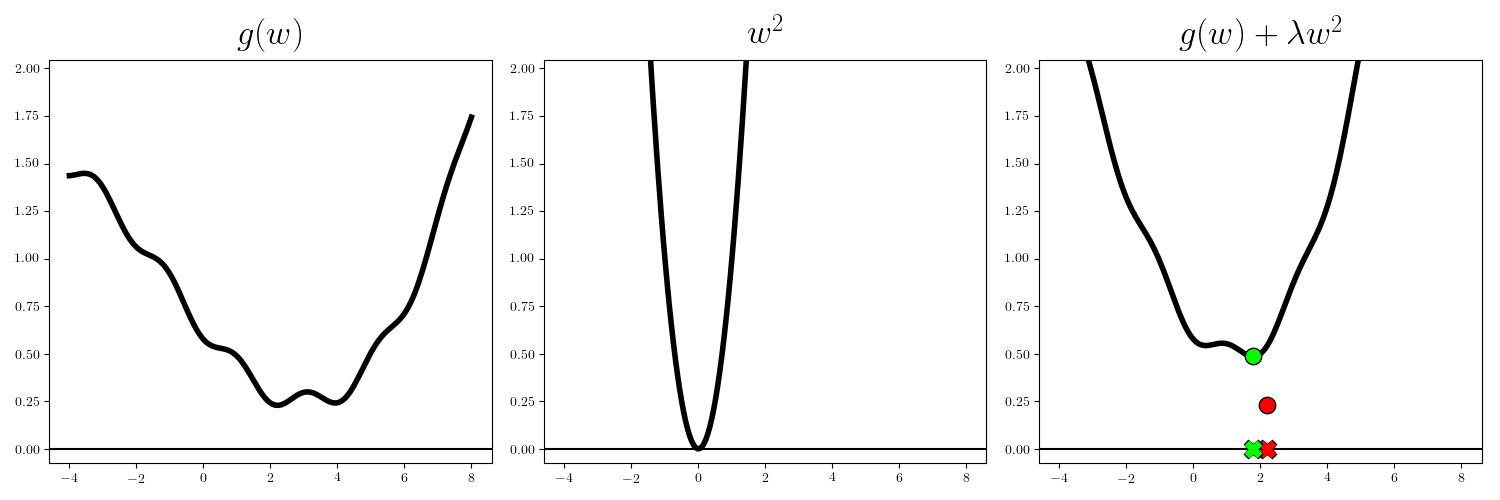
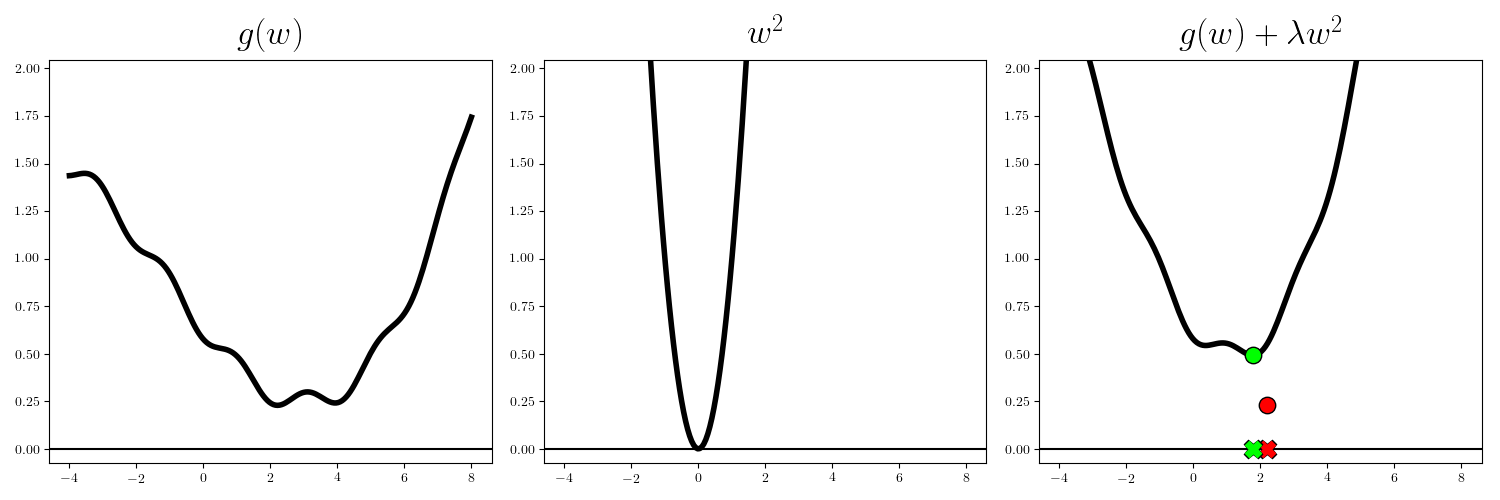
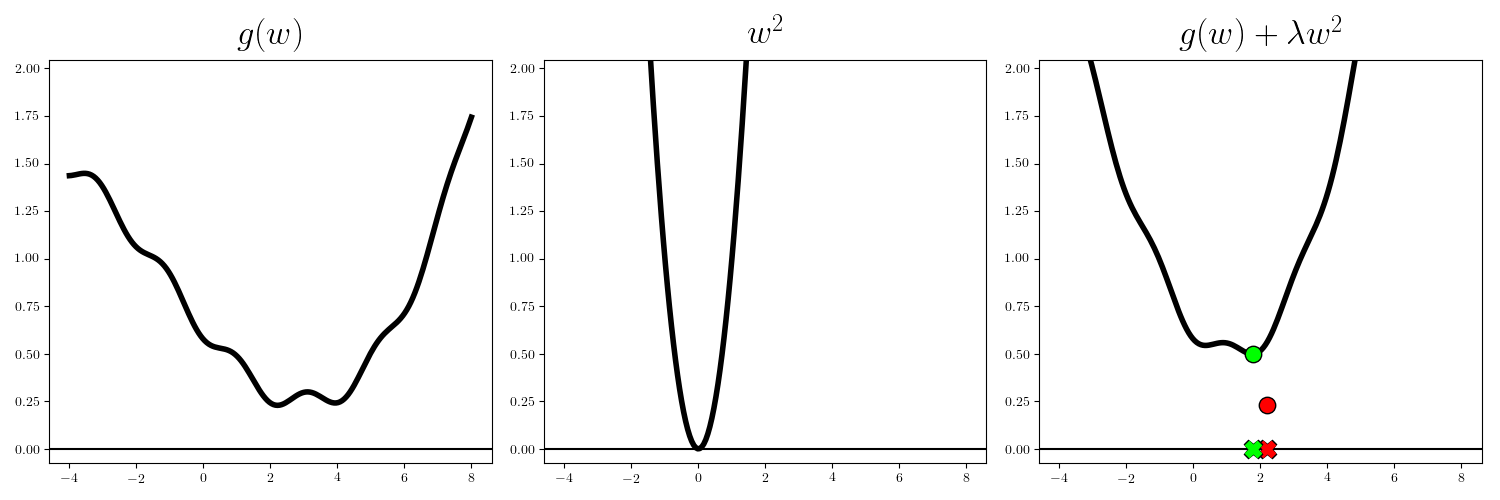
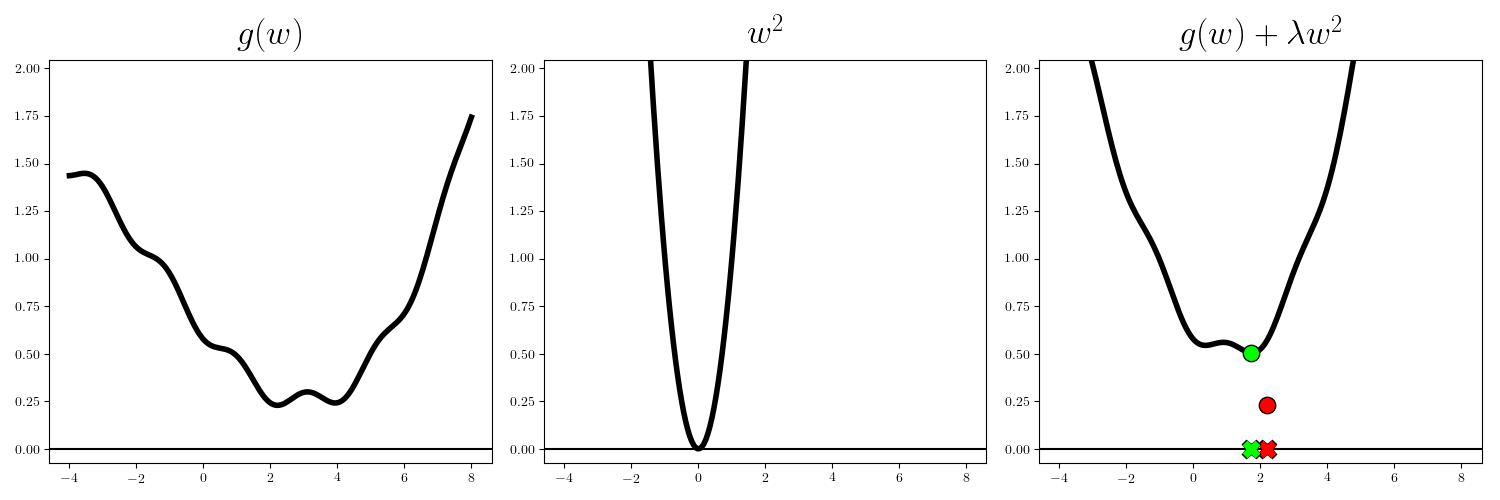
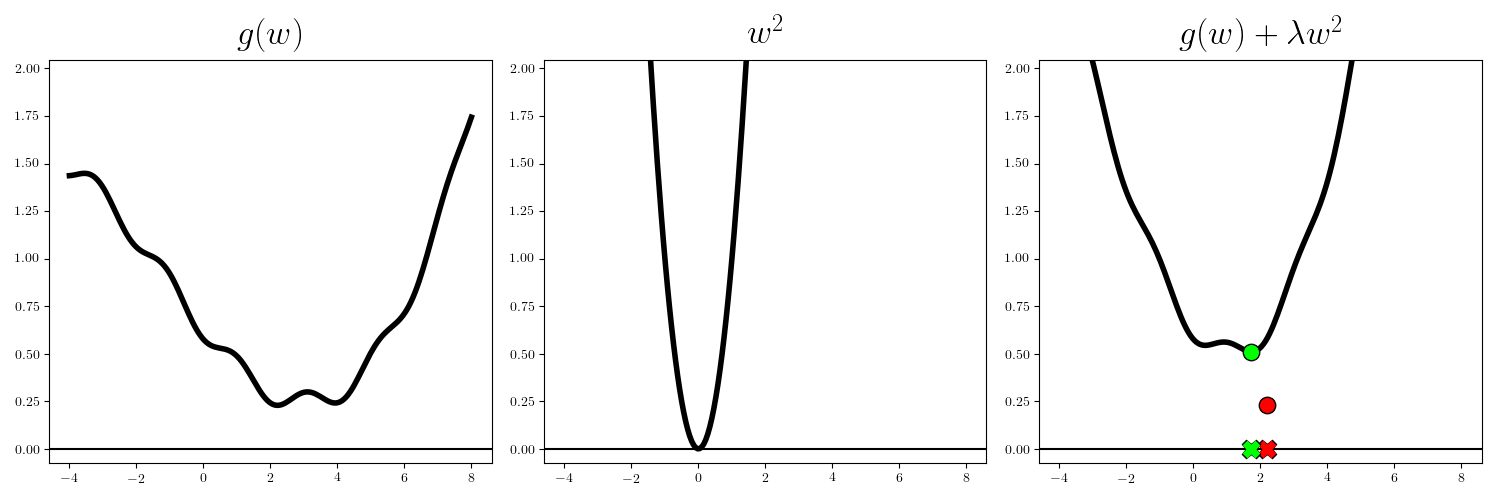
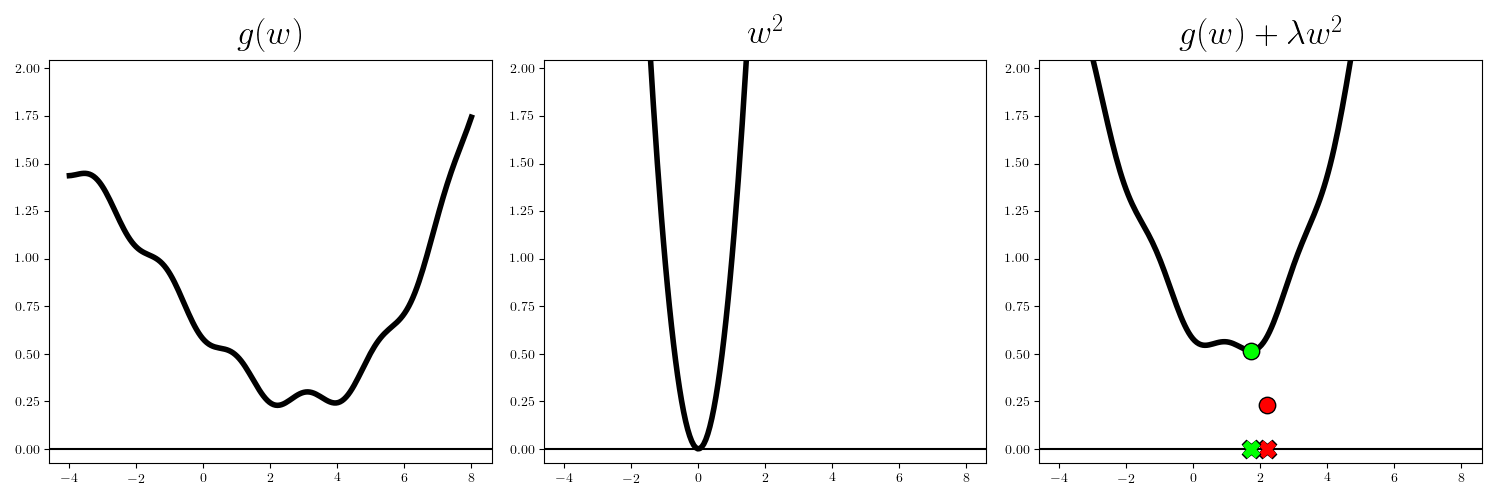
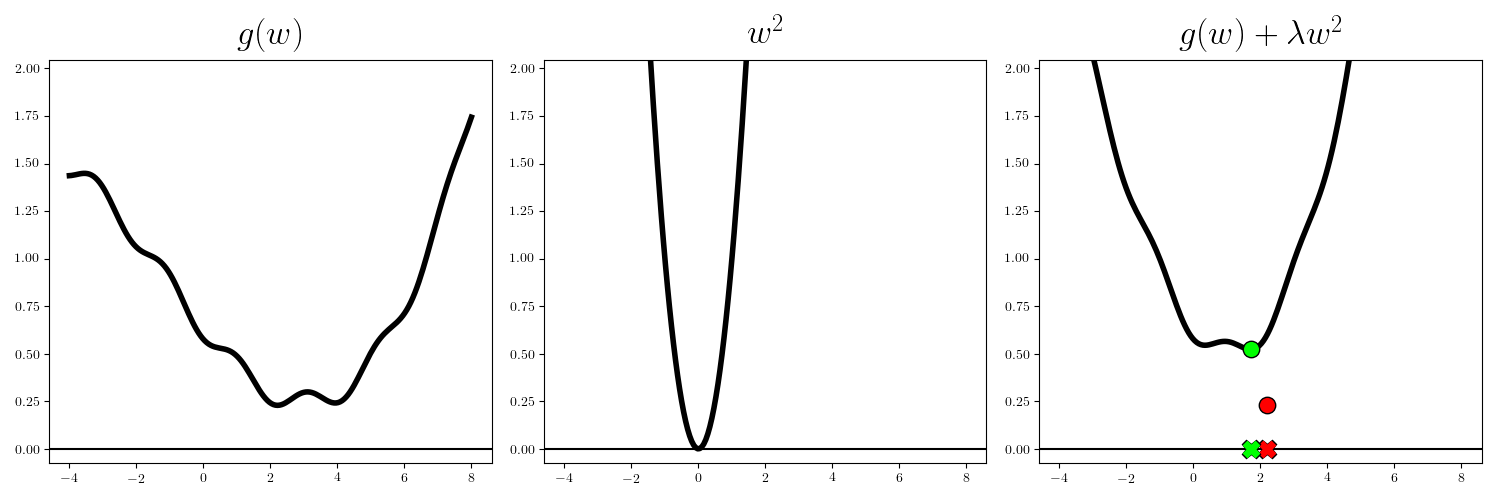
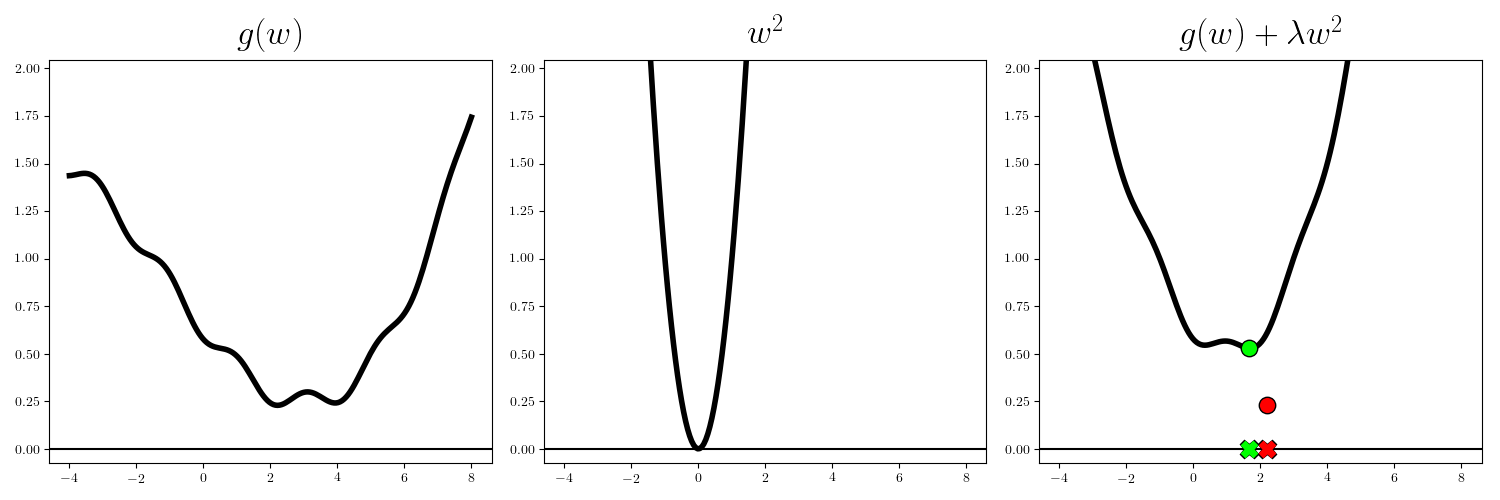
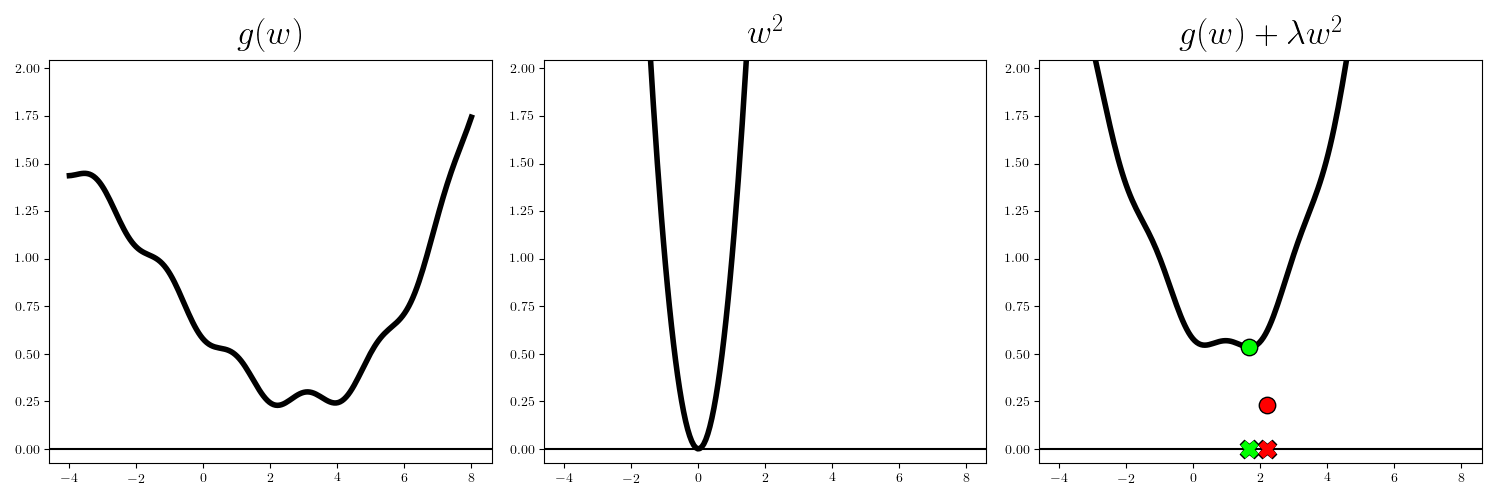
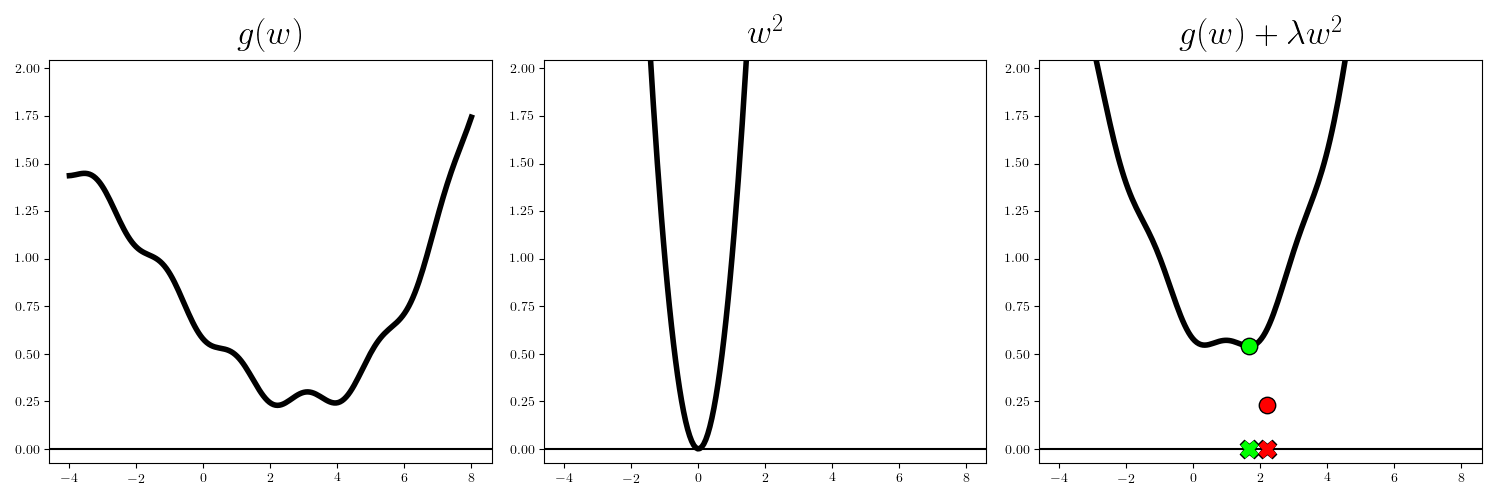
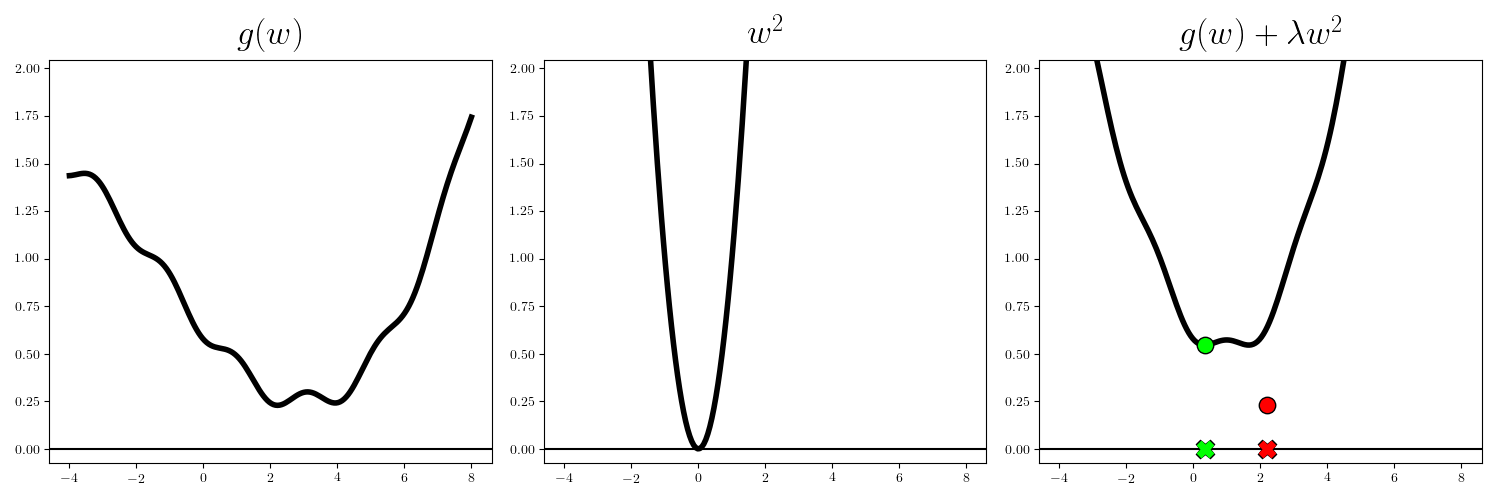
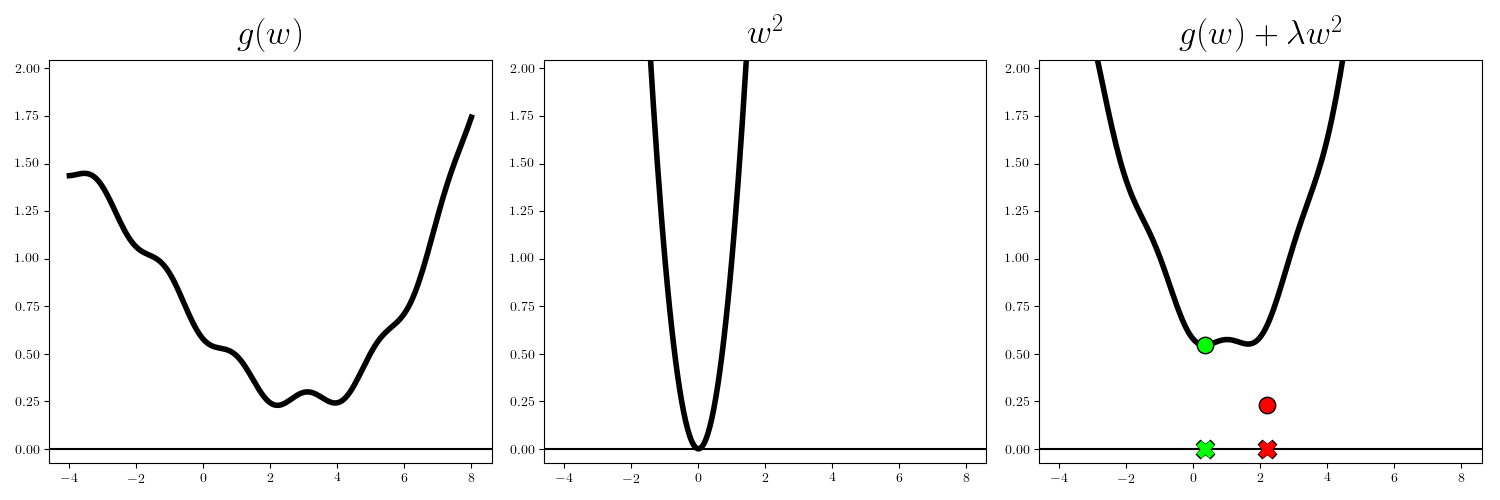
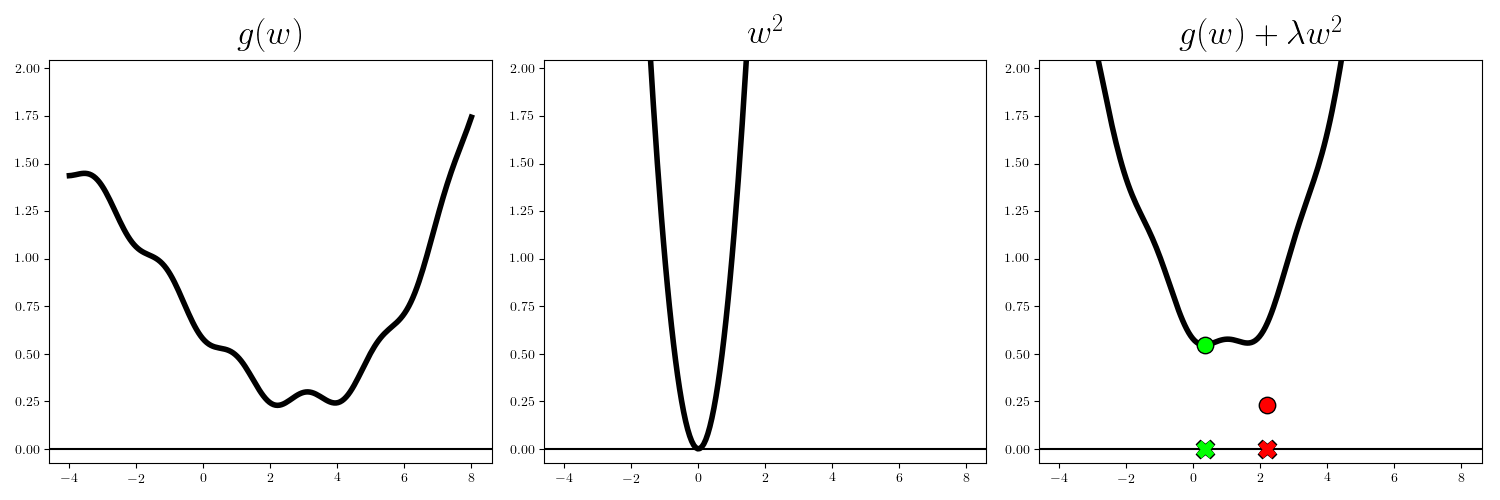
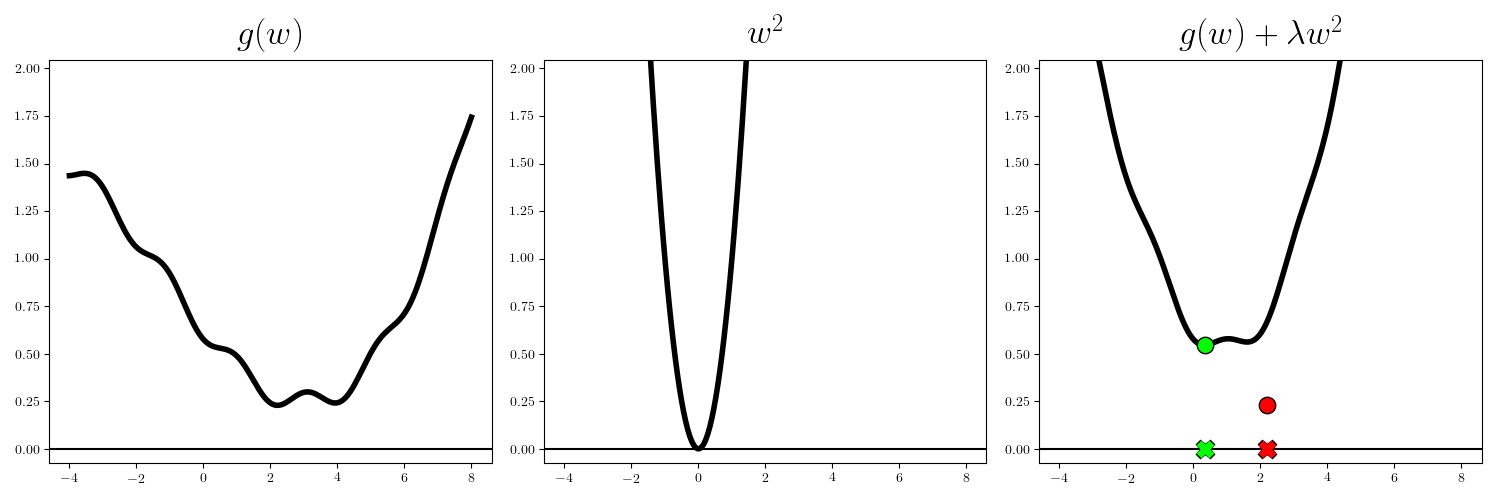
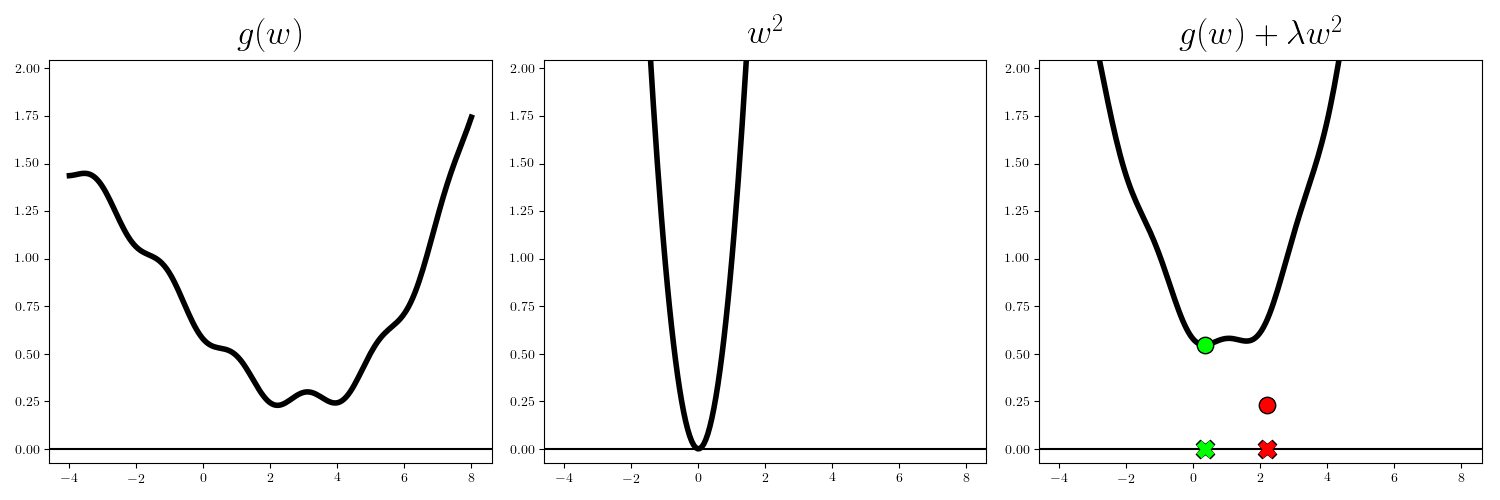
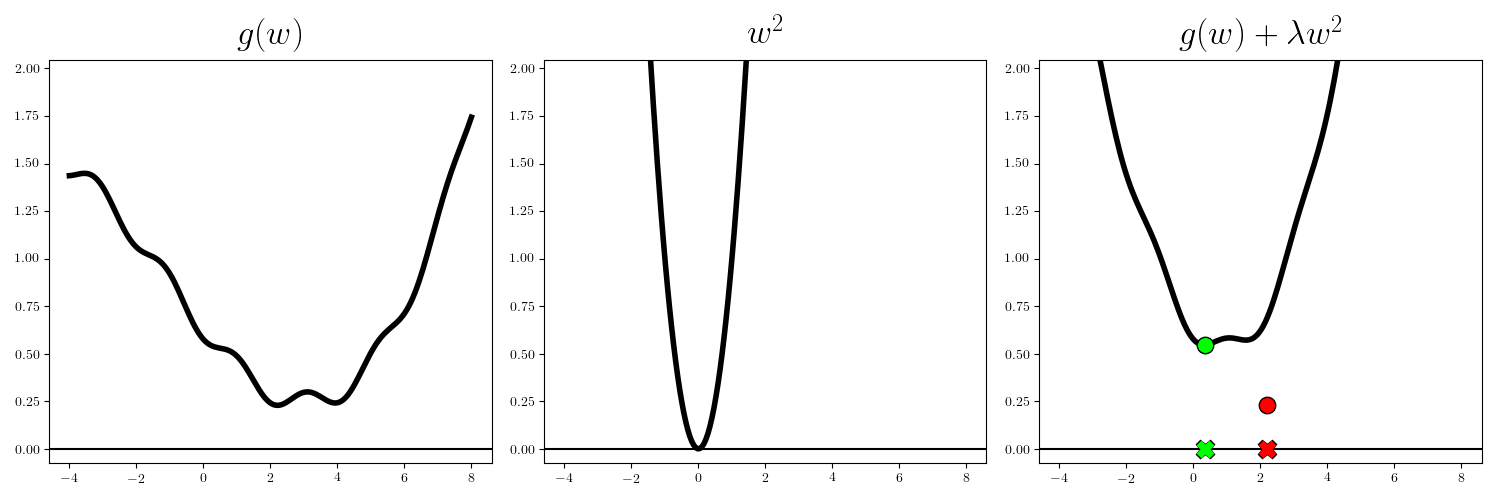
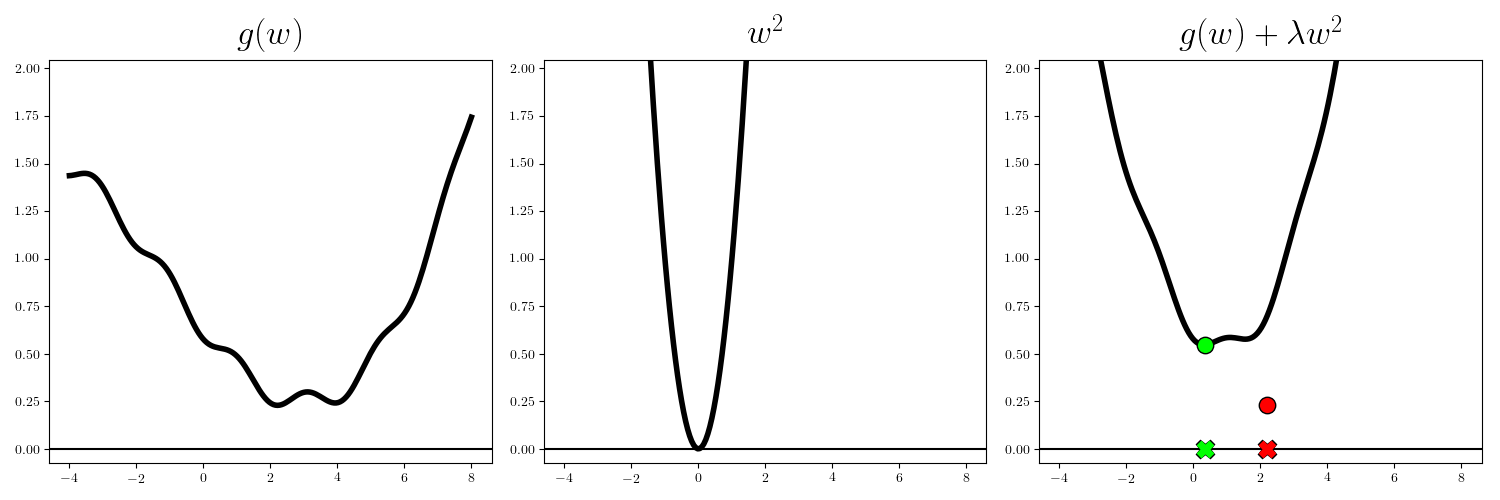
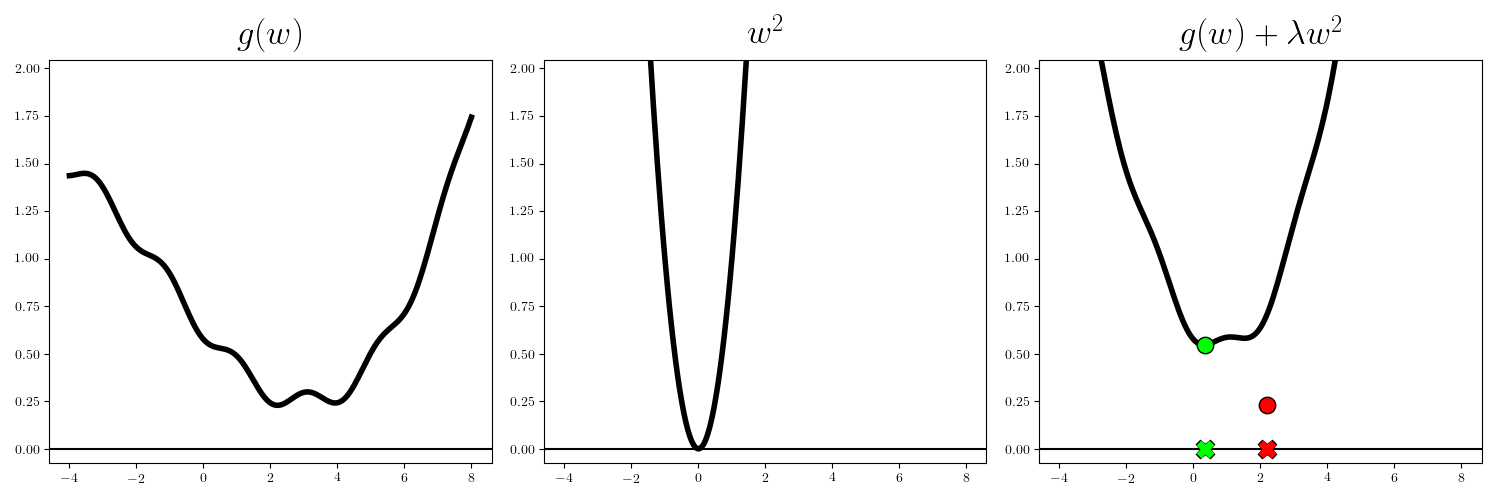
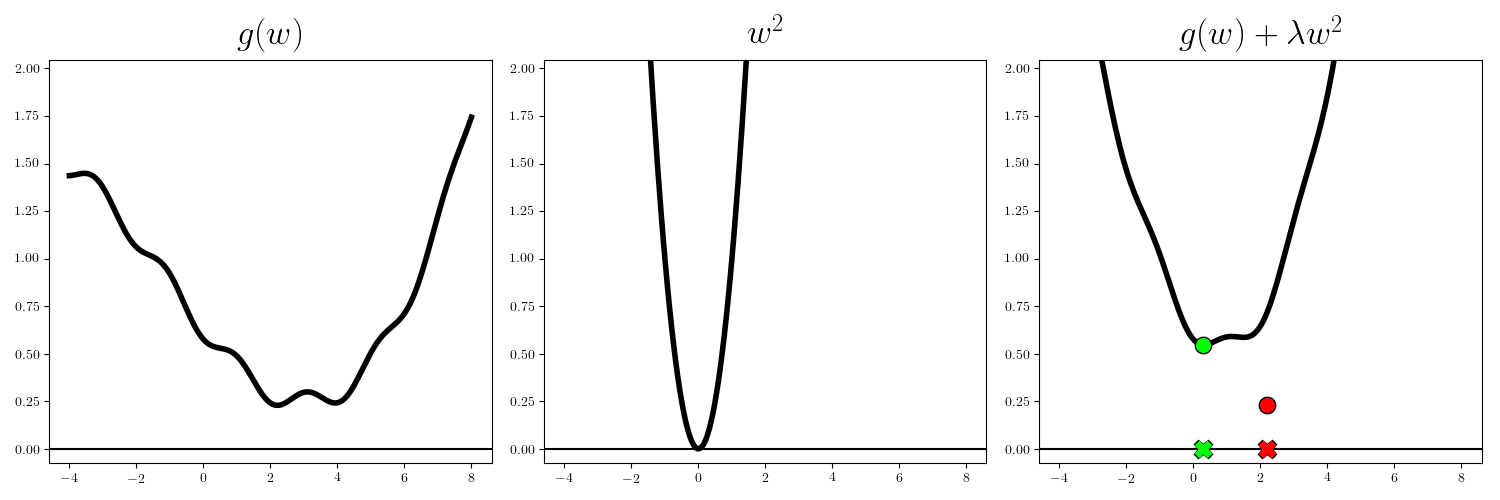
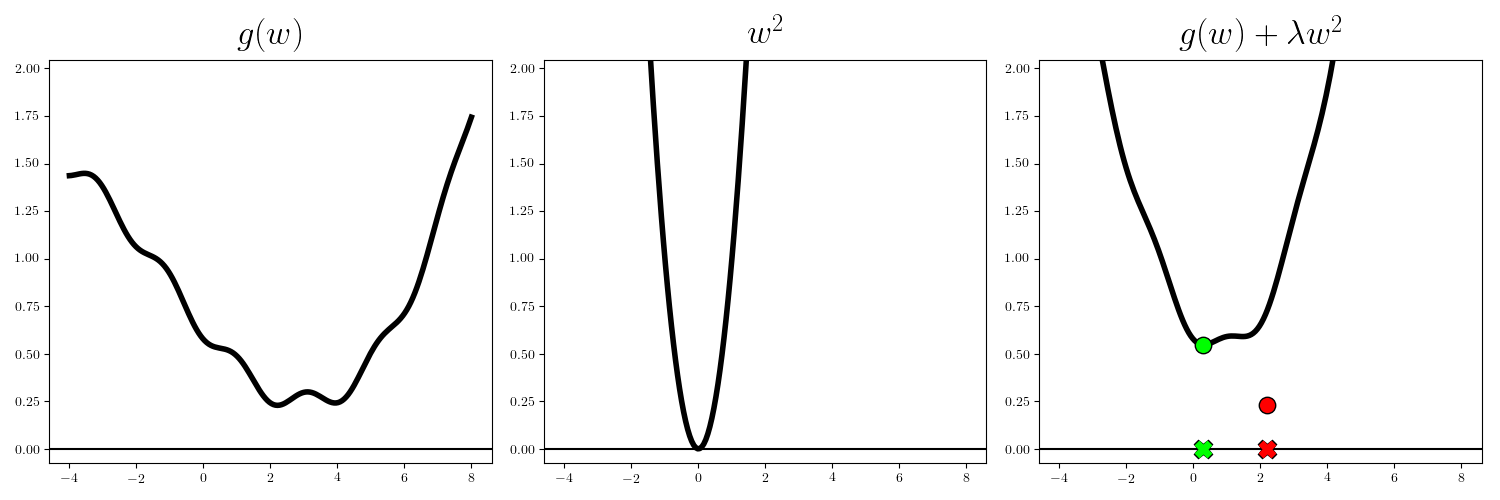
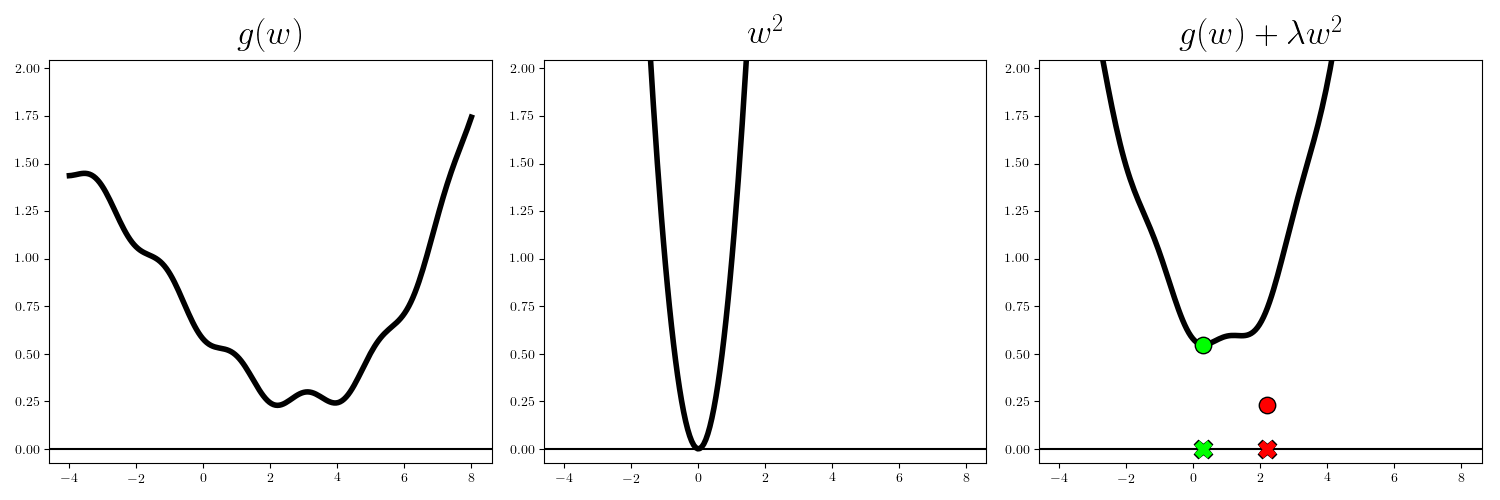
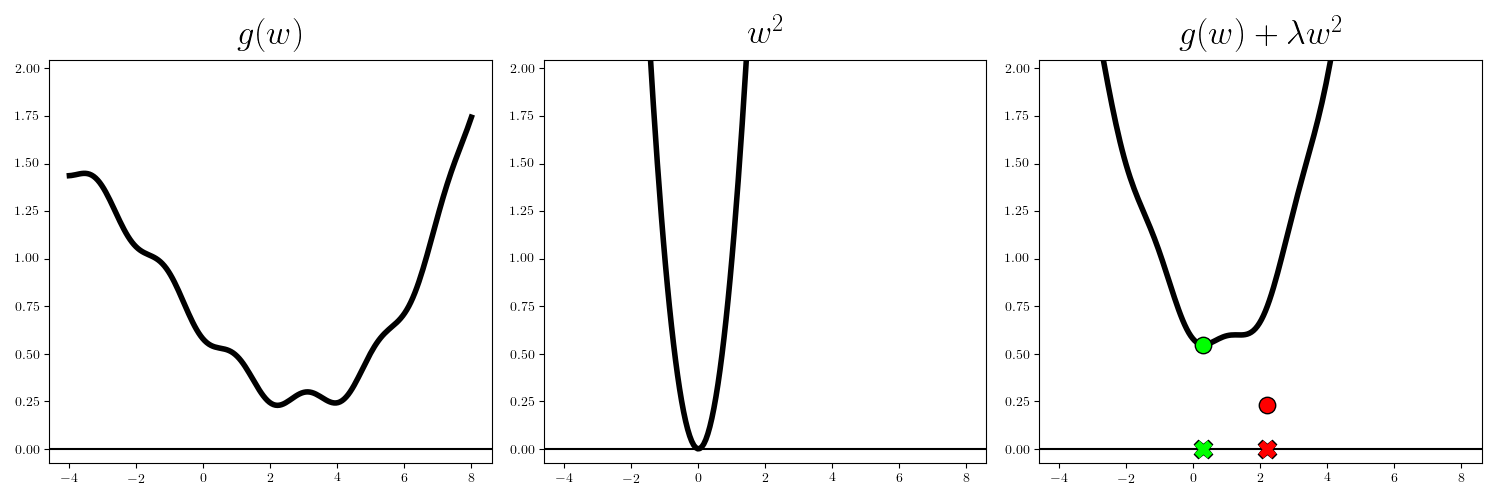
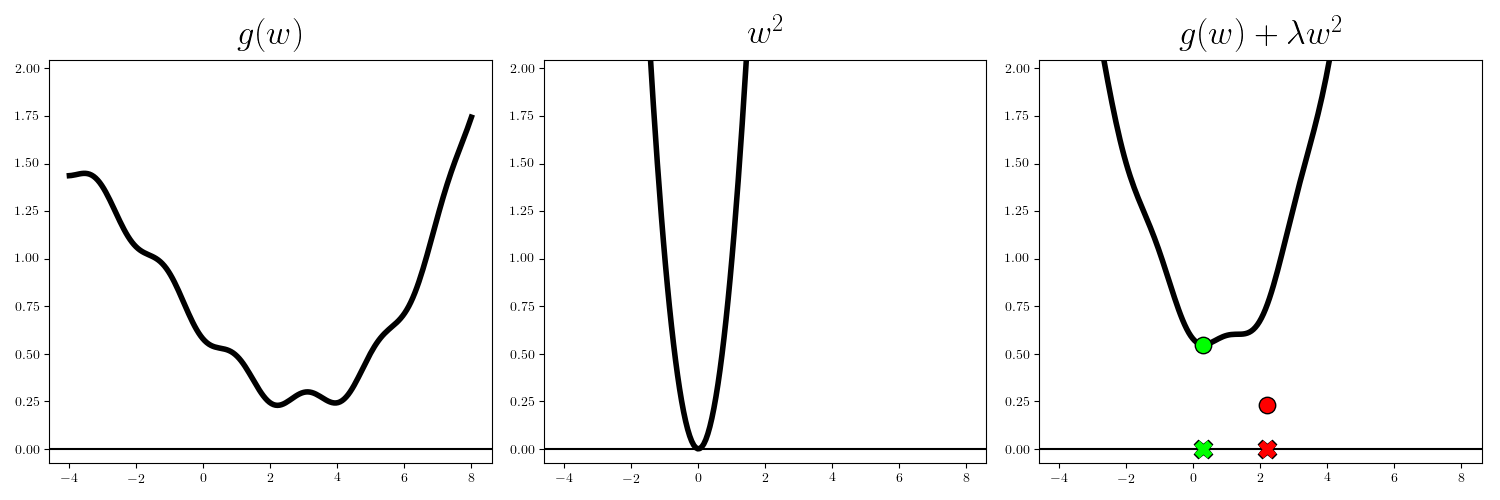
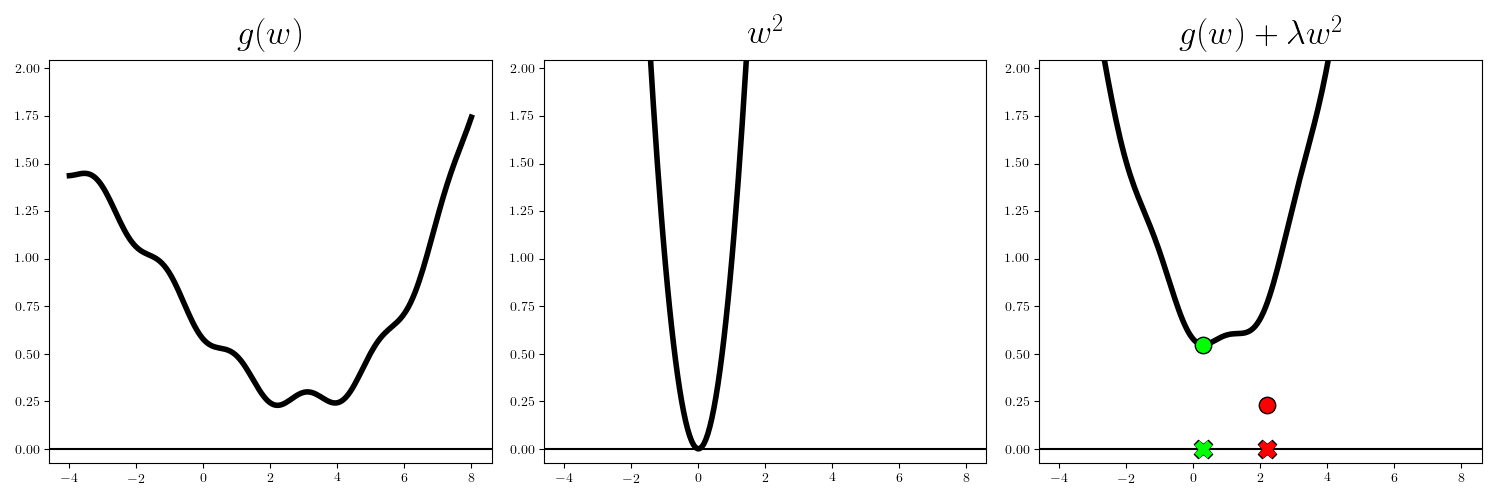
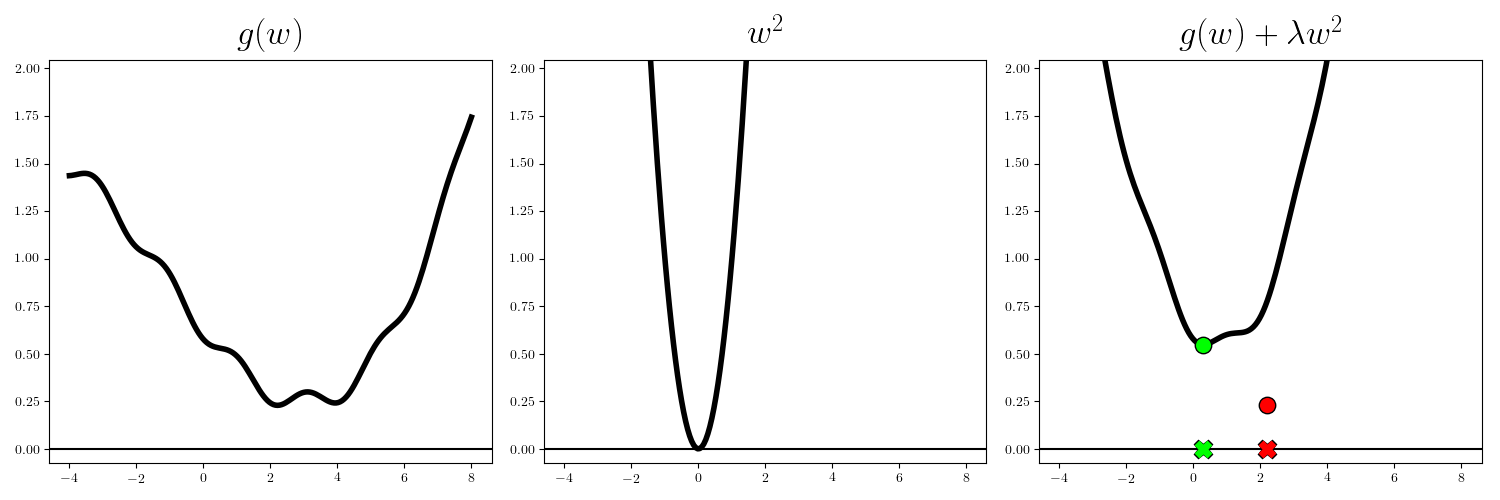
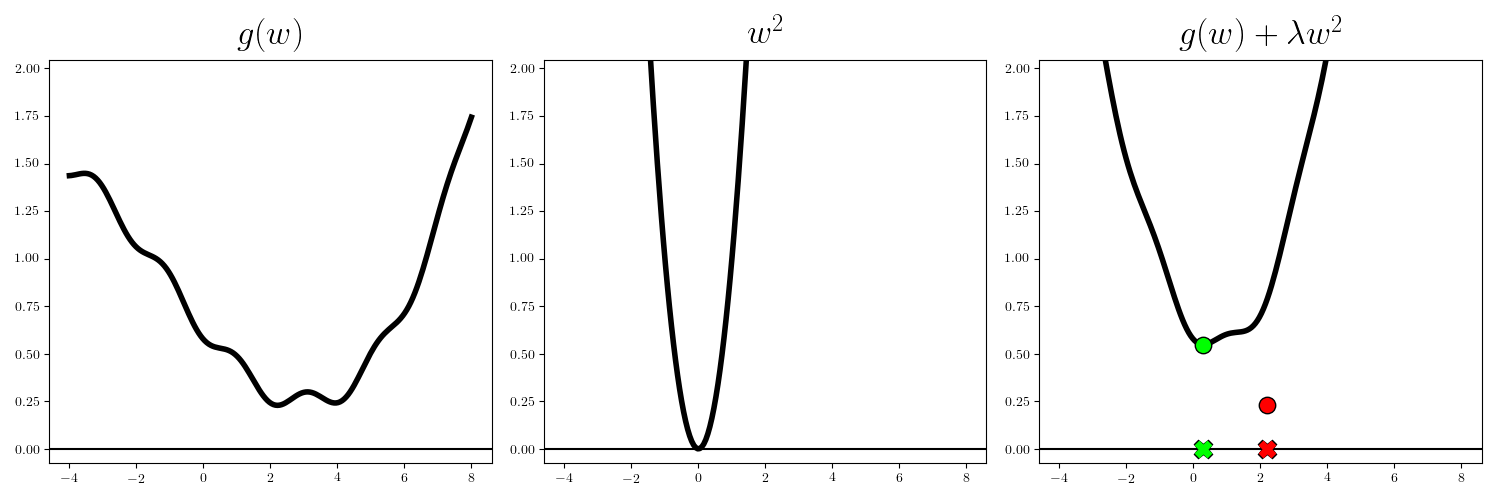
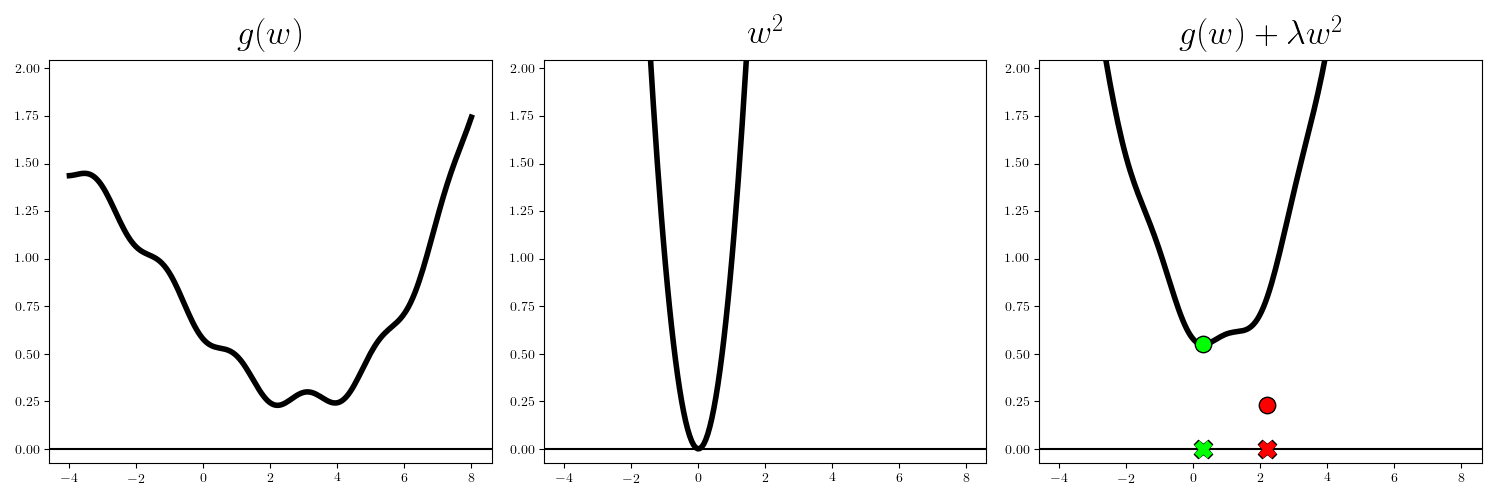
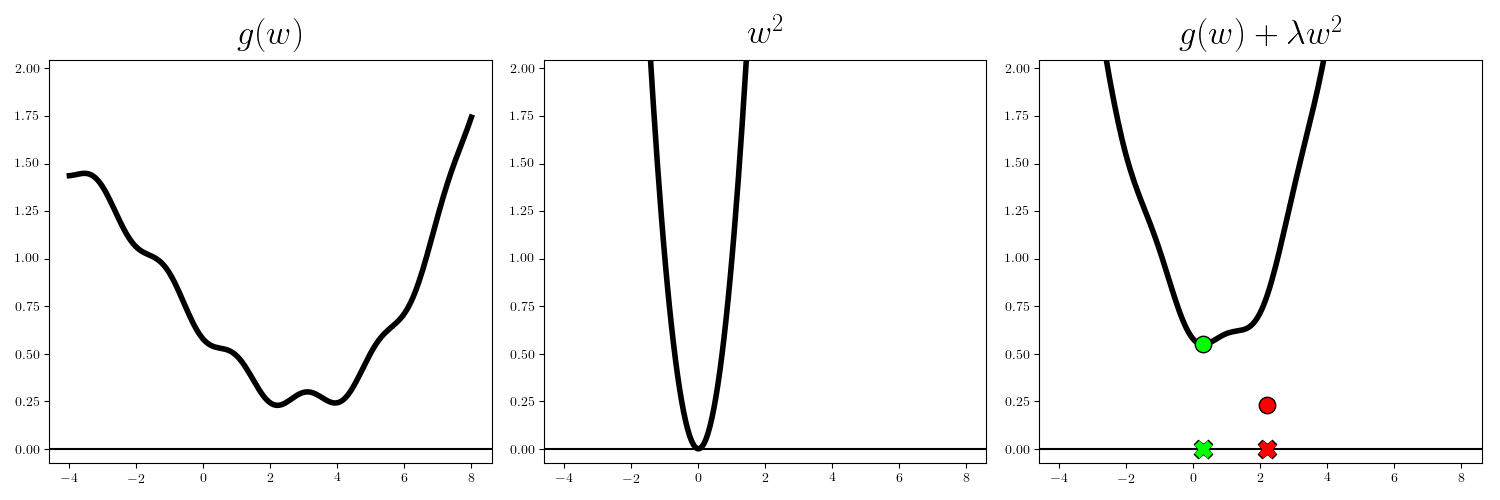
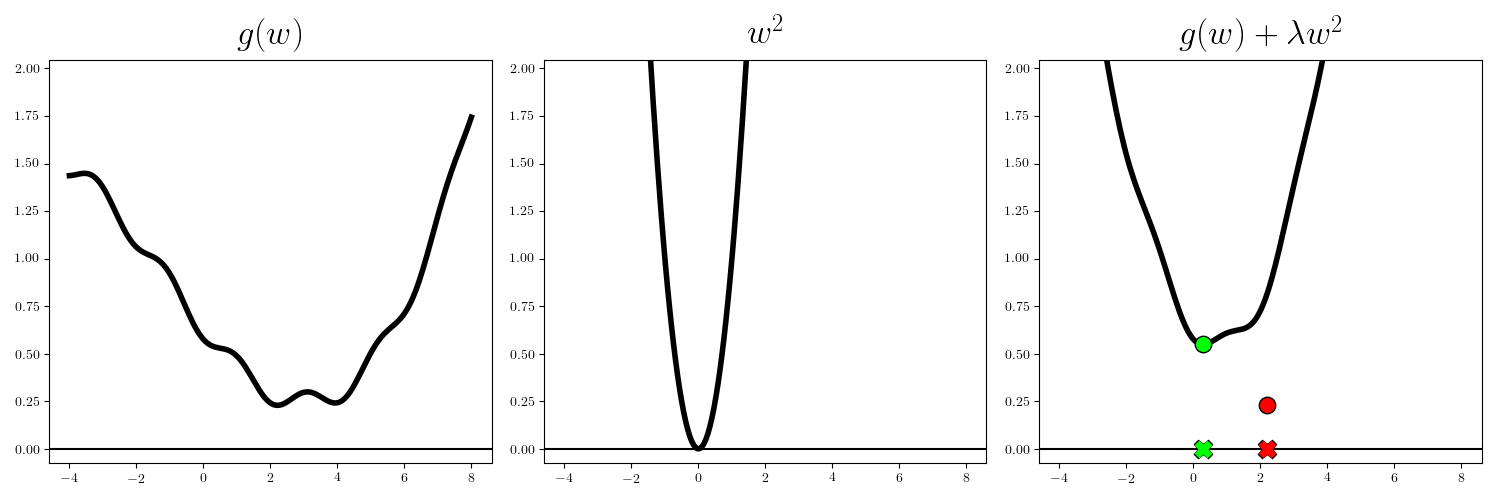
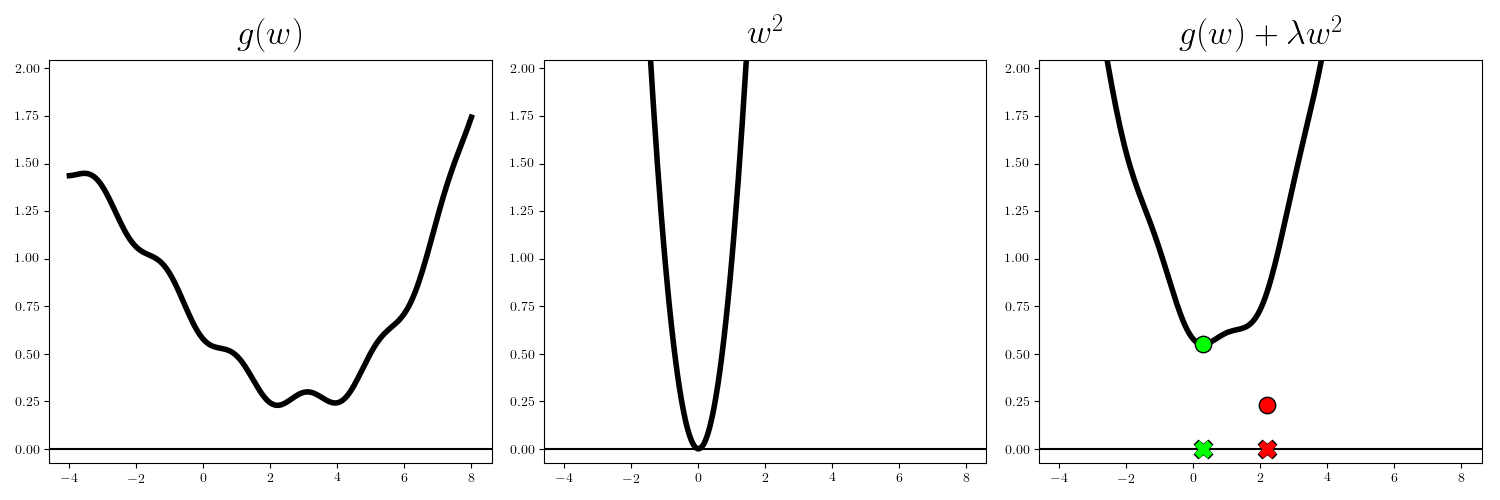
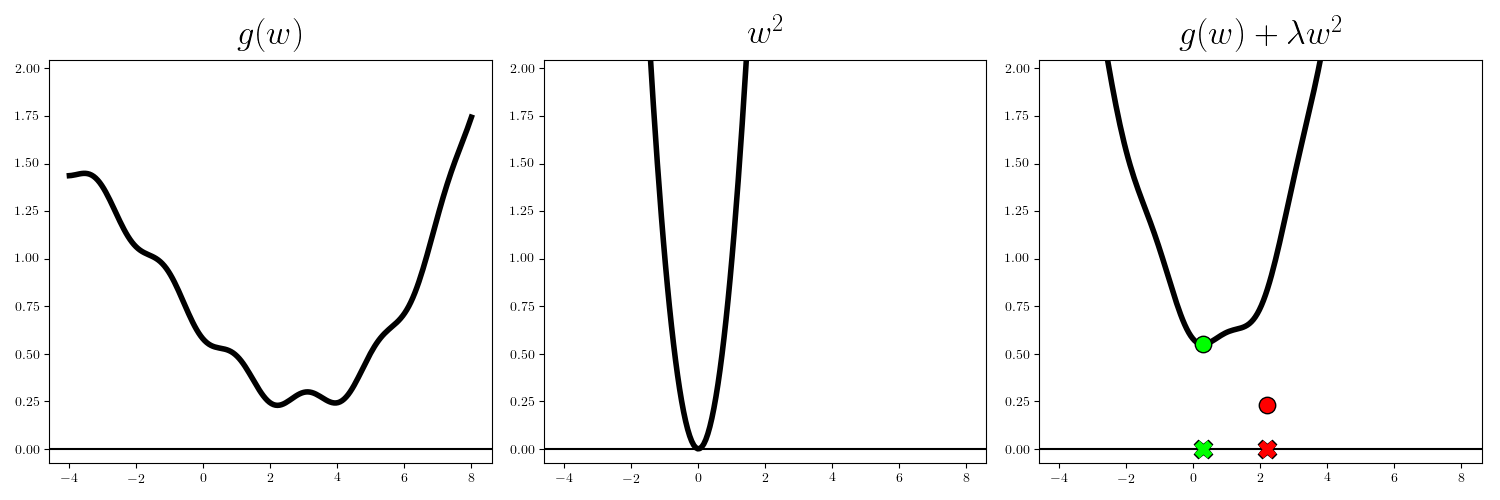
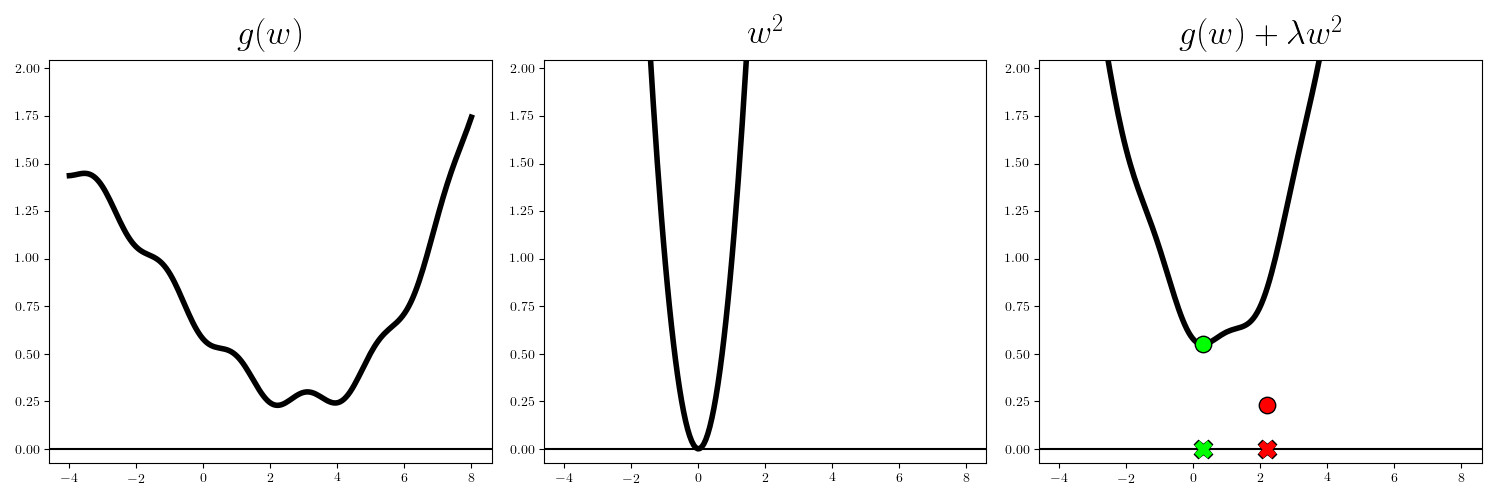
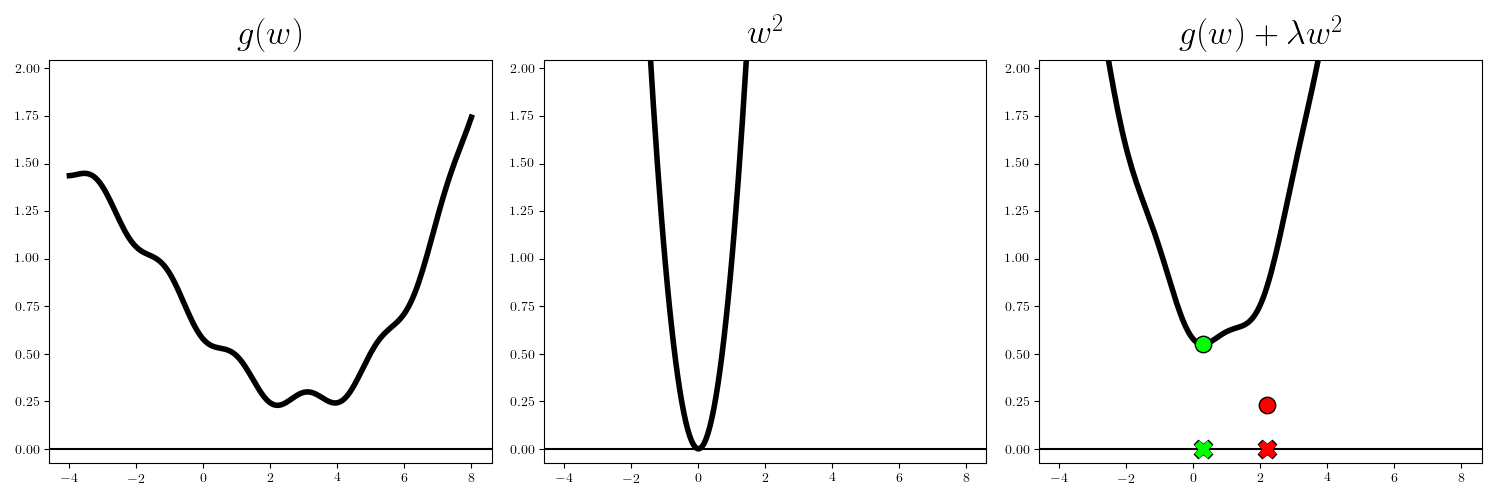
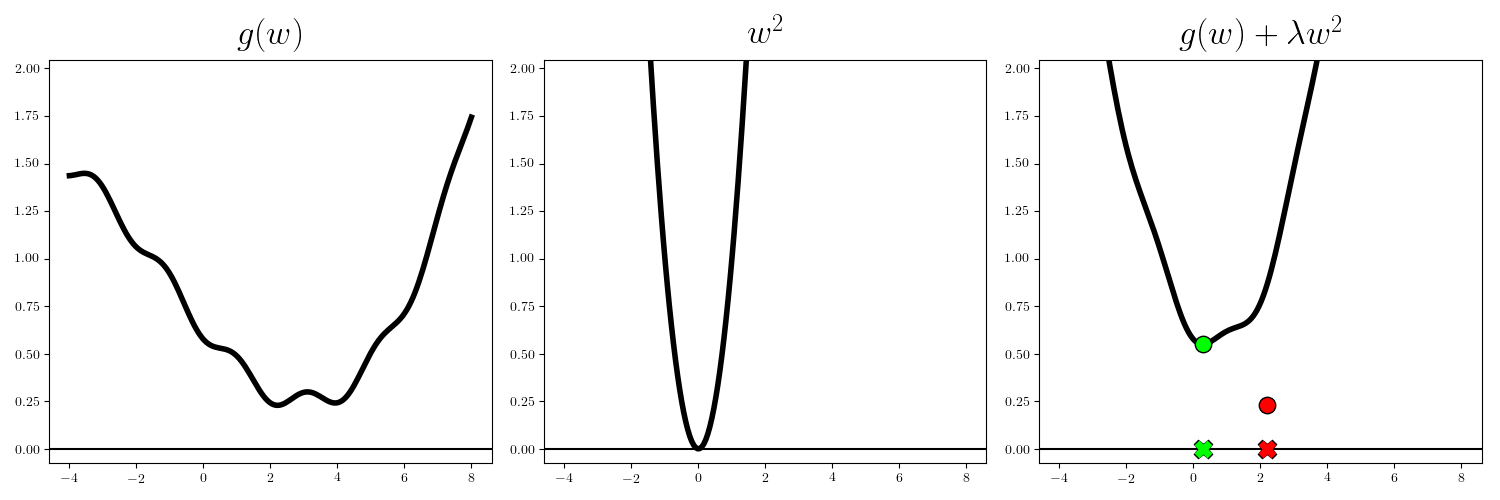
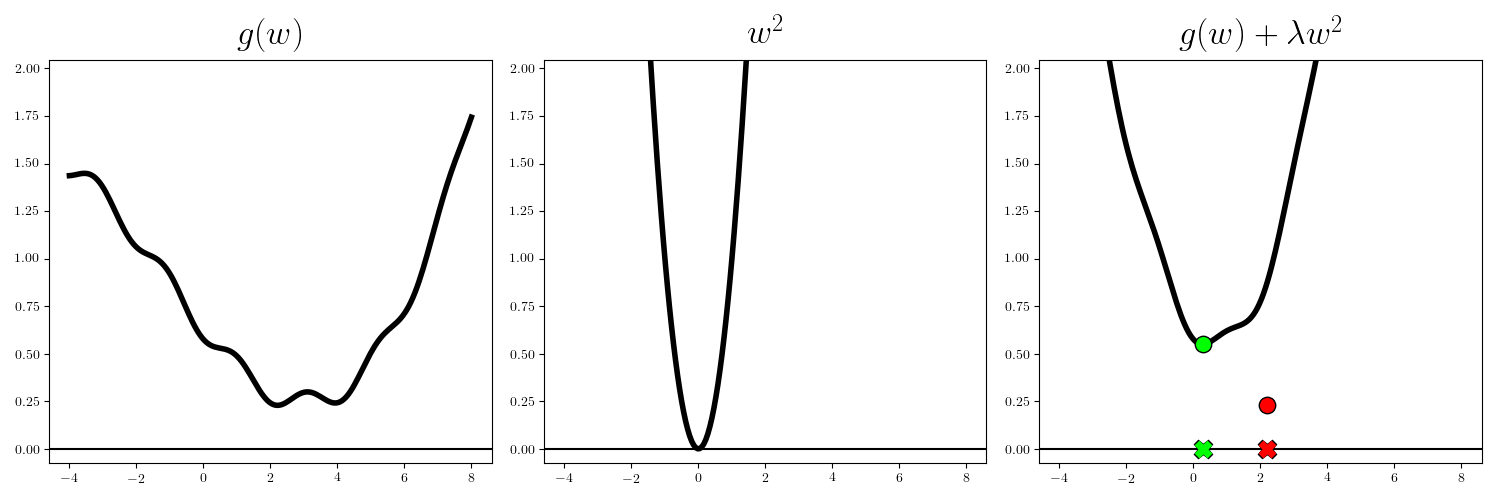
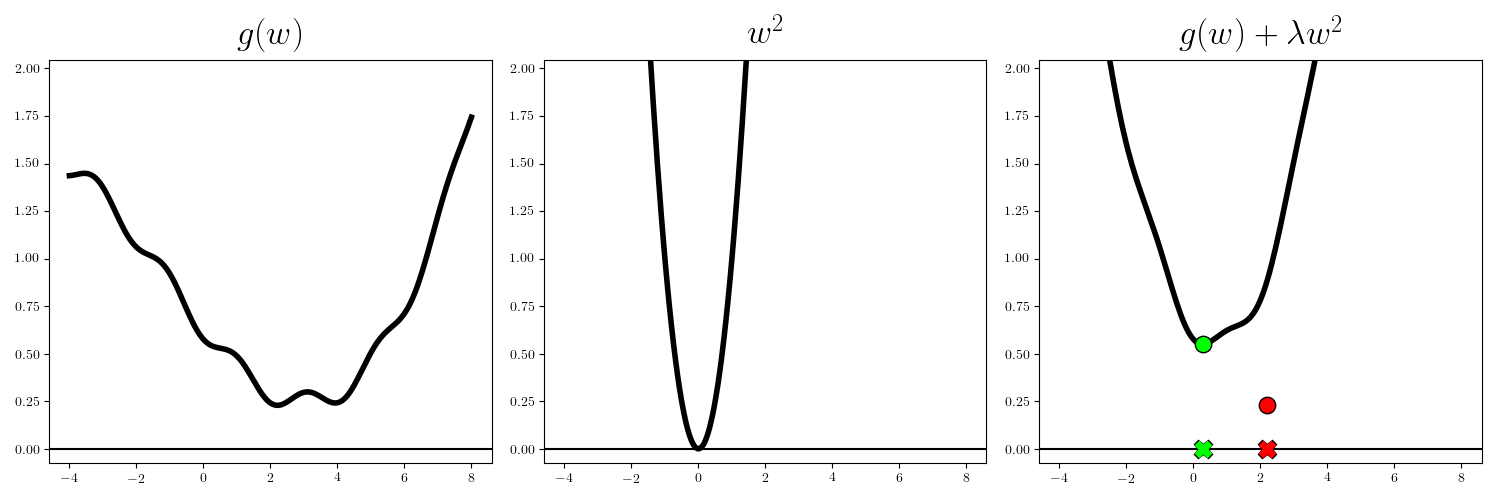
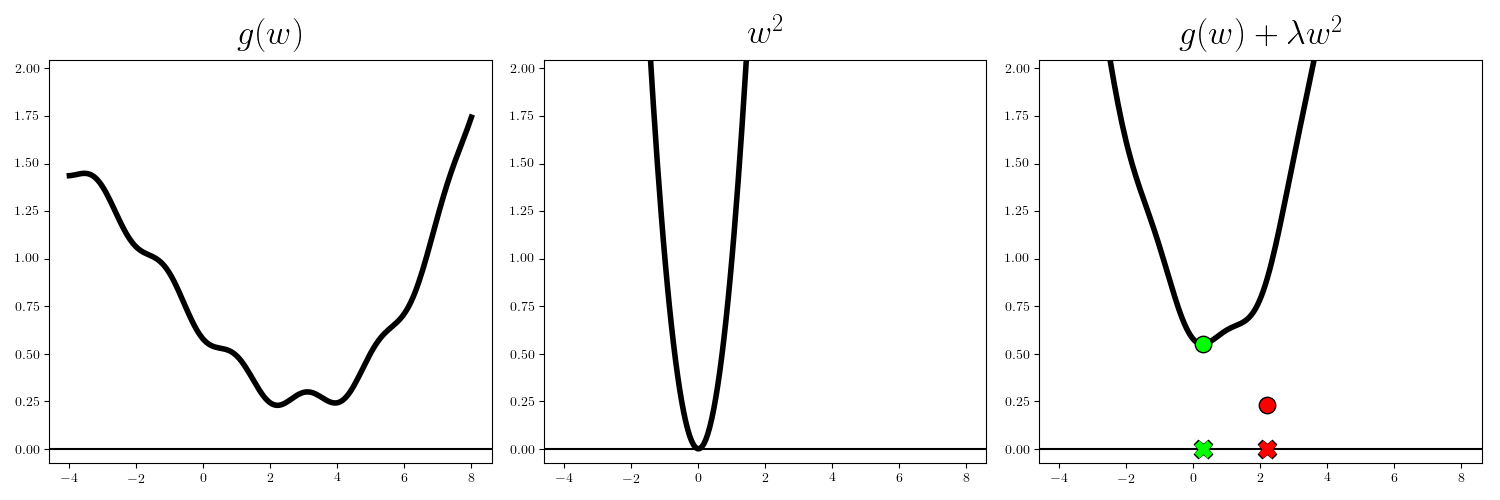
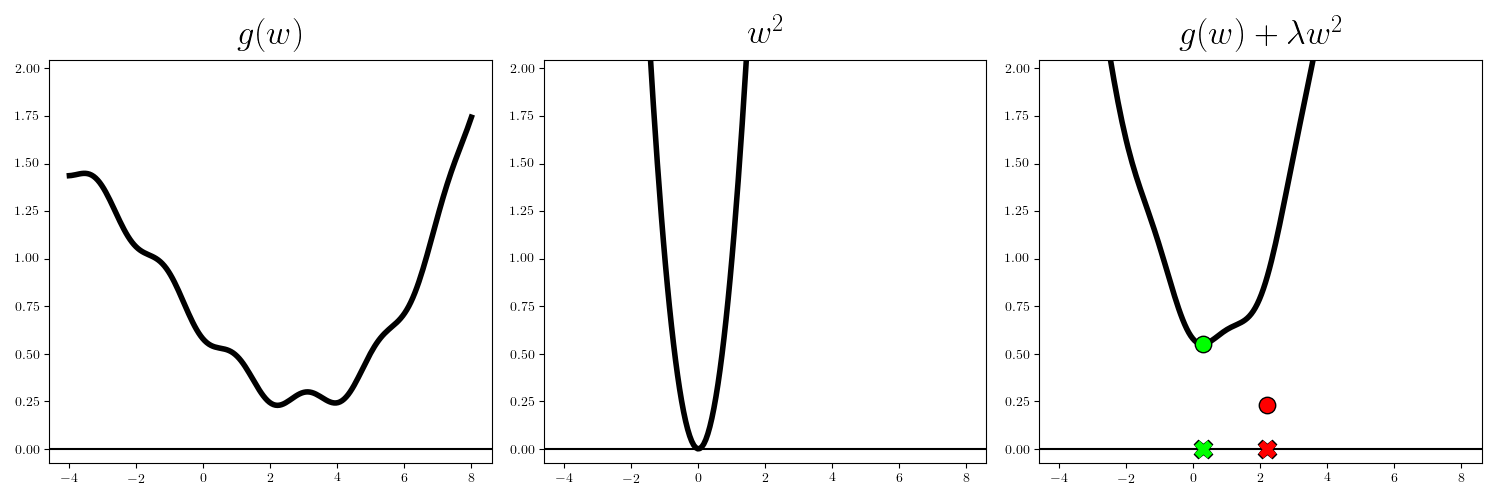
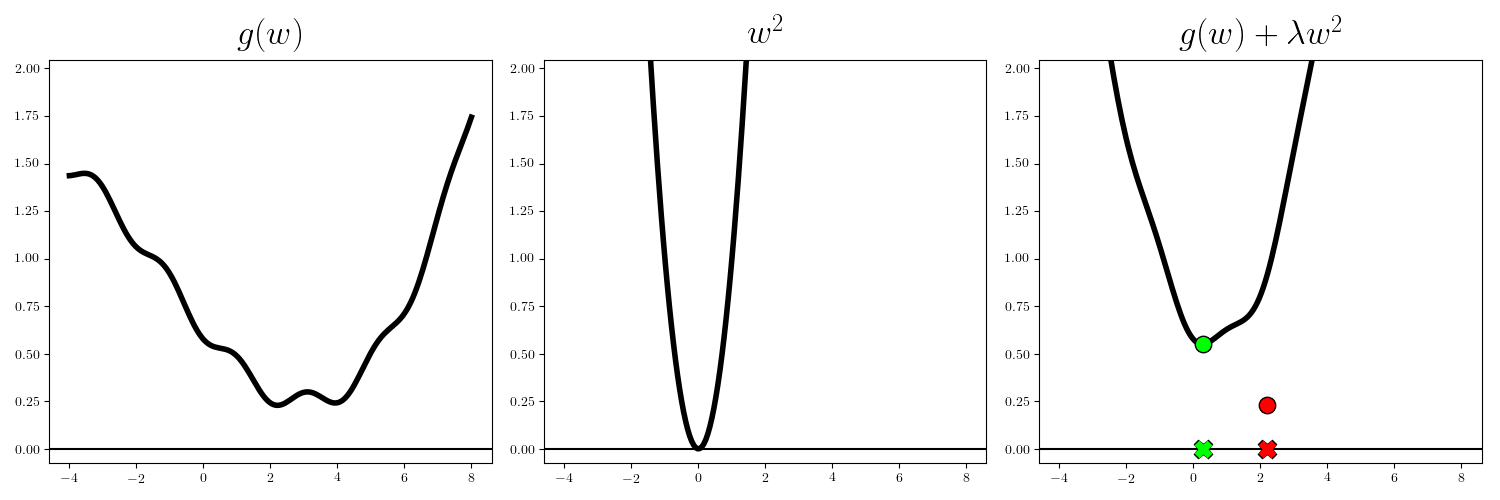
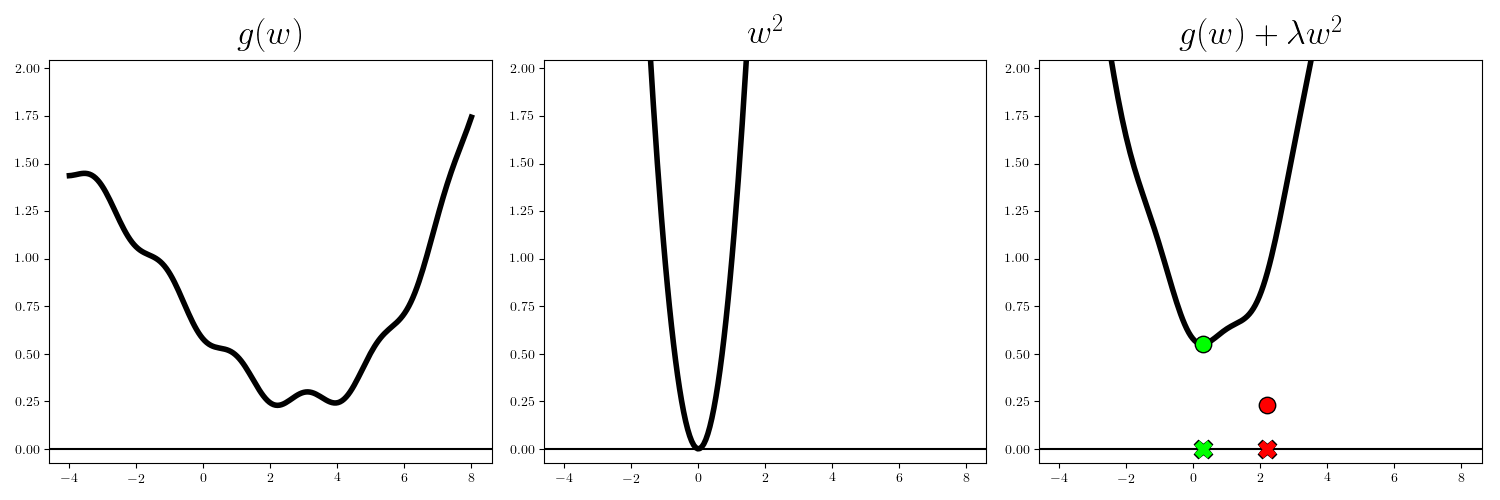
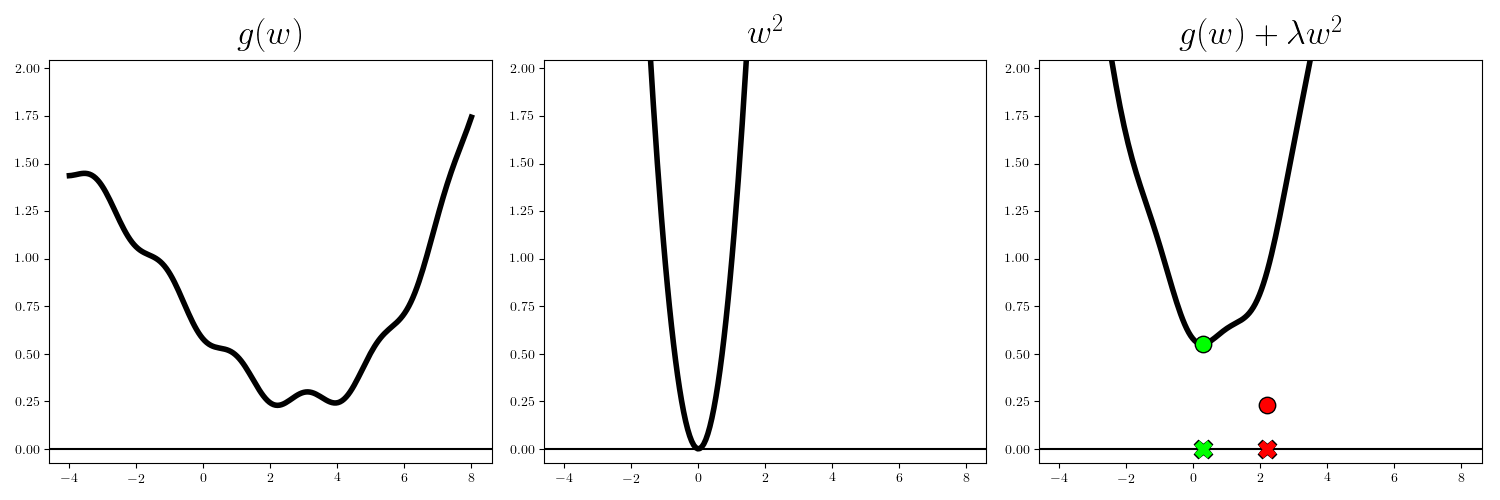
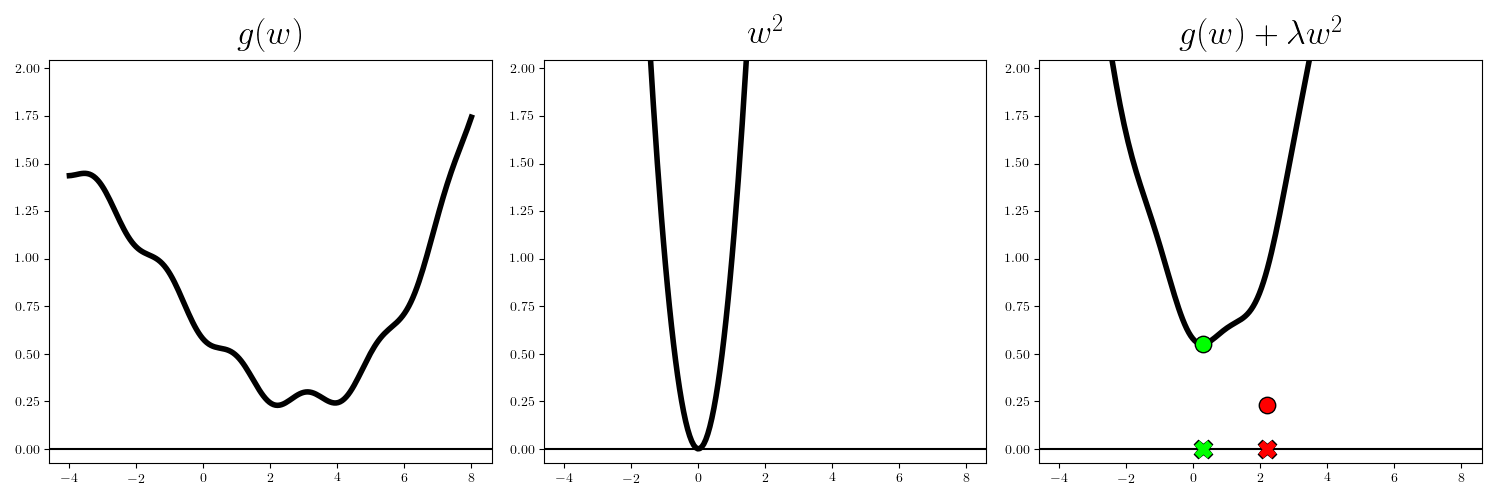
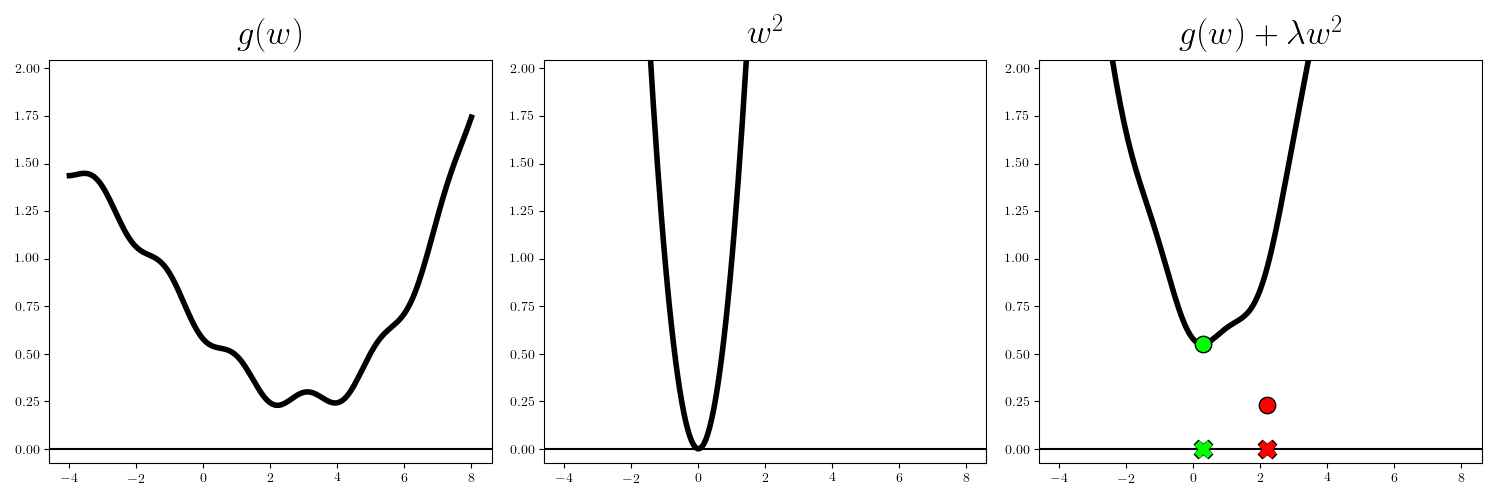
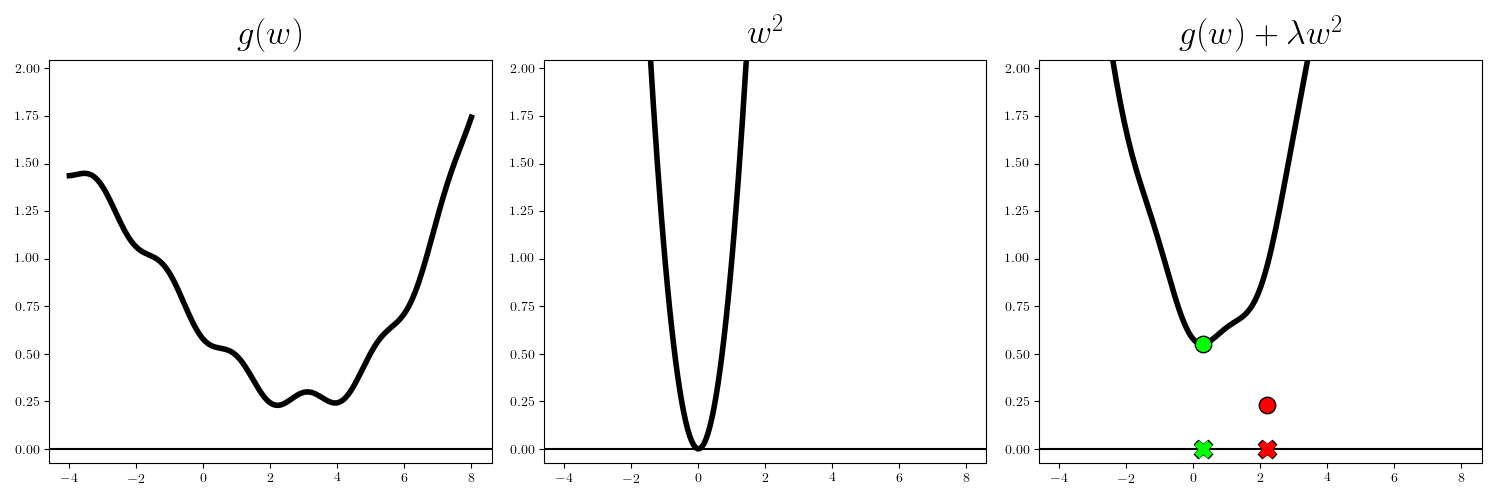
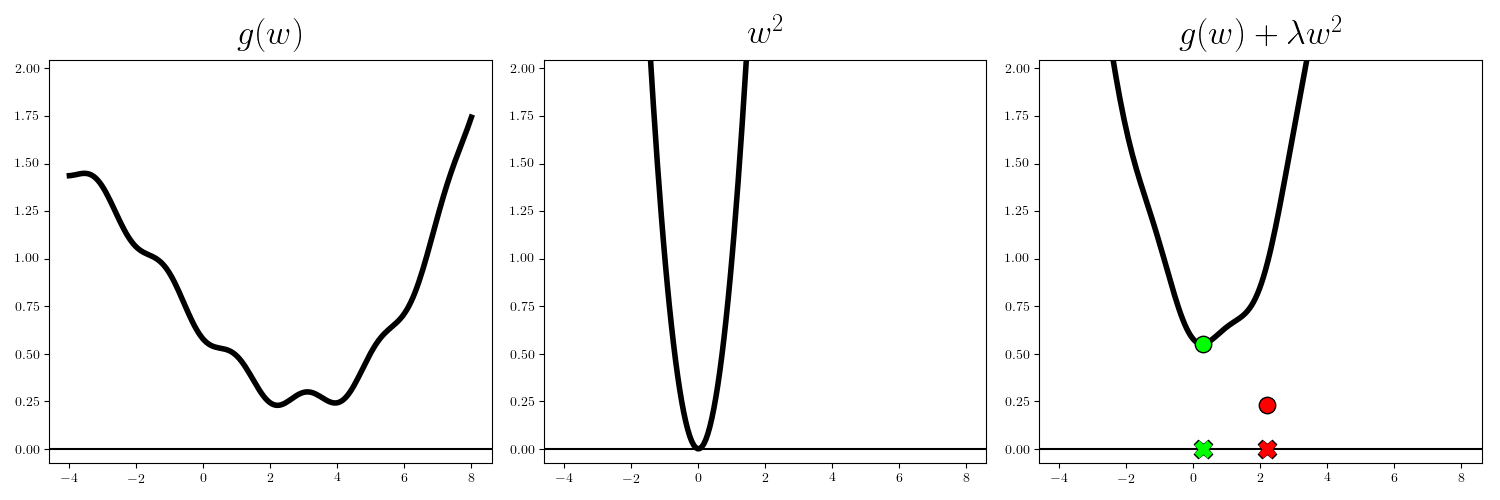
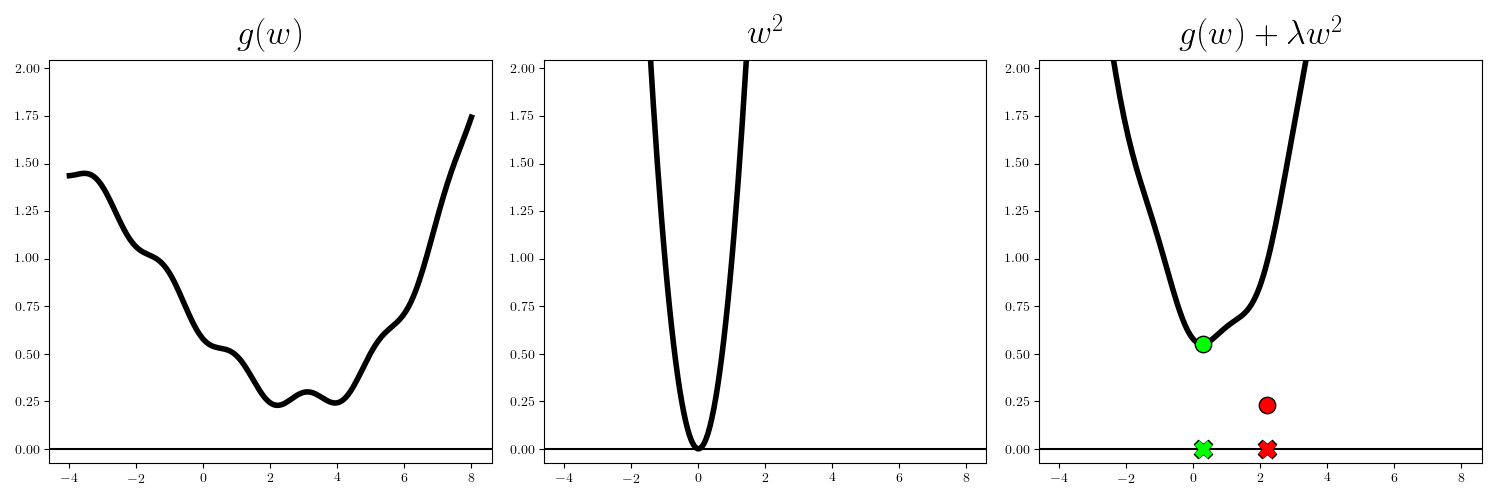
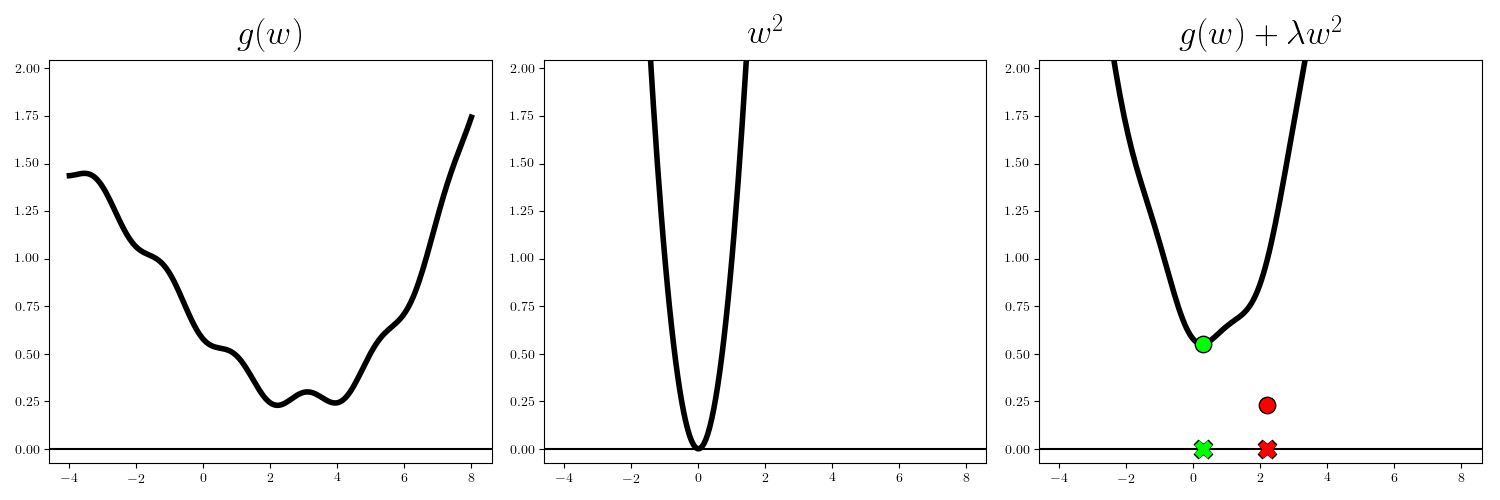
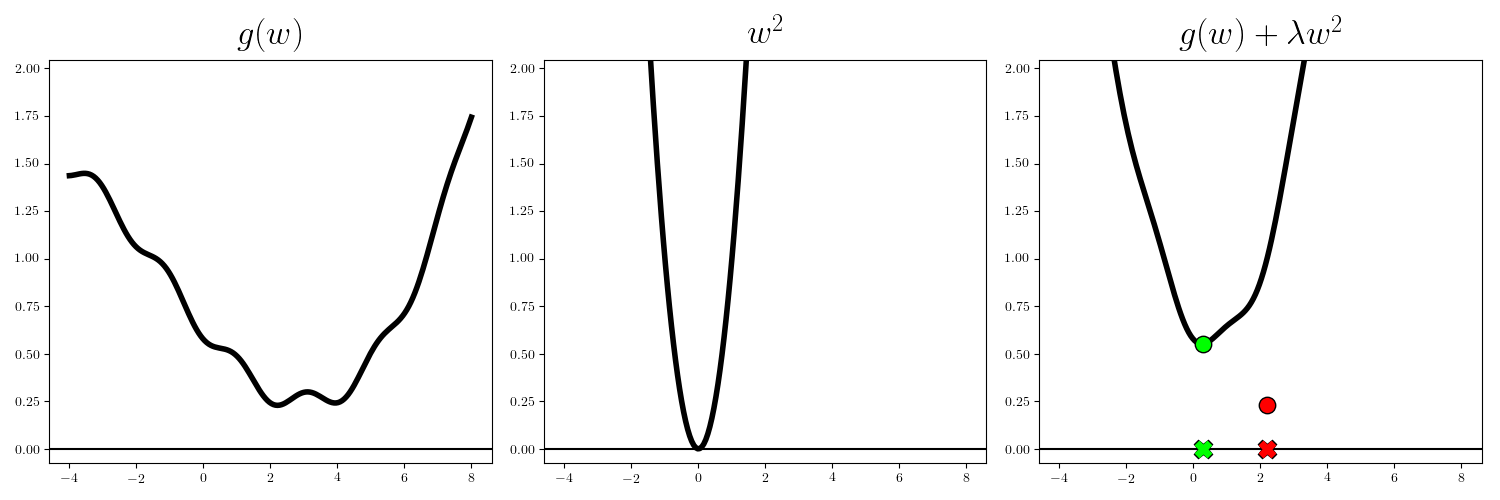
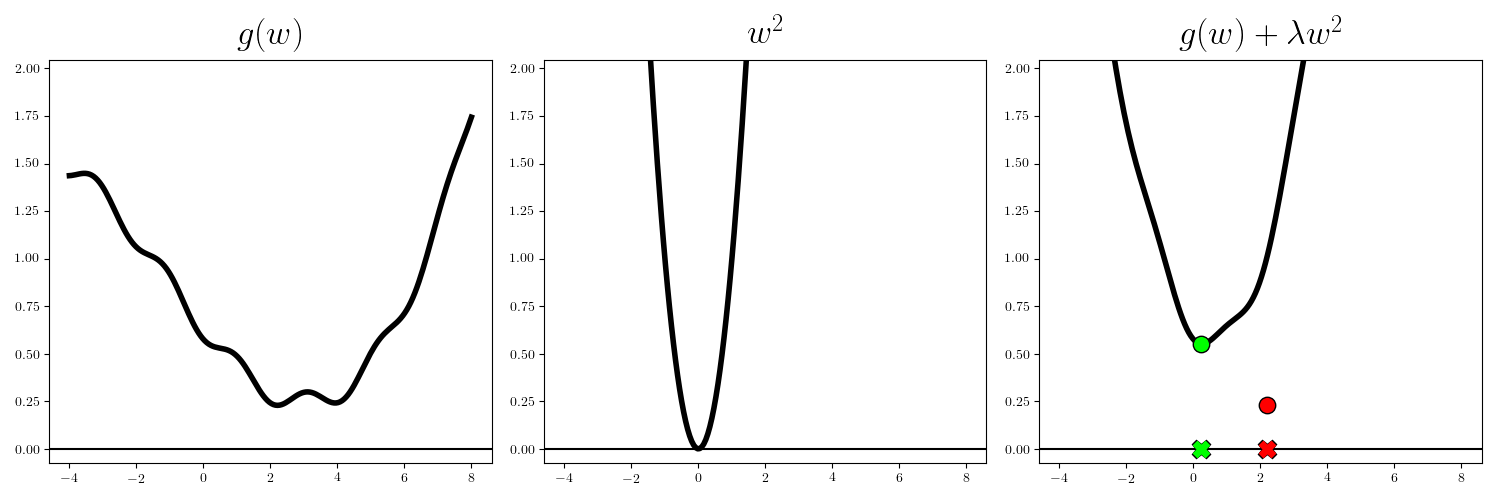
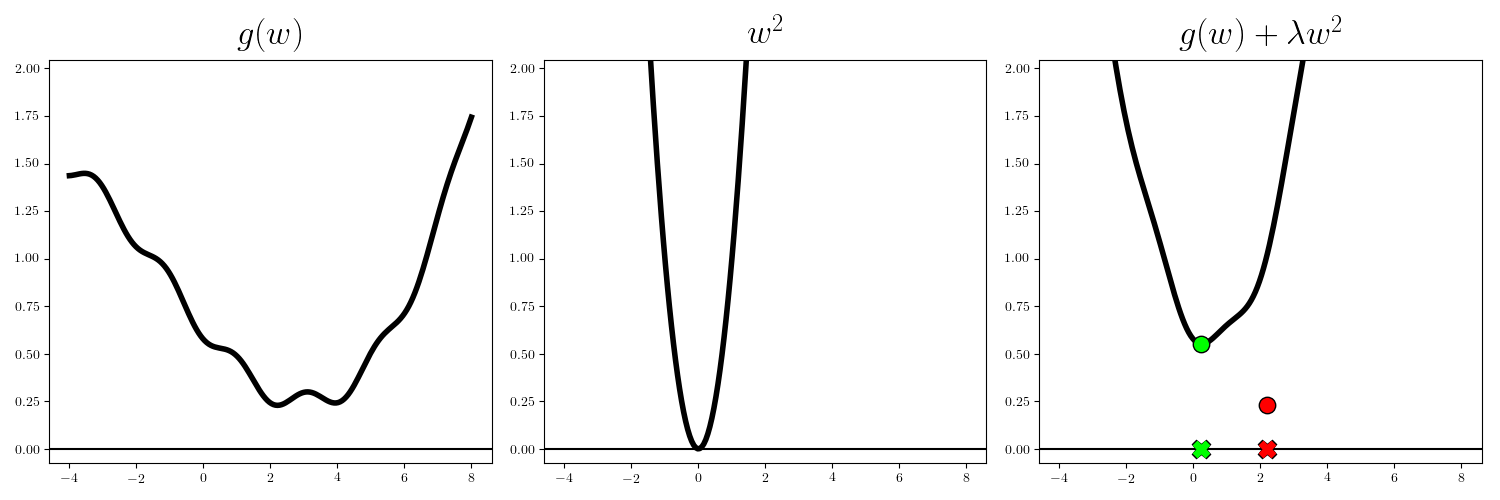
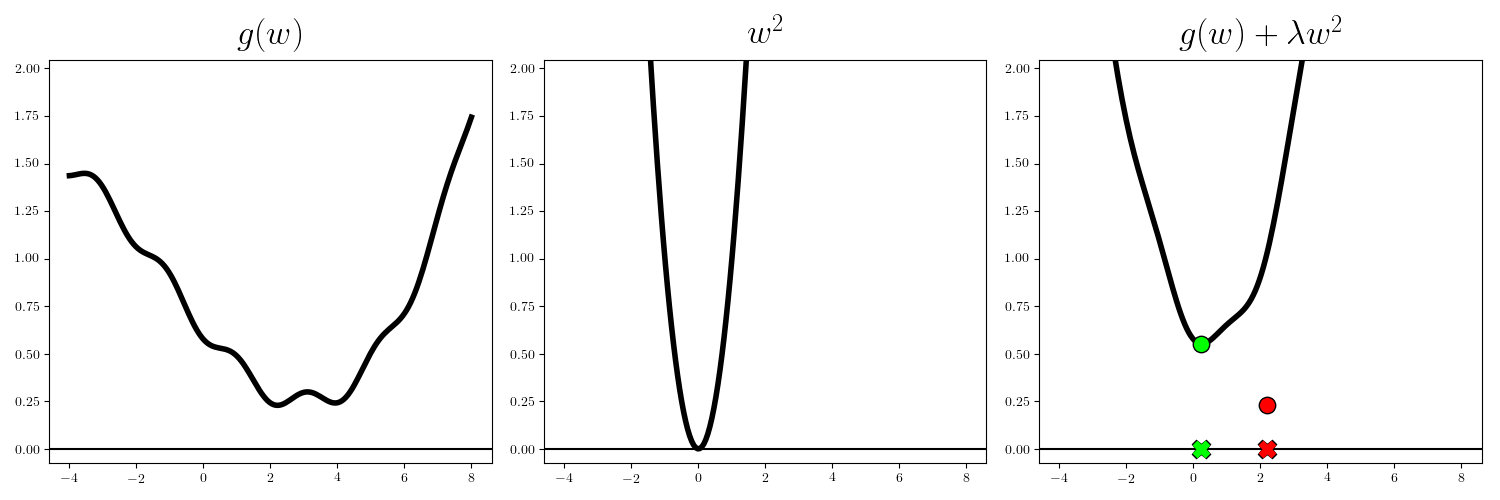
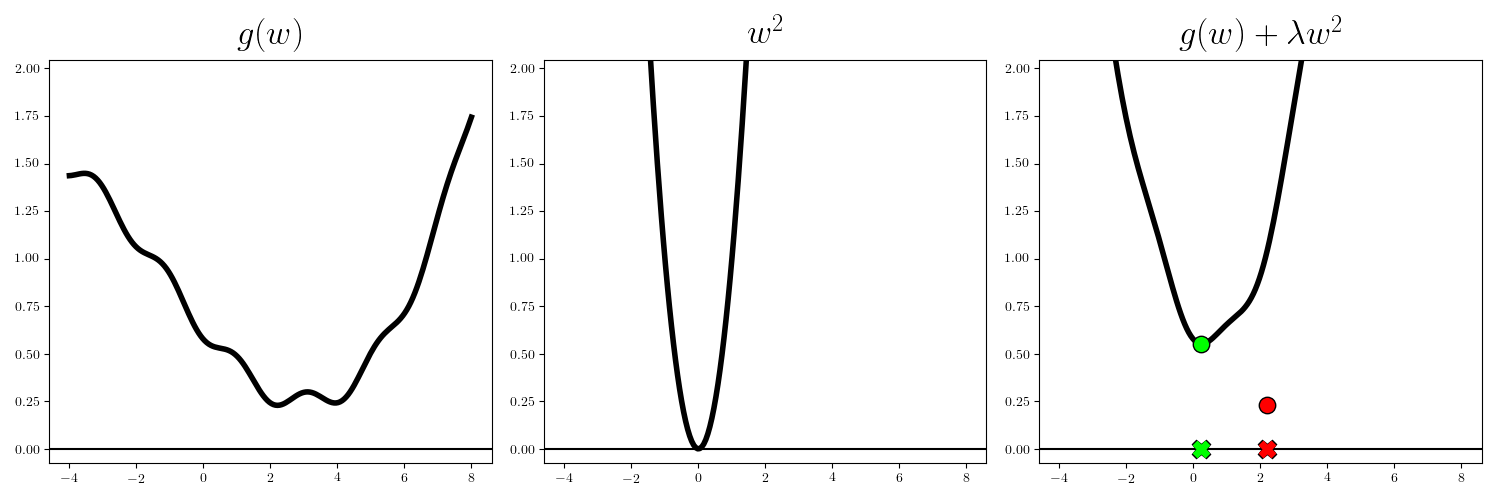
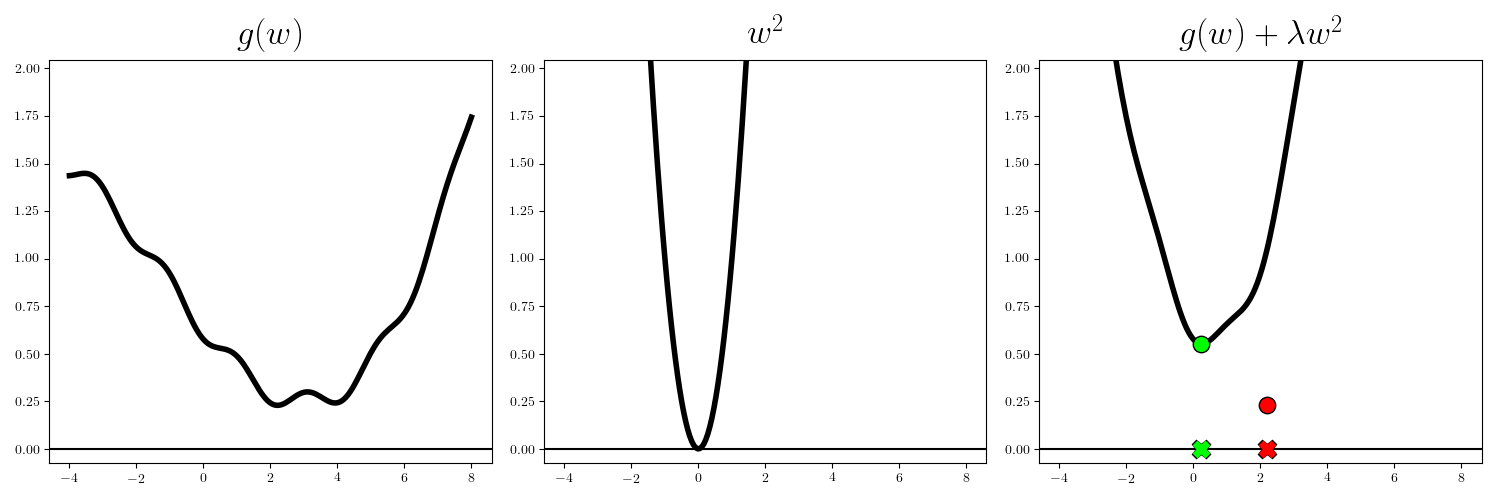
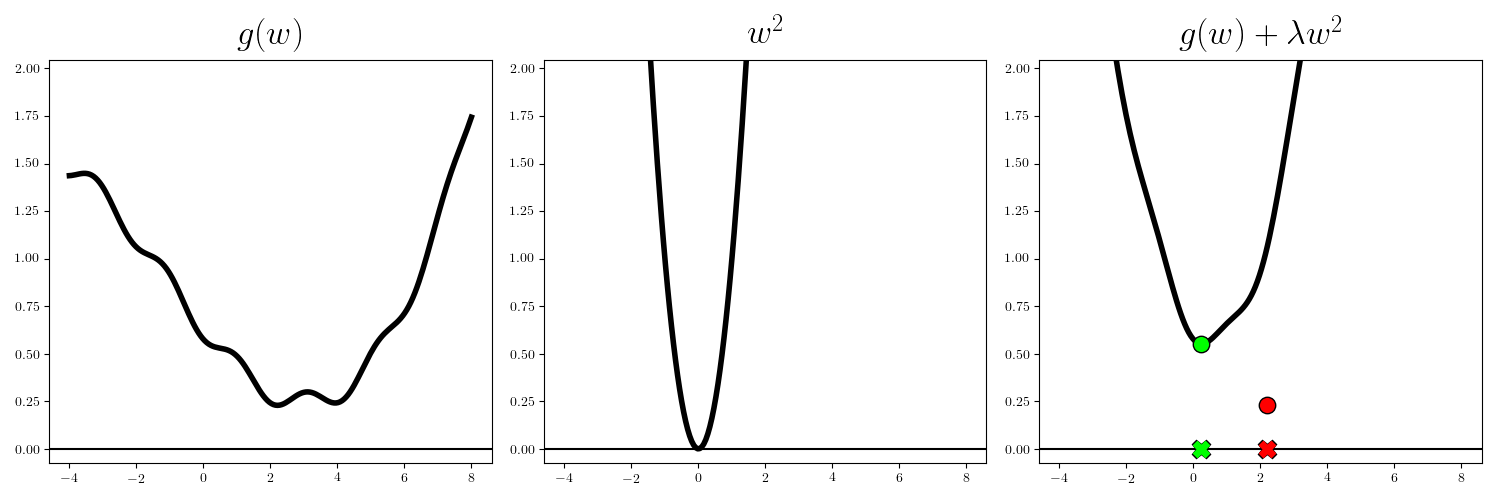
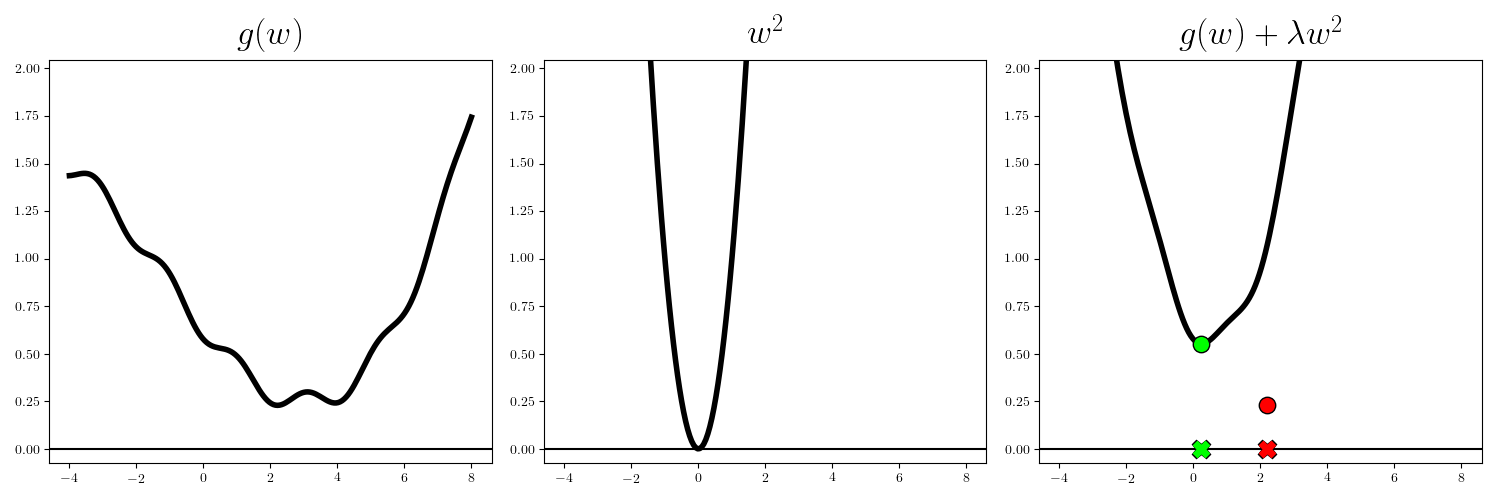
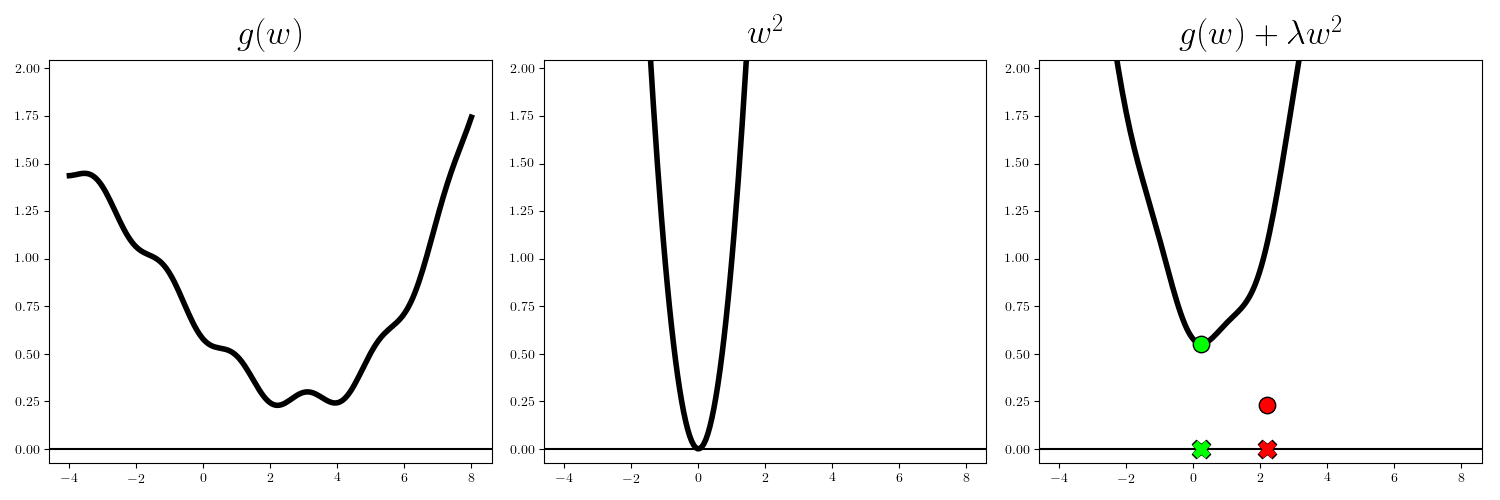
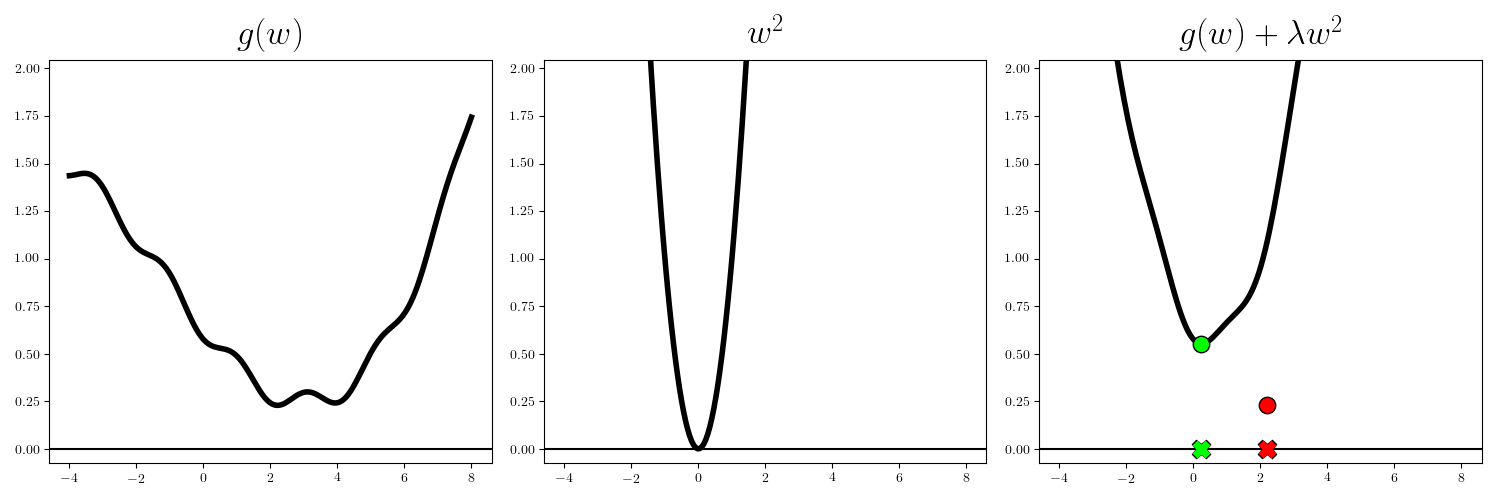
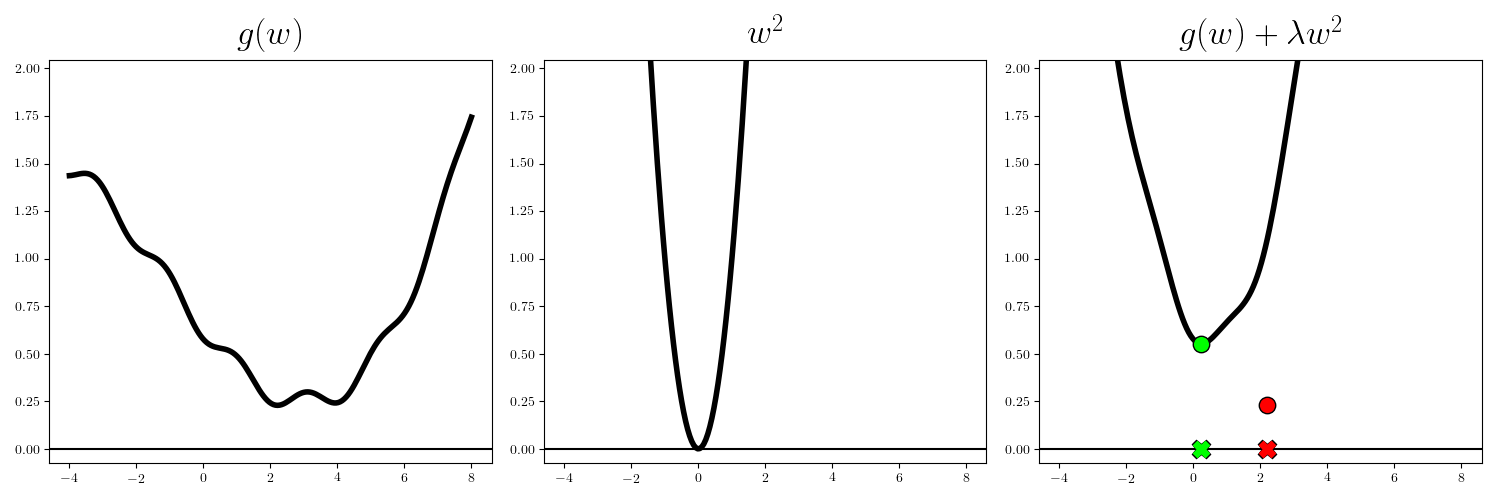
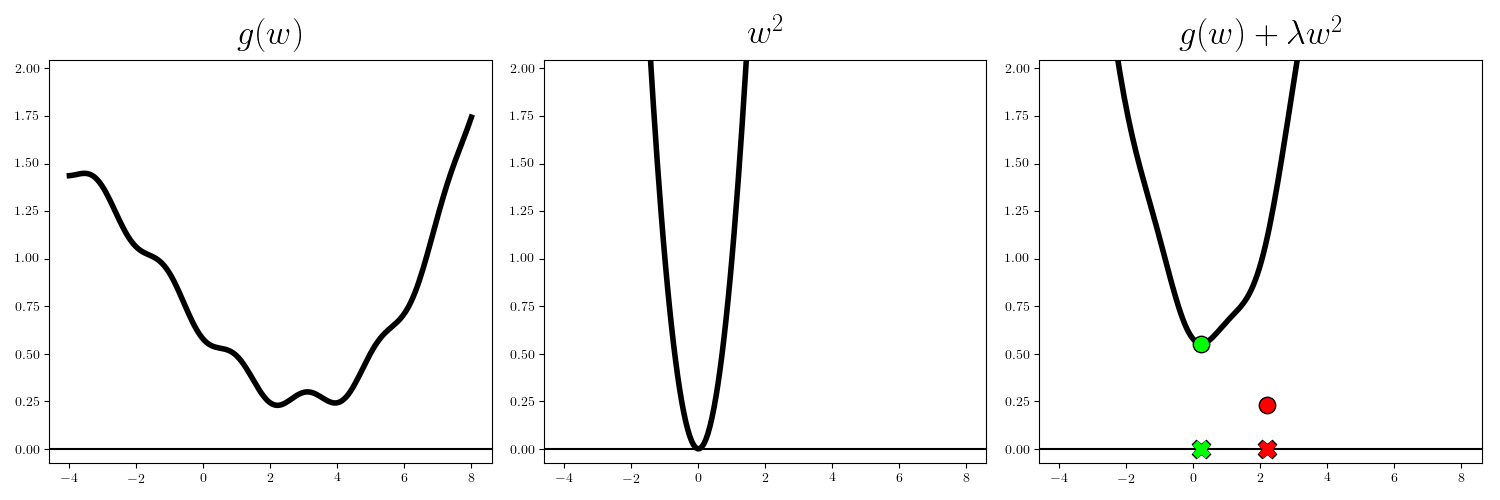
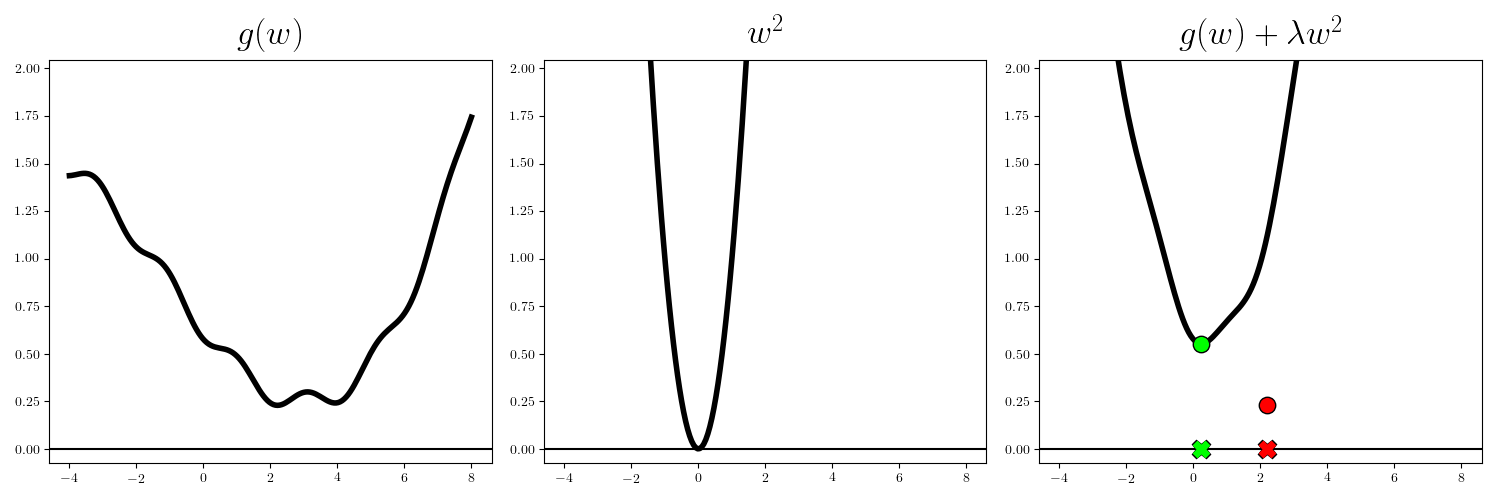
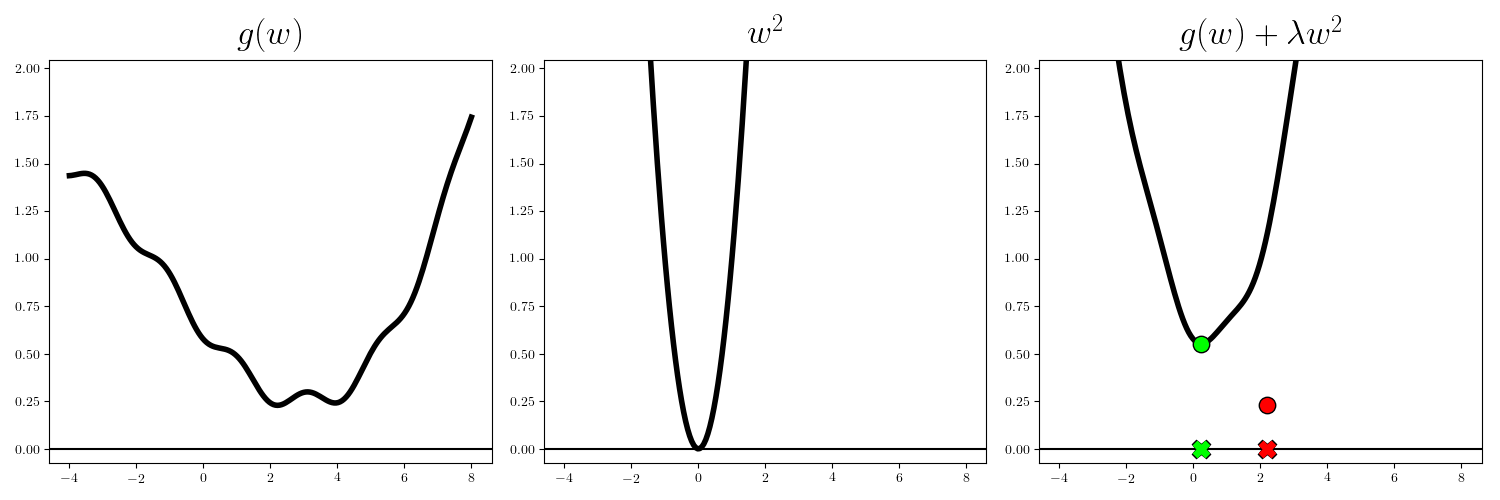
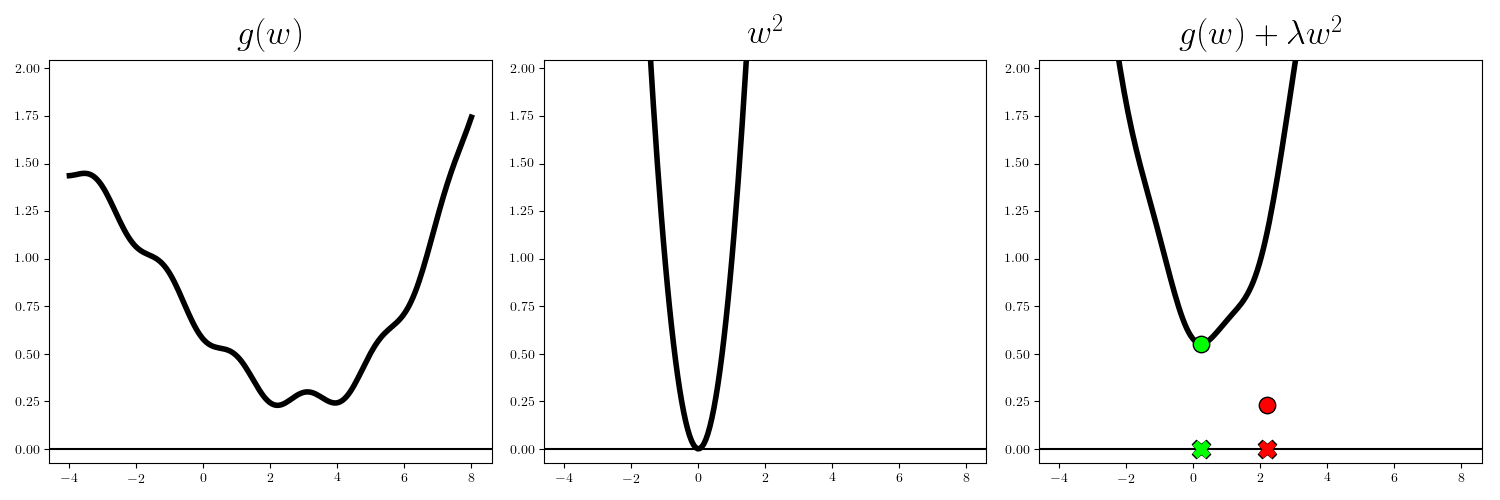
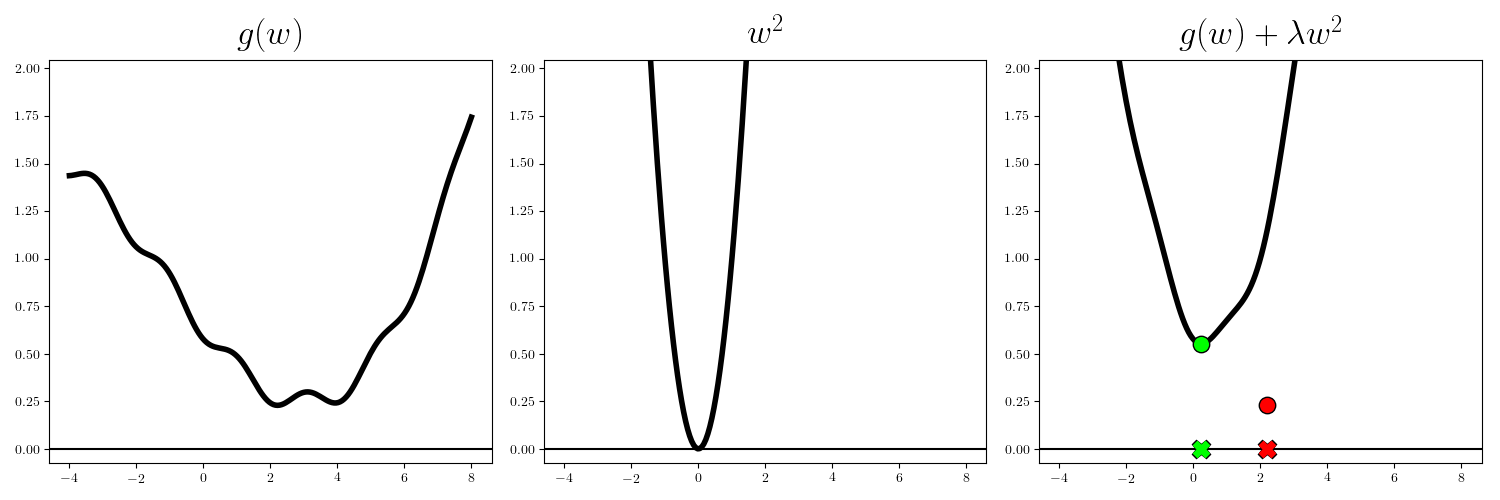
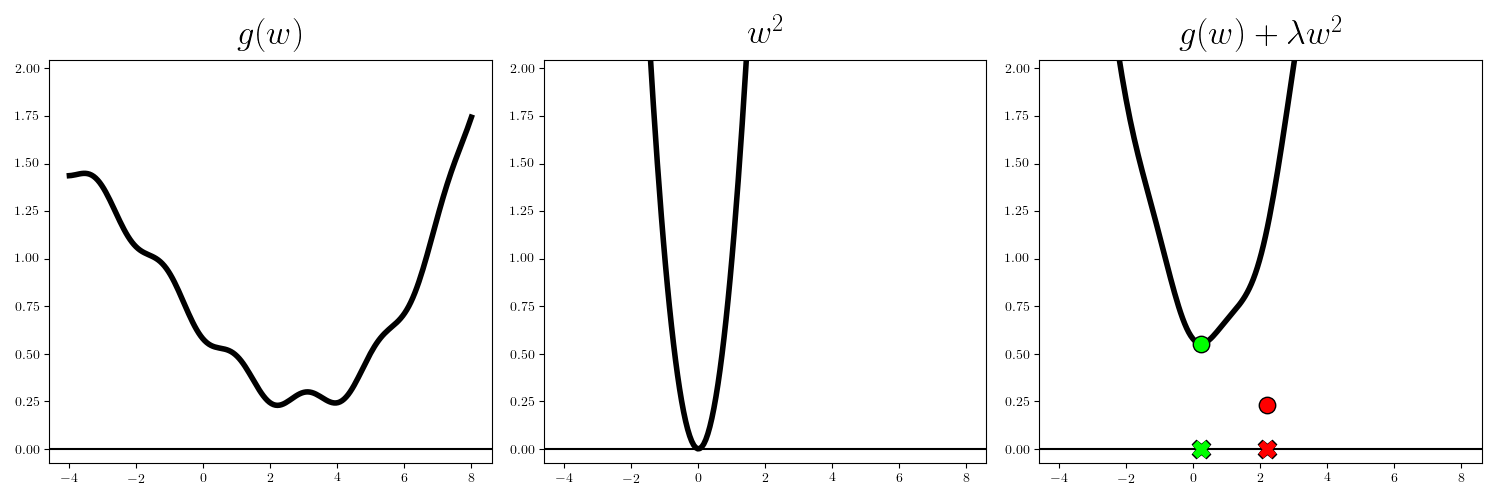
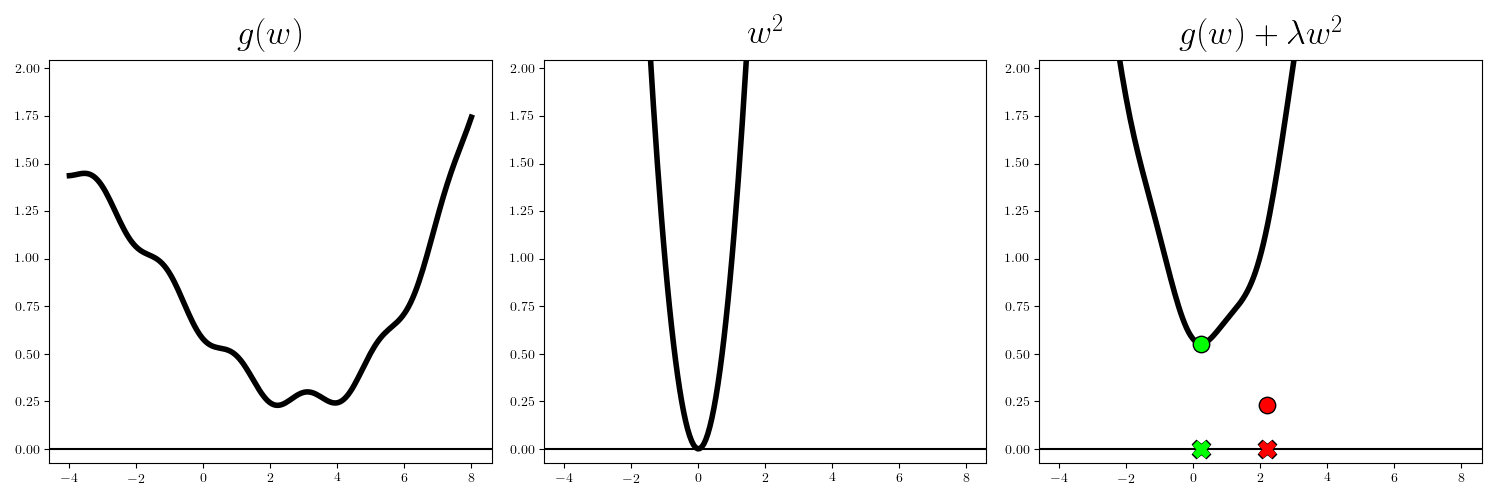
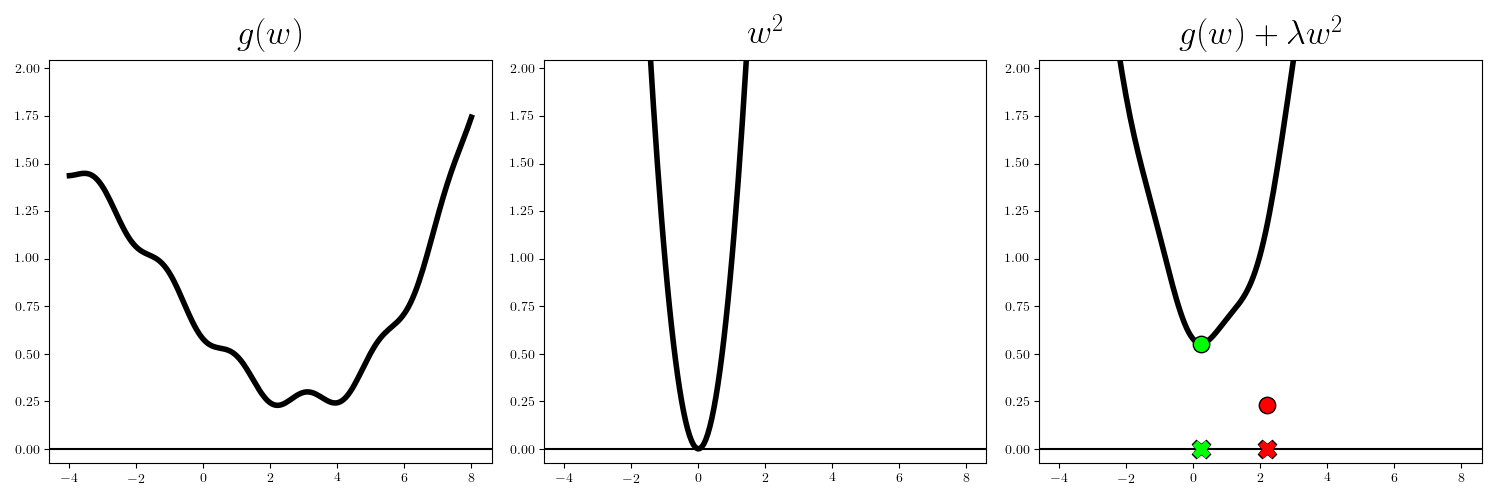
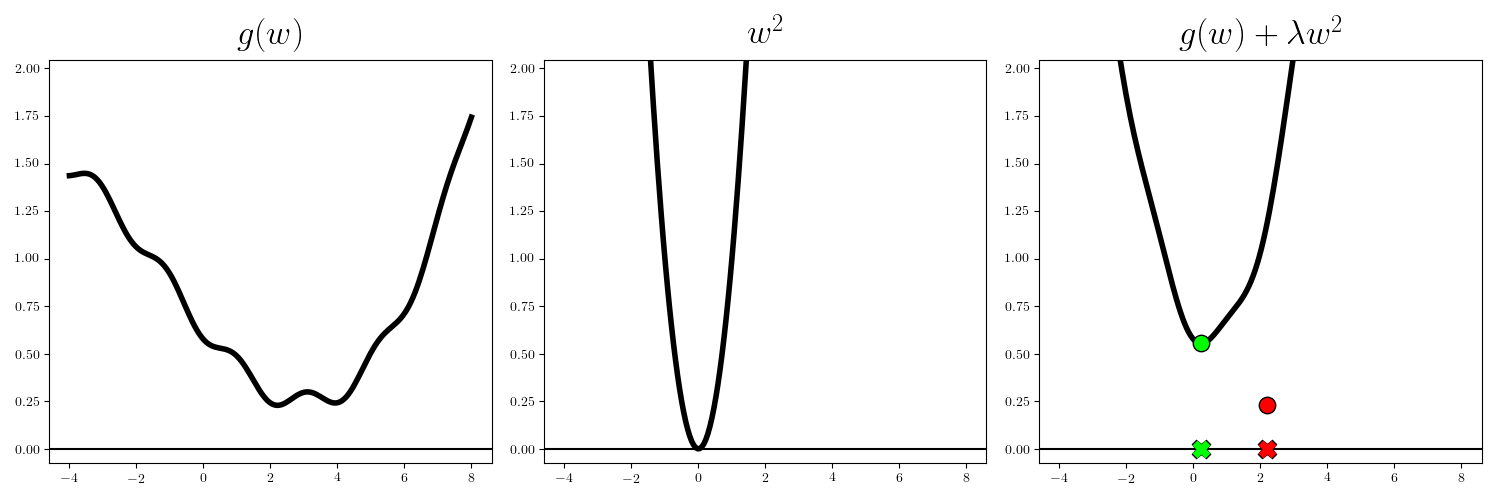
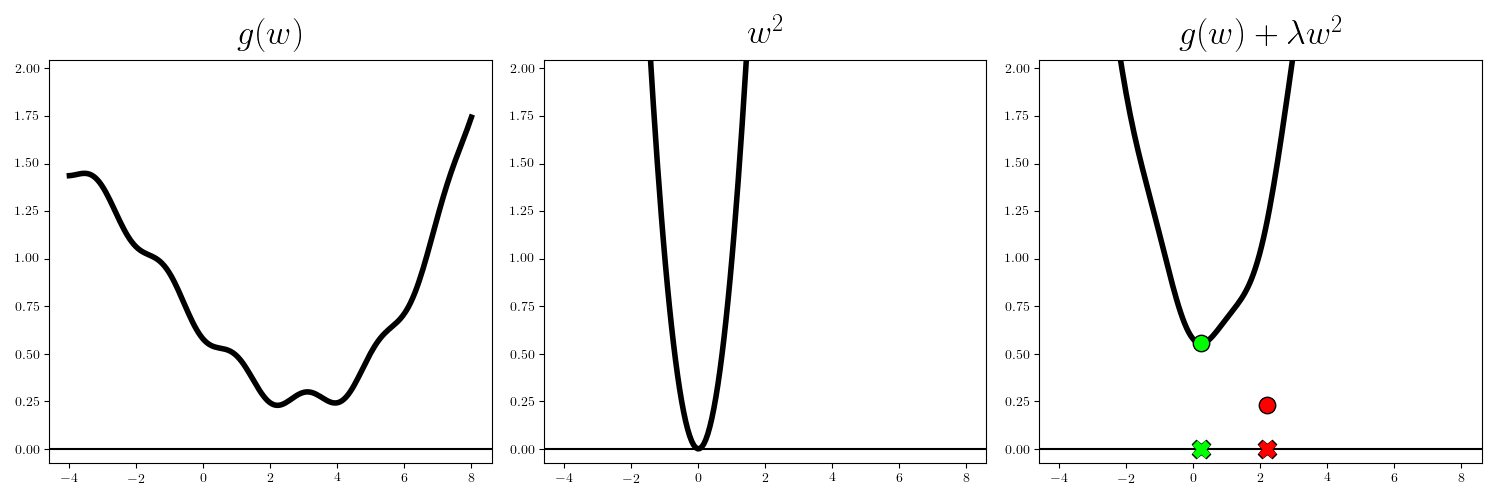

In [39]:
# This code cell will not be shown in the HTML version of this notebook
# what function should we play with?  Defined in the next line.
g1 = lambda w:  (w - 0.5)**2 
g1 = lambda w: np.sin(3*w) + 0.1*w**2 - 0.7
g2 = lambda w: w**2

# create an instance of the visualizer with this function
test = basics_library.convex_function_addition_2d_min_highlight.visualizer()

# plot away
test.draw_it(g1 = g1,g2 = g2,num_frames = 100,min_range = -4,max_range = 8, alpha_range=(0,0.2),title1 = '$g(w)$',title2 = '$w^2$', title3='$g(w) + \\lambda w^2$')

A complete minimization of the cost function plus the simple addition - for any value of $\lambda > 0$ -  will not reach the global minimum of the original cost, and overfitting is prevented provided $\lambda$ is set large enough.  On the other hand, in making sure $\lambda$ is not set too large (or else the cost function itself is completely drowned out by the simple function we added to it, and then we are essentially just minimizing the simple function alone) the sum still somewhat resembles the original function, and its global minimum will lie 'close enough' to the original cost's that the weight $w$ it provides enables a good fit to a corresponding dataset.  This general idea is shown figuratively below.  By *regularizing* the original cost function in this way we can find weights that lie away from the global minima of the original cost function, which when used with our high capacity model provide a good fit.

<figure>
<img src="../../mlrefined_images/nonlinear_superlearn_images/regularization_cross_validation.png" width="80%" height="auto"/>
<figcaption> <strong>Figure 4:</strong> <em>  </em>
A prototypical cost function $g(w)$ - shown in blue - of a high capacity model.  Points near the global minimum of the cost will produce overfitting, while points too far away from the global minimum will tend to produce underfitting.  To find weights in-between these two undesirable extremes we can add a simple function to this cost - here the weighted quadratic $\lambda w^2$ - changing the location of the cost function's global minimum.  By setting the value of $\lambda \geq 0$ properly and by completely minimizing the sum $g(w) + \lambda w^2$ we can find a weight that provides a good fit when employed by our high capacity model.
</figcaption>
</figure>

Before looking at a simple example note a few important items.

- **This idea works regardless of the cost function / regularizer used.**  First note that - of course - this idea generalizes to multi-input functions as well.  For a cost function $g(\mathbf{w})$ taking in $N$ dimensional input $\mathbf{w}$ we can again employ a simple quadratic function as a regularizer.  In this case our *regularized cost function* would take the form $g(\mathbf{w}) + \lambda \mathbf{w}^T\mathbf{w}$.  Often this is written equivalently as

\begin{equation}
g(\mathbf{w}) + \lambda \Vert \mathbf{w} \Vert_2^2
\end{equation}

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; since $\mathbf{w}^T\mathbf{w} =  \Vert \mathbf{w} \Vert_2^2$.  This expresses the simple quadratic in the form of the $\ell_2$ norm. 


- **Different regularizers incentivize weight vectors with different qualities:** Also note that while the simple quadratic is by far the most commonly used regularizer one can - in principle - use any simple function.  For particular applications other popular choices of regularizer functions include the absolute value or $\ell_1$ norm $\Vert \mathbf{w} \Vert_1$, which tends to produce *sparse* weights, and the *total variation* $\sum_{n=1}^{N-1} \vert w_{n+1} - w_n\vert$ which tends to produce  *smoothly varying* weights.  We often use the simple quadratic regularizer to incentivze weights to be *small* - as we naturally do with two class and multiclass logistic regression.  Each of these different kinds of regularizers tends to pull the global minima of the sum towards different portions of the input space - as illustrated below for the quadratic (left panel), $\ell_1$ norm (middle panel), and total variation norm (right panel).


<figure>
<img src="../../mlrefined_images/nonlinear_superlearn_images/regularizers_contours.png" width="130%" height="auto"/>
</figure>


- **The best $\lambda$ is the one that provides minimal validation error.**  How do we choose this value of $\lambda > 0$ correctly in practice (regardless of the regularizer we choose)?  By trying a range of $\lambda$ values, completely minimizing the corresponding regularized cost function, and picking the value of $\lambda$ that provided the *smallest validation error*.  


-  **This technique allows a high degree of overfitting control, but can be very computationally expensive.**  Notice what the point above (that $\lambda$ is chosen to minimize validation error) implies: for each value of $\lambda$ we try we must make a run of some local optimization scheme.  Thus while this approach permits very fine-grained  overfitting, since in principle it allows us much more fine precision in avoiding the global minima of an original cost function than does early stopping, this form of regularization can be far more computationally expensive than the *early stopping* procedure.  

#### <span style="color:#a50e3e;">Example 3. </span>  Tuning the parameter of a quadratic regularized regression

In this example we use a quadratic regularizer to fit a proper nonlinear regression to the prototypical regression dataset shown in the left panel below.  Here the training set is shown in blue, and the validation in yellow.  We use a high capacity model (with respect to this data) - here a degree $8$ polynomial - trying out $20$ values of $\lambda$ between $0$ and $1$ (completely minimizing the corresponding regularized cost in each instance).  As the slider is moved from left to right the fit provided by the weights recovered from the global minimum of each regularized cost function is shown in red in the left panel, while the corresponding training and validation errors are shown in blue and yellow respectively in the right panel.  In this simple experiment, a value somewhere around $\lambda \approx 0.1$ appears to provide the lowest validation error and corresponding best fit to the dataset overall.


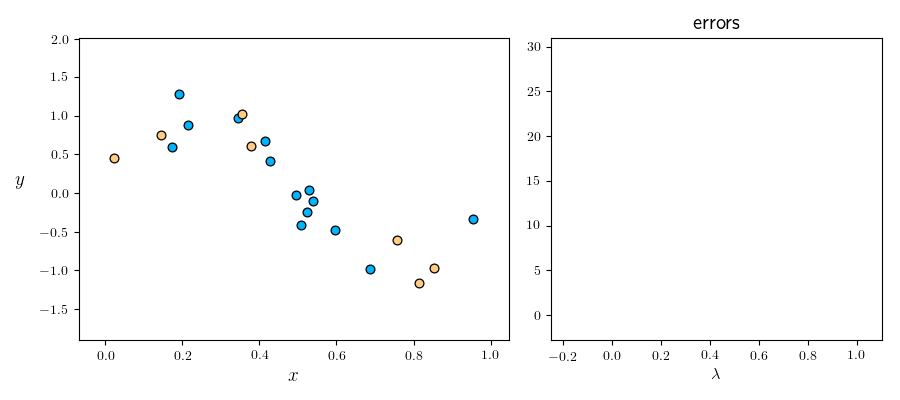
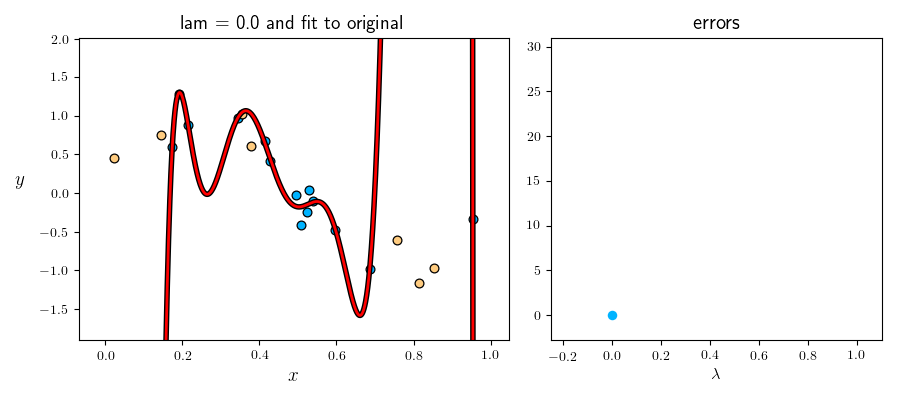
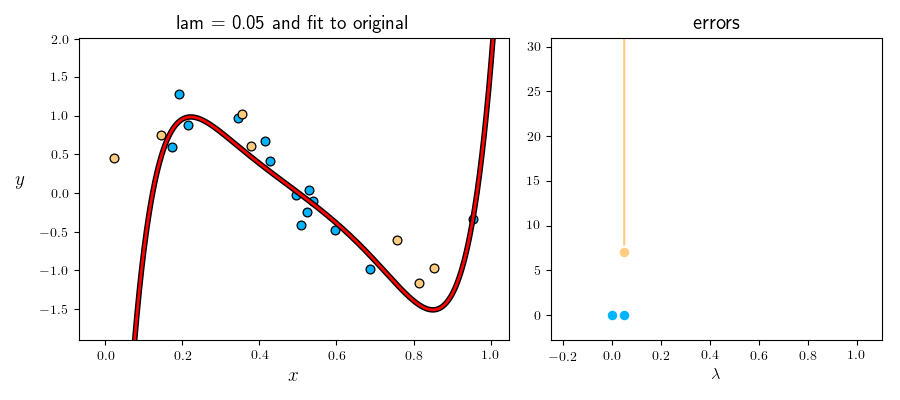
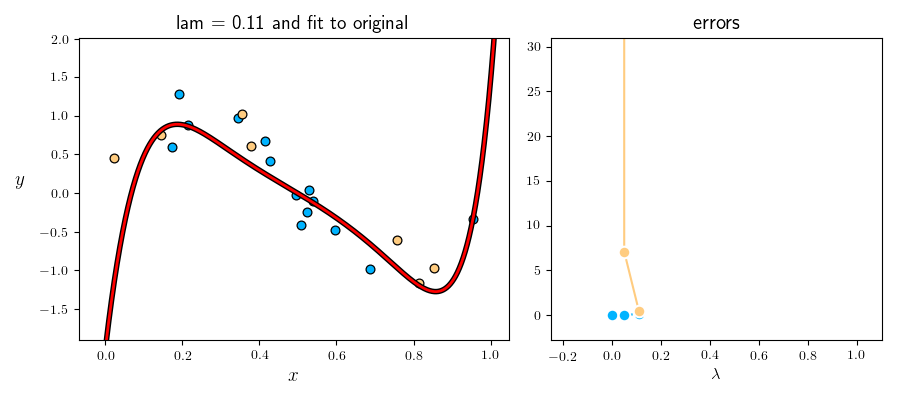
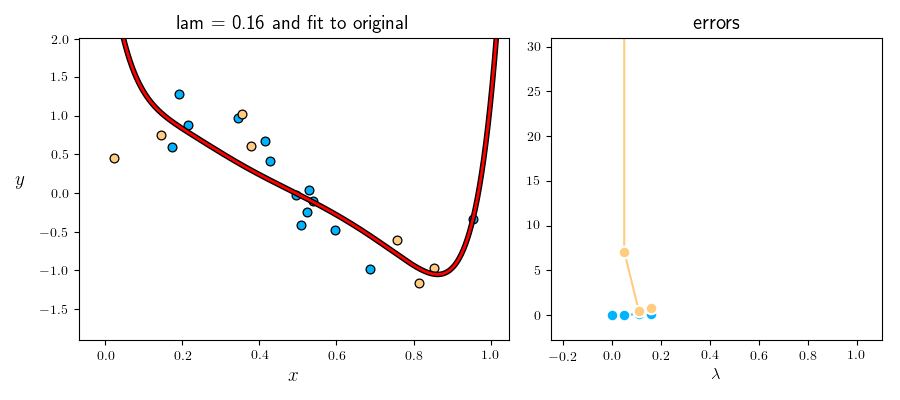
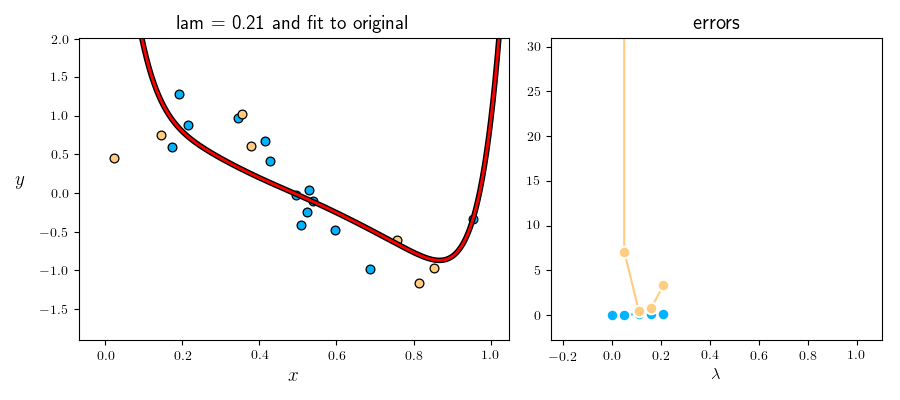
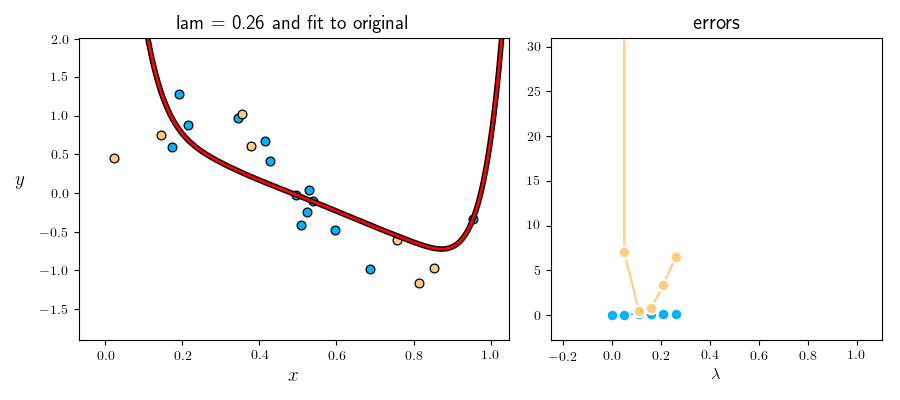
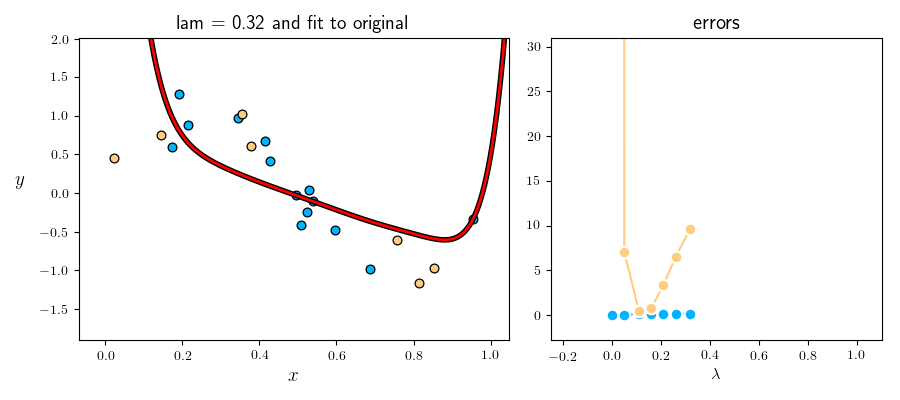
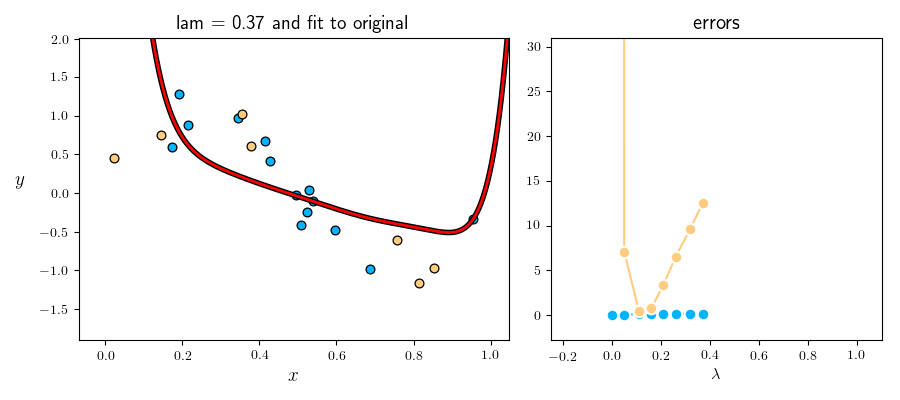
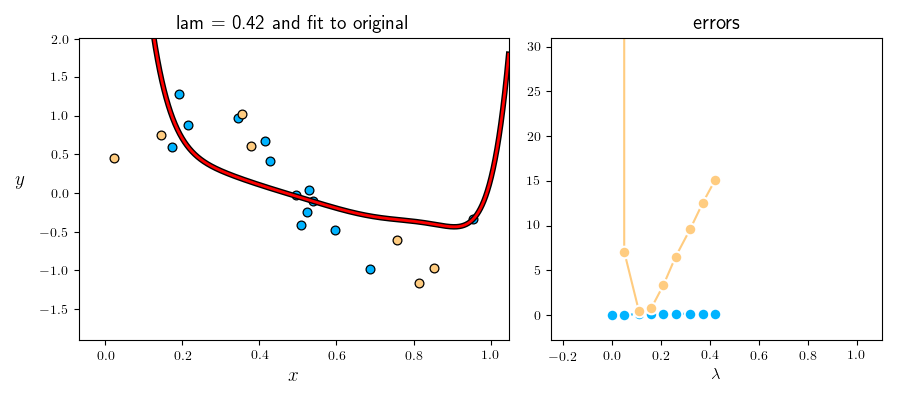
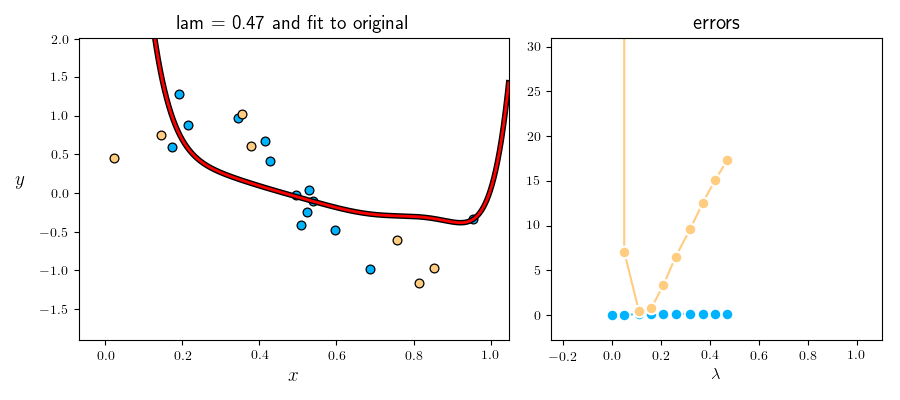
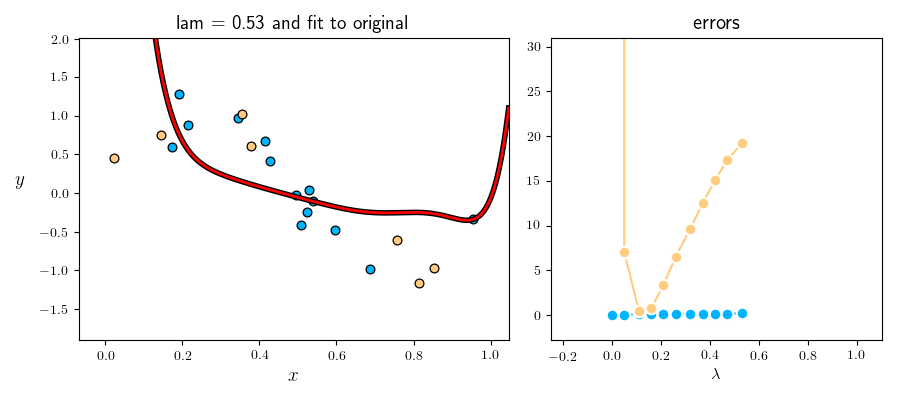
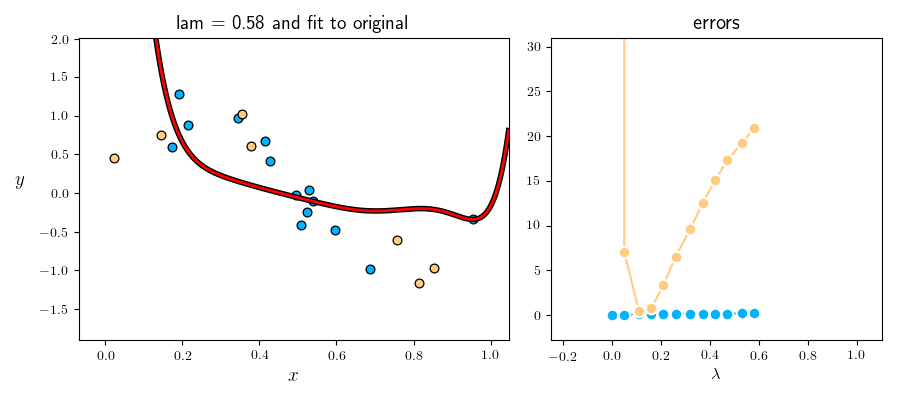
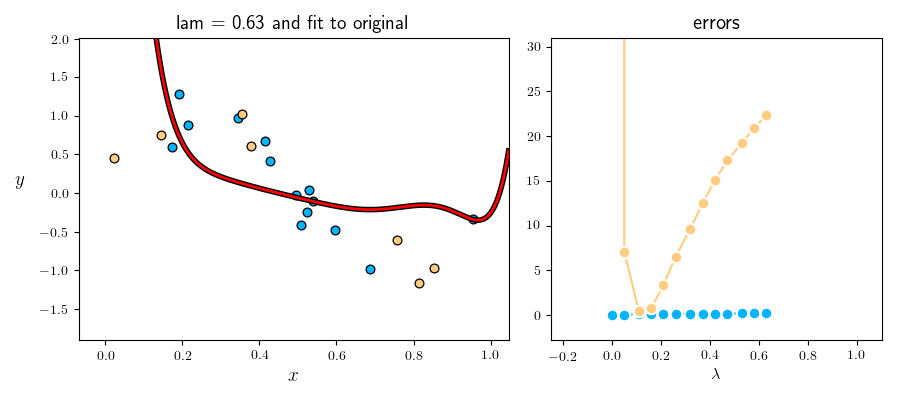
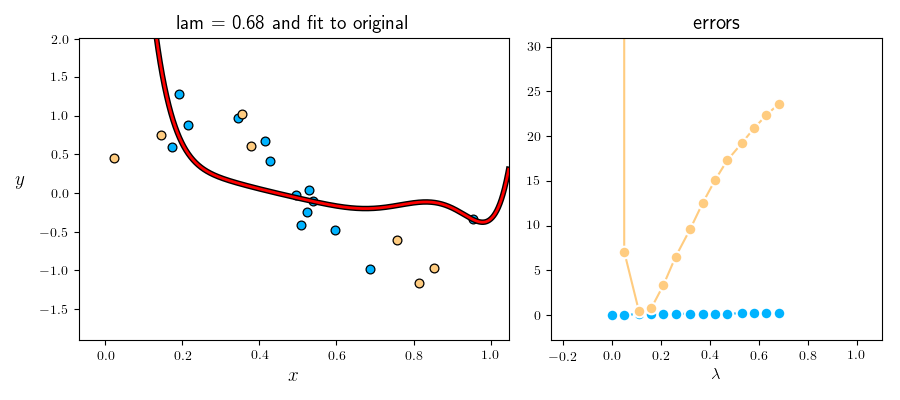
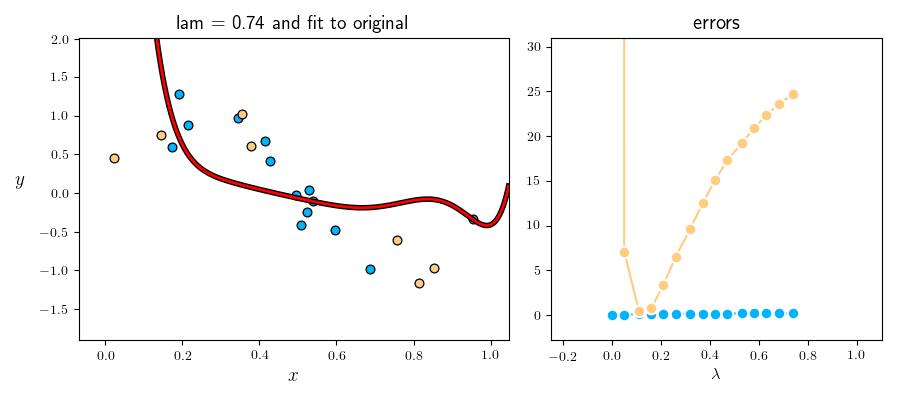
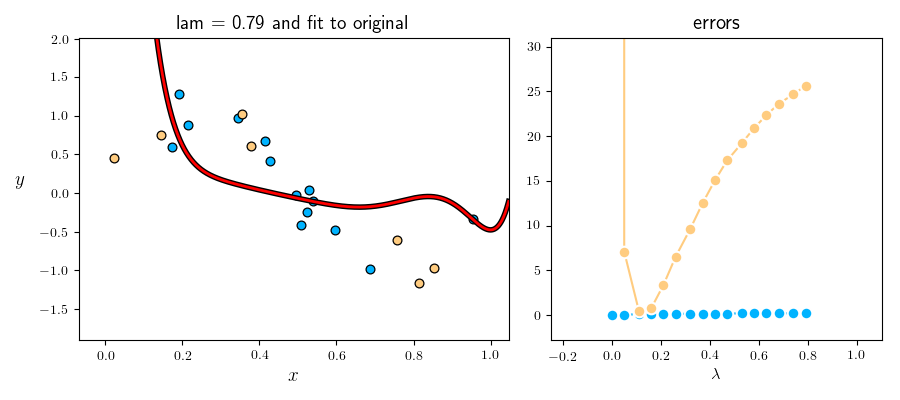
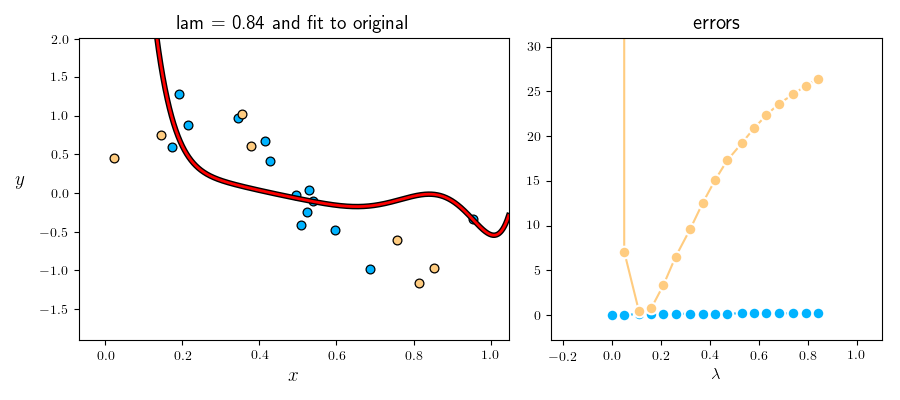
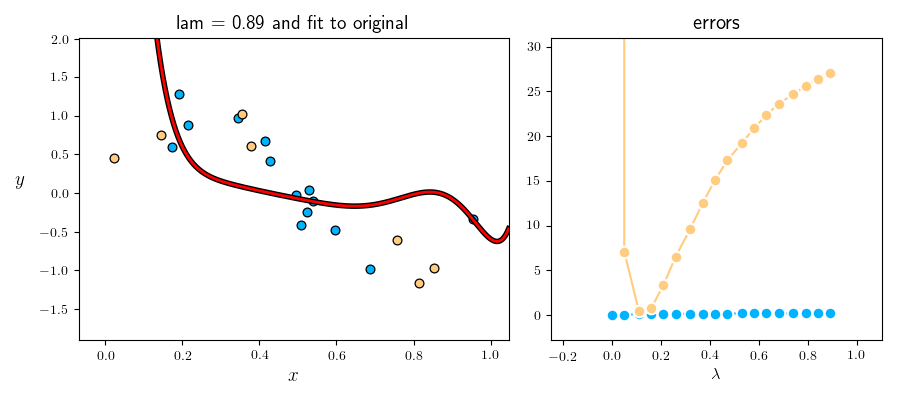
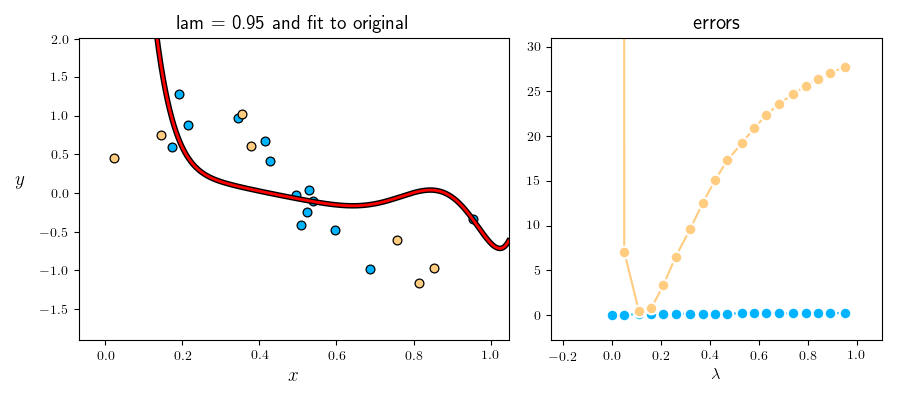
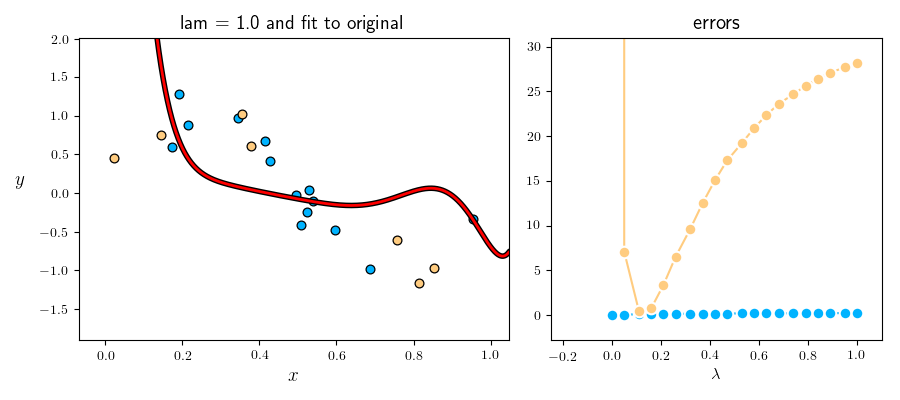

In [61]:
# This code cell will not be shown in the HTML version of this notebook
# load in dataset
csvname = datapath + 'noisy_sin_sample.csv'
data = np.loadtxt(csvname,delimiter = ',')
x = data[:-1,:]
y = data[-1:,:] 

# start process
num_units = 20
degree = 8
train_portion = 0.66
lambdas = np.logspace(-1,1,num_units)
lambdas = np.hstack((0,lambdas))
lambdas = np.linspace(0,1,num_units)
runs1 = []
w = 0
for j in range(num_units):
    lam = lambdas[j]
    
    # initialize with input/output data
    mylib1 = nonlib.reg_lib.super_setup.Setup(x,y)

    # perform preprocessing step(s) - especially input normalization
    mylib1.preprocessing_steps(normalizer = 'none')

    # split into training and validation sets
    if j == 0:
        # make training testing split
        mylib1.make_train_val_split(train_portion = train_portion)
        train_inds = mylib1.train_inds
        val_inds = mylib1.val_inds

    else: # use split from first run for all further runs
        mylib1.x_train = mylib1.x[:,train_inds]
        mylib1.y_train = mylib1.y[:,train_inds]
        mylib1.x_val = mylib1.x[:,val_inds]
        mylib1.y_val = mylib1.y[:,val_inds]
        mylib1.train_inds = train_inds
        mylib1.val_inds = val_inds
        mylib1.train_portion = train_portion

    # choose cost
    mylib1.choose_cost(name = 'least_squares')

    # choose dimensions of fully connected multilayer perceptron layers
    mylib1.choose_features(feature_name = 'polys',degree = degree)
    
    if j == 0:
        # fit an optimization
        mylib1.fit(algo = 'newtons_method',max_its = 1,verbose = False,lam = lam)
    else:
        mylib1.fit(algo = 'newtons_method',max_its = 1,verbose = False,lam = lam,w=w)

    # add model to list
    runs1.append(copy.deepcopy(mylib1))
    w = mylib1.w_init

# animate the business
frames = num_units
demo1 = nonlib.regularization_regression_animators.Visualizer(csvname)
demo1.animate_trainval_regularization(runs1,frames,num_units,show_history = True)